In [1]:
import numpy as np
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
from analysis_count_3task_3_0g import read_n, classify_imgs2
import matplotlib.pyplot as plt
import operator
%matplotlib inline

['/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py', '-f', 'true', 'true', 'true', 'true', 'true', 'model_runs/-f/count_log.csv', 'model_runs/-f/prepoint_0.ckpt', 'model_runs/-f/countmodel_', 'true', 'false', 'false', 'true']
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` in

In [2]:
model_name = "3task_pre_0130"
directory_name = "POINT_3task_pre_0130_TOUCHPHASE"
num_runs = 3
test_trials = 500
iter_list = np.arange(0, 43000, 500)
#iter_list = [0, 100, 200, 300, 400, 600, 800, 1200, 1600, 2400, 3200, 4800, 6400, 9600, 12800, 19200, 25600]#, 38400, 51200]#, 76800, 102400, 153600, 204800, 307200, 409600, 614400, 819200, 1000000]
            #[0, 400, 800, 1600, 3200, 6400, 12800, 25600, 51200]#, 76800, 102400]#, 153600, 204800, 307200, 409600, 614400, 819200, 1000000, 2000000, 3000000, 4000000]
             #[0, 1000, 4000, 16000, 32000, 64000, 125000, 250000, 500000, 600000]
#iter_list = np.arange(0,11100000,100000)
glimpse_list = np.arange(0,10,1)
max_blobs = 9
min_blobs = 1

num_iters = len(iter_list)
num_glimpses = len(glimpse_list)
blob_list = np.arange(0,10,1)
output_size = max_blobs - min_blobs + 2 # 10
data_directory = "data/" + directory_name + "/"
m = 0.5
num_imgs = test_trials*(output_size-1)
confidence_all_runs = np.zeros([num_runs, num_iters, output_size-1, num_glimpses, 1, output_size]) 
choice_all_runs = np.zeros([num_runs, num_iters, output_size-1, num_glimpses, 1, output_size])
countword_all_runs = np.zeros([num_runs, num_iters, num_imgs, output_size+1])
pointblob_all_runs = np.zeros([num_runs, num_iters, num_imgs, output_size+1])
point_target_all_runs = np.zeros([num_runs, num_iters, num_imgs, num_glimpses])
blob_point_all_runs = np.zeros([num_runs, num_iters, num_imgs, output_size+1])
class_all_runs = np.zeros([num_runs, num_iters, num_imgs])
point_results_all_runs = np.zeros([num_runs, num_iters, num_imgs, num_glimpses])

In [3]:
def fill_matrix(path, iteration):
    """Fill the confidence and choice matrices for one run at one iteration."""
    
    data = None
    num_imgs = test_trials*(output_size-1) # batch_size
    imgs_data = classify_imgs2(iteration, True, num_imgs, path=path) # new_imgs = True
        
    confidence_one_run = np.zeros([output_size-1, num_glimpses, 1, output_size])
    choice_one_run = np.zeros([output_size-1, num_glimpses, 1, output_size])
    countword_one_run = np.zeros([num_imgs, output_size+1])
    pointblob_one_run = np.zeros([num_imgs, output_size+1])
    point_target_one_run = np.zeros([num_imgs, num_glimpses])
    blob_point_one_run = np.zeros([num_imgs, output_size+1])
    class_one_run = np.zeros(num_imgs)
    point_results_one_run = np.zeros([num_imgs, num_glimpses]) # 1 to 9
    
    for nb in range(output_size-1):
        confidence_hist = np.zeros([num_glimpses, 1, output_size])
        choice_hist = np.zeros([num_glimpses, 1, output_size])
        num_imgs_with_num_blobs = 0.00001
        
        for idx, data in enumerate(imgs_data):
            if data["label"][nb] == 1: # data is for an image with nb+1 blobs
                num_imgs_with_num_blobs += 1
                countword_one_run[idx][0]=nb+1
                pointblob_one_run[idx][0]=nb+1
                
                for g, glimpse in enumerate(glimpse_list):
                    # Histogram of softmaxes
                    confidence_hist[glimpse] += data["classifications"][glimpse]
                    # Histogram of choices
                    choice = np.argmax(data["classifications"][glimpse])
                    choice_list = [0] * (output_size)
                    choice_list[choice] = 1
                    choice_hist[glimpse] += choice_list
                    # Count Word
                    countword_one_run[idx][glimpse+1]=choice
                    # Point Blob
                    pointblob_one_run[idx][glimpse+1]=int(data["corrects"][glimpse])
                
                pointblob_one_run[idx][nb+2]=nb+1
                point_target_one_run[idx] = data["corrects"]
                point_target_one_run[idx][nb+1] = nb+1
                class_one_run[idx] = data["class"]+1
                
        confidence_hist = confidence_hist / num_imgs_with_num_blobs
        confidence_one_run[nb] = confidence_hist.tolist()
        choice_hist = choice_hist / num_imgs_with_num_blobs
        choice_one_run[nb] = choice_hist.tolist()
        
    for idx, data in enumerate(imgs_data):
        for g in range(1,num_glimpses+1):
            blob_point_one_run[idx][g] = int(data["blob_point"][g-1])
        blob_point_one_run[idx][0] = data["class"]+1
        #gg=0
        #while (gg<int(data["class"]+2)):
        #for gg in range(int(data["class"]+2)):
            #if point_target_one_run[idx][gg] == blob_point_one_run[idx][gg]:
                #gg+=1
         
        #if gg==data["class"]+1:
               #point_results_one_run[int(data["class"])-1]+=1            
    
    return confidence_one_run, choice_one_run, countword_one_run, point_target_one_run, blob_point_one_run, pointblob_one_run, point_results_one_run, class_one_run

In [4]:
for run in range(num_runs):
    path = 'model_runs/' + model_name + '_run_' + str(run + 1) 
#     path = 'model_runs/DRAM_test_square'
    for i, iteration in enumerate(iter_list):
        confidence_all_runs[run, i], choice_all_runs[run, i], countword_all_runs[run, i], point_target_all_runs[run, i], blob_point_all_runs[run, i], pointblob_all_runs[run, i],point_results_all_runs[run, i], class_all_runs[run, i] = fill_matrix(path, iteration)

INFO:tensorflow:Restoring parameters from model_runs/3task_pre_0130_run_1/prepoint_0.ckpt
INFO:tensorflow:Restoring parameters from model_runs/3task_pre_0130_run_1/prepoint_500.ckpt
INFO:tensorflow:Restoring parameters from model_runs/3task_pre_0130_run_1/prepoint_1000.ckpt
INFO:tensorflow:Restoring parameters from model_runs/3task_pre_0130_run_1/prepoint_1500.ckpt
INFO:tensorflow:Restoring parameters from model_runs/3task_pre_0130_run_1/prepoint_2000.ckpt
INFO:tensorflow:Restoring parameters from model_runs/3task_pre_0130_run_1/prepoint_2500.ckpt
INFO:tensorflow:Restoring parameters from model_runs/3task_pre_0130_run_1/prepoint_3000.ckpt
INFO:tensorflow:Restoring parameters from model_runs/3task_pre_0130_run_1/prepoint_3500.ckpt
INFO:tensorflow:Restoring parameters from model_runs/3task_pre_0130_run_1/prepoint_4000.ckpt
INFO:tensorflow:Restoring parameters from model_runs/3task_pre_0130_run_1/prepoint_4500.ckpt
INFO:tensorflow:Restoring parameters from model_runs/3task_pre_0130_run_1/

INFO:tensorflow:Restoring parameters from model_runs/3task_pre_0130_run_2/prepoint_1000.ckpt
INFO:tensorflow:Restoring parameters from model_runs/3task_pre_0130_run_2/prepoint_1500.ckpt
INFO:tensorflow:Restoring parameters from model_runs/3task_pre_0130_run_2/prepoint_2000.ckpt
INFO:tensorflow:Restoring parameters from model_runs/3task_pre_0130_run_2/prepoint_2500.ckpt
INFO:tensorflow:Restoring parameters from model_runs/3task_pre_0130_run_2/prepoint_3000.ckpt
INFO:tensorflow:Restoring parameters from model_runs/3task_pre_0130_run_2/prepoint_3500.ckpt
INFO:tensorflow:Restoring parameters from model_runs/3task_pre_0130_run_2/prepoint_4000.ckpt
INFO:tensorflow:Restoring parameters from model_runs/3task_pre_0130_run_2/prepoint_4500.ckpt
INFO:tensorflow:Restoring parameters from model_runs/3task_pre_0130_run_2/prepoint_5000.ckpt
INFO:tensorflow:Restoring parameters from model_runs/3task_pre_0130_run_2/prepoint_5500.ckpt
INFO:tensorflow:Restoring parameters from model_runs/3task_pre_0130_ru

INFO:tensorflow:Restoring parameters from model_runs/3task_pre_0130_run_3/prepoint_2000.ckpt
INFO:tensorflow:Restoring parameters from model_runs/3task_pre_0130_run_3/prepoint_2500.ckpt
INFO:tensorflow:Restoring parameters from model_runs/3task_pre_0130_run_3/prepoint_3000.ckpt
INFO:tensorflow:Restoring parameters from model_runs/3task_pre_0130_run_3/prepoint_3500.ckpt
INFO:tensorflow:Restoring parameters from model_runs/3task_pre_0130_run_3/prepoint_4000.ckpt
INFO:tensorflow:Restoring parameters from model_runs/3task_pre_0130_run_3/prepoint_4500.ckpt
INFO:tensorflow:Restoring parameters from model_runs/3task_pre_0130_run_3/prepoint_5000.ckpt
INFO:tensorflow:Restoring parameters from model_runs/3task_pre_0130_run_3/prepoint_5500.ckpt
INFO:tensorflow:Restoring parameters from model_runs/3task_pre_0130_run_3/prepoint_6000.ckpt
INFO:tensorflow:Restoring parameters from model_runs/3task_pre_0130_run_3/prepoint_6500.ckpt
INFO:tensorflow:Restoring parameters from model_runs/3task_pre_0130_ru

In [5]:
# Point
sort_pws = np.zeros([num_runs, num_iters, num_imgs, output_size+1])

for i in range(num_runs):
    for j in range(num_iters):
        sort_pws[i][j]=sorted(blob_point_all_runs[i, j, :], key = operator.itemgetter(-1,1,2,3,4,5,6,7,8,9,10), reverse = False) # sorted count words

pstop_idx=np.ones([num_runs, num_iters, num_imgs])*(-1)

for i in range(num_runs):
    for j in range(num_iters):
        for k in range (num_imgs):
            for p in range (2, output_size+1):
                if sort_pws[i][j][k][p]!=-1 and sort_pws[i][j][k][p]==sort_pws[i][j][k][p-1]: # record end position
                    pstop_idx[i][j][k]=p
                    break # stop at the first repeated word

point_results=np.zeros([num_runs, num_iters, 9, 10])  

for i in range(num_runs):
    for j in range(num_iters):
        for k in range(num_imgs):
            # not-well-formed
            if pstop_idx[i][j][k]==-1: # no "I'm done!" signal
                point_results[i][j][k//test_trials][9]+=1         
            else:
                for p in range(1,int(pstop_idx[i][j][k])): 
                    if p!=sort_pws[i][j][k][p]:
                        point_results[i][j][k//test_trials][9]+=1
                        break 
                    elif p==pstop_idx[i][j][k]-1:
                        idx=int(max(sort_pws[i][j][k][1:int(pstop_idx[i][j][k])+1]))
                        point_results[i][j][k//test_trials][idx-1]+=1
                        
# Point Accuracy
point_accuracy = np.zeros([num_runs, output_size-1, num_iters])
for i in range(num_runs):
    for j in range(output_size-1):
        for k in range(num_iters):
            point_accuracy[i][j][k]=point_results[i][k][j][j]/test_trials

In [6]:
def plot_point_results_wv(run, it):
    """Plot the point heatmap with values."""
    data = point_results[run, it]
    title = "Point at Run %d after %d Iters" % (run + 1, iter_list[it])
    xlabel= "Point Results"
    ylabel="True Class"
    plt.figure(figsize=(output_size, output_size-1))
    plt.title(title, fontsize=20)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    c = plt.pcolor(data, edgecolors='k', linewidths=2, cmap='Reds', vmin=0, vmax=test_trials)
    xbars = ('1', '2', '3', '4', '5', '6', '7', '8', '9', 'NWF')
    x_pos=[0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5]
    plt.xticks(x_pos, xbars, fontsize='10', horizontalalignment='center')
    ybars = ('1', '2', '3', '4', '5', '6', '7', '8', '9')
    y_pos=[0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5]
    plt.yticks(y_pos, ybars, fontsize='10', horizontalalignment='center')
 
    def show_values(pc, fmt="%.0f", **kw):
        pc.update_scalarmappable()
        ax = pc.get_axes()
        for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
            x, y = p.vertices[:-2, :].mean(0)
            color = (0.0, 0.0, 0.0) # value color
            ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)

    show_values(c)
    plt.colorbar(c)

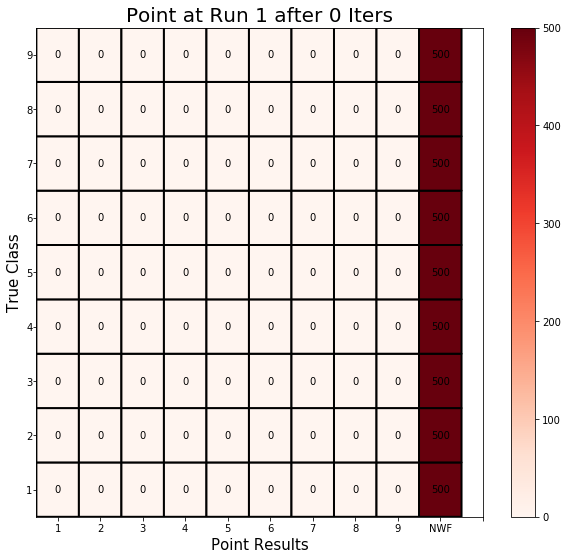

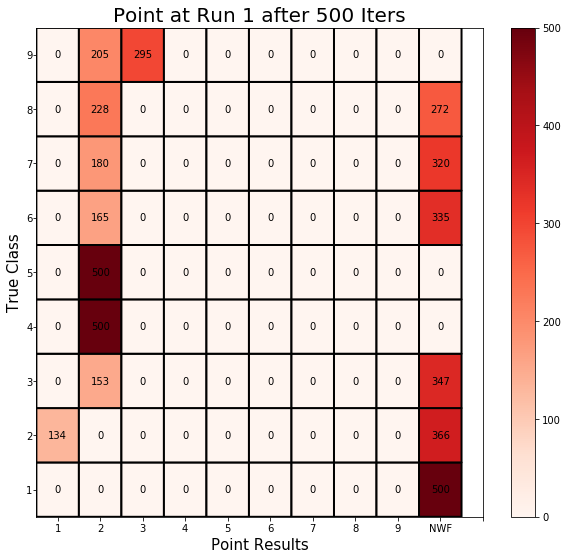

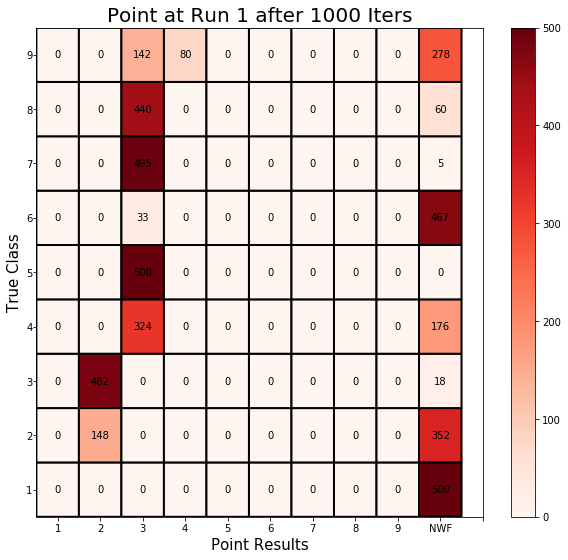

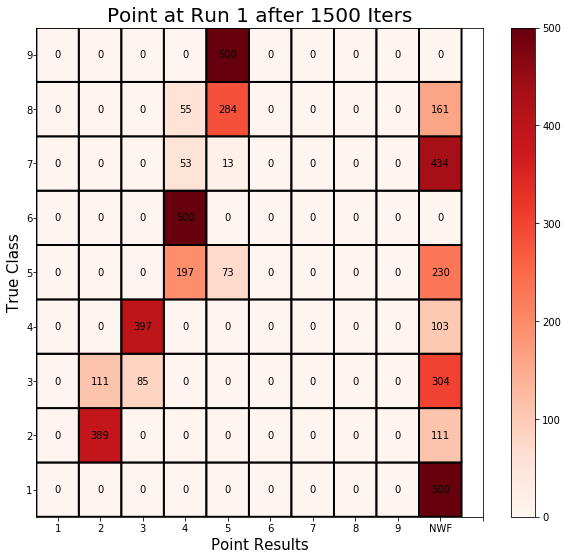

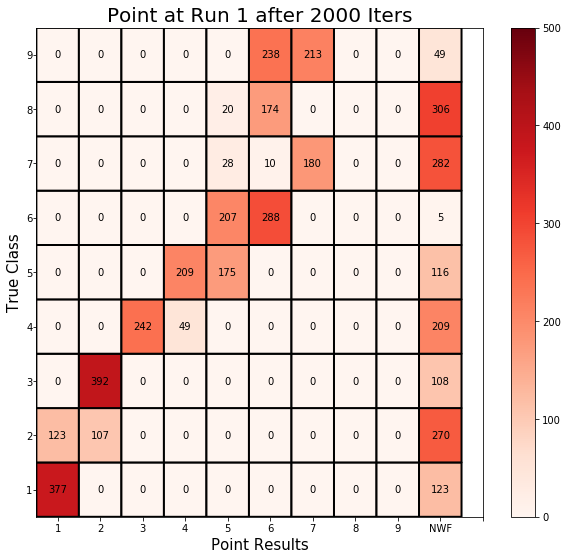

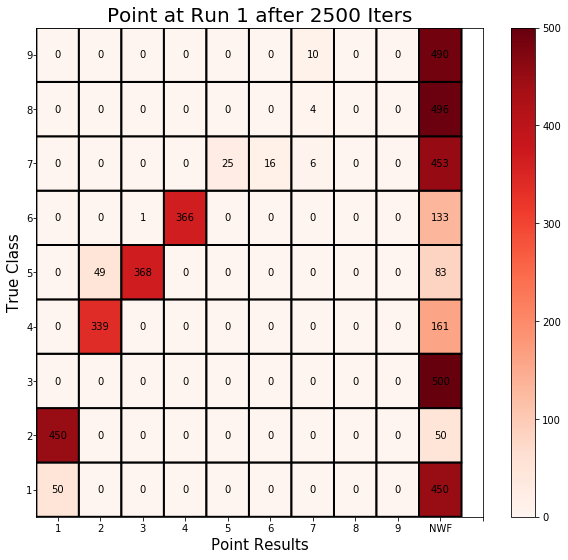

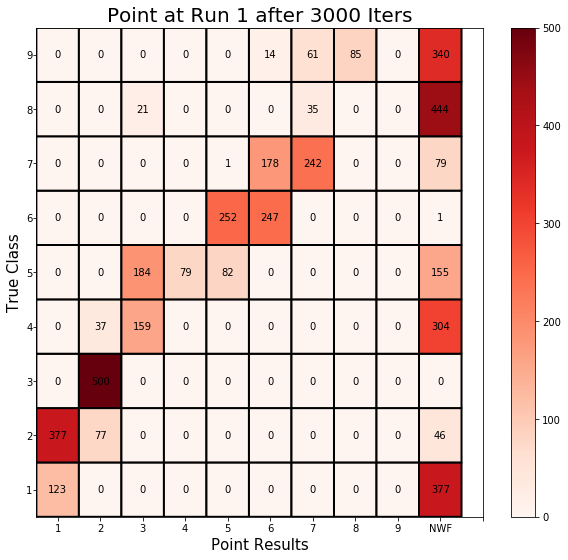

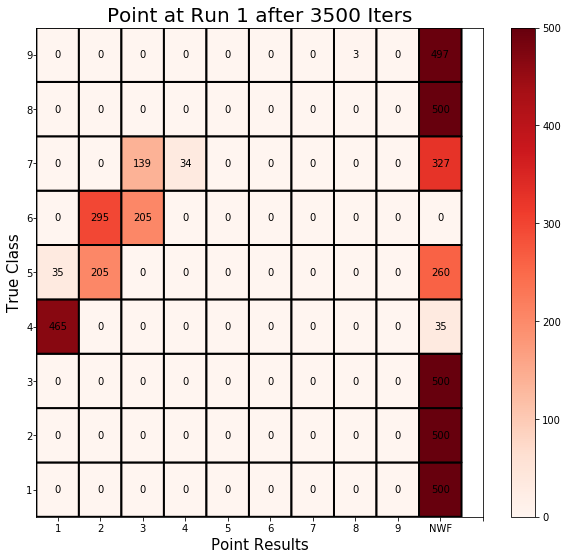

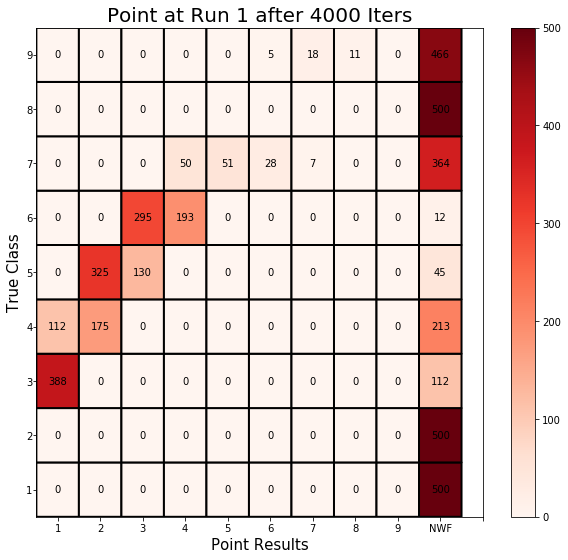

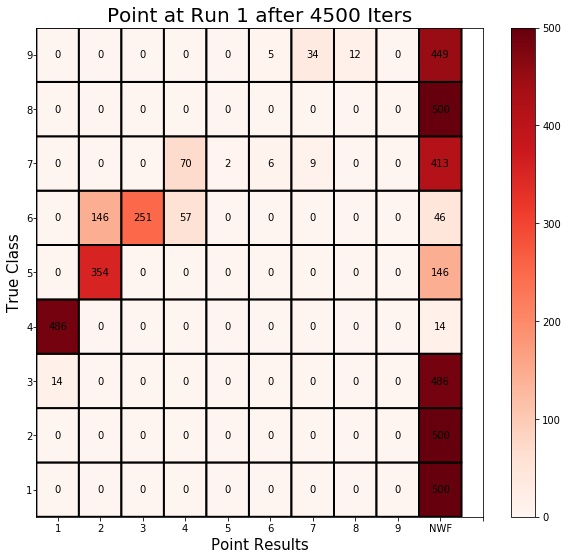

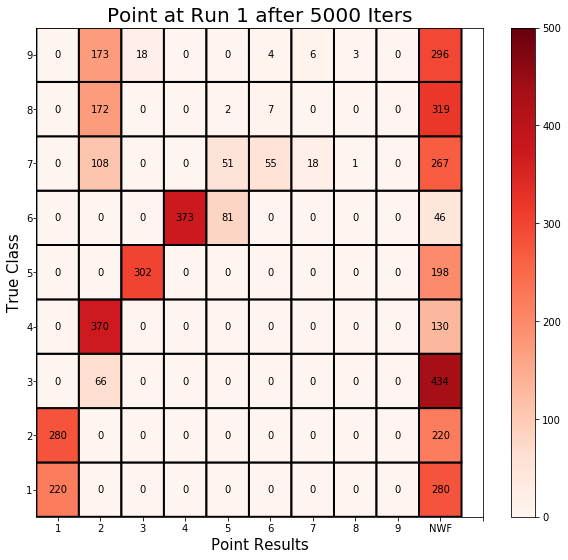

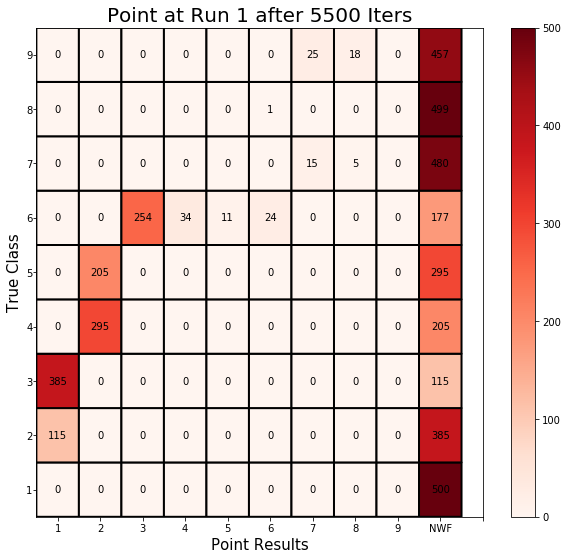

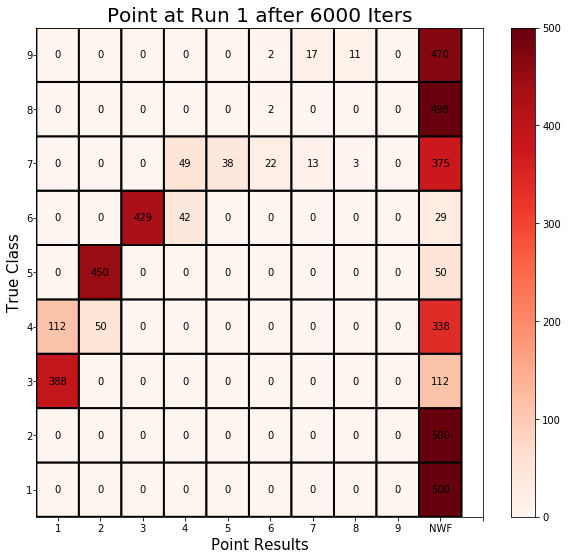

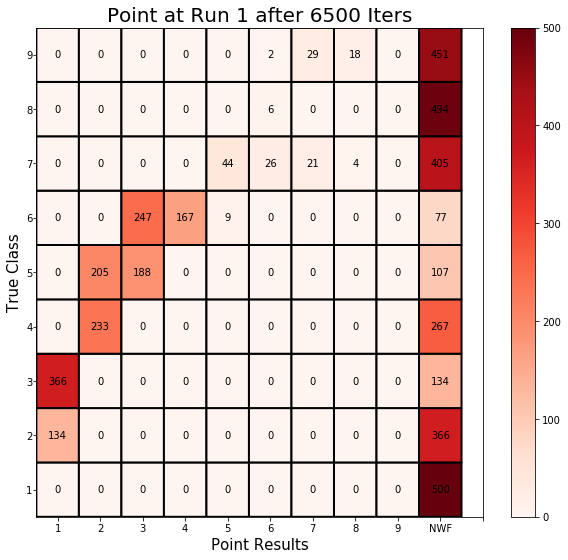

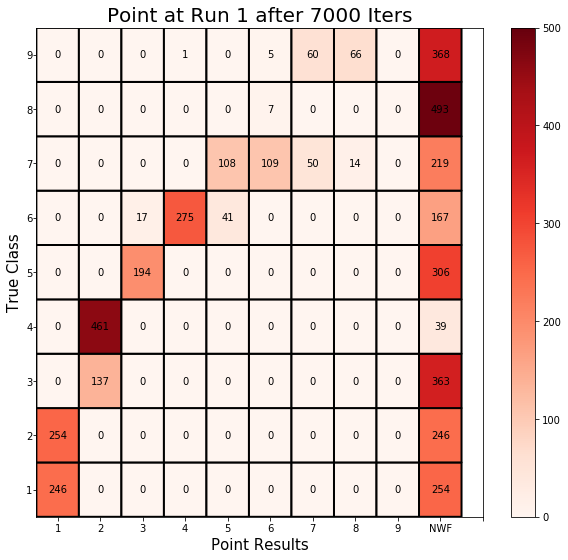

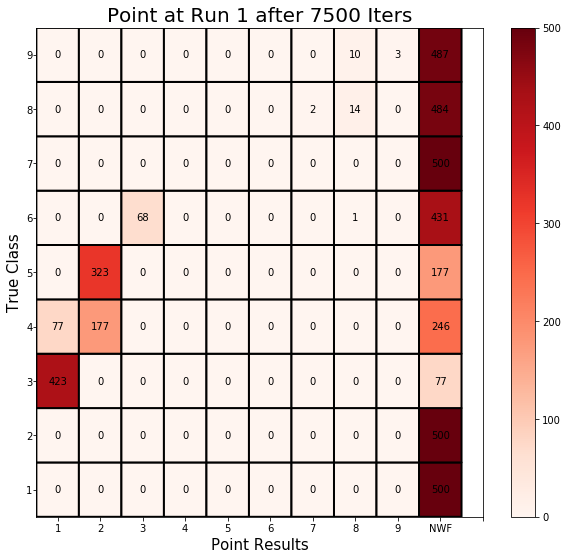

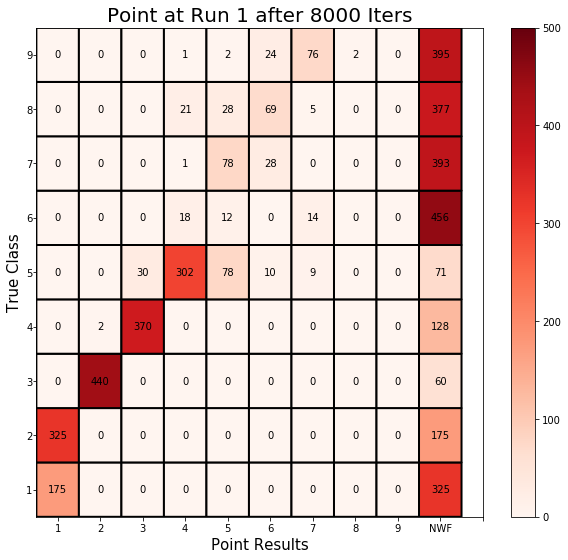

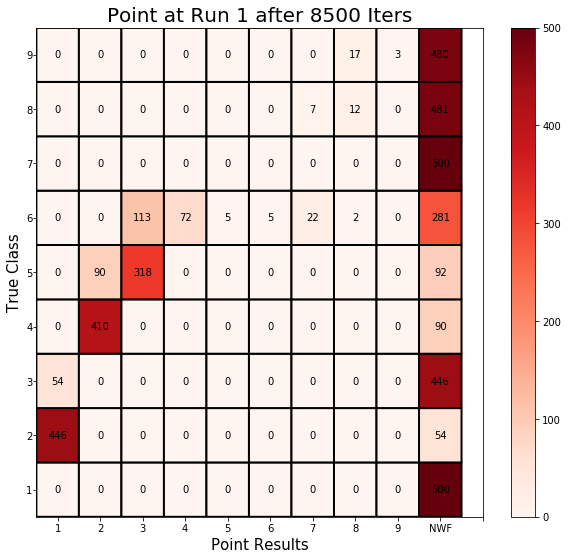

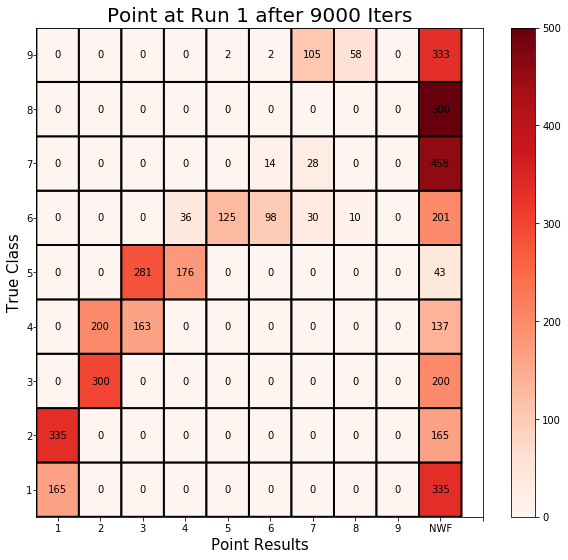

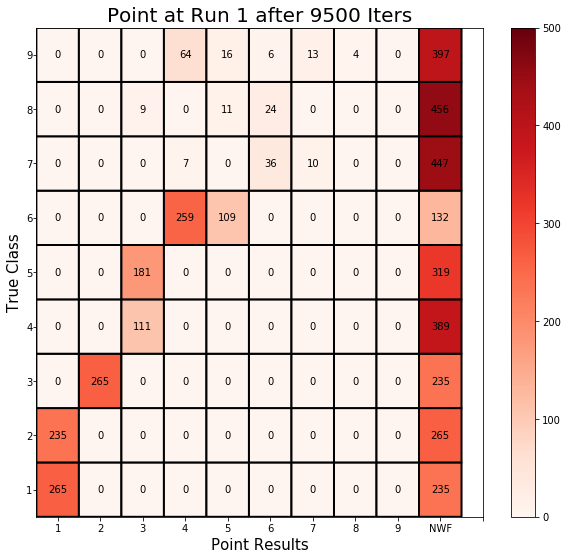

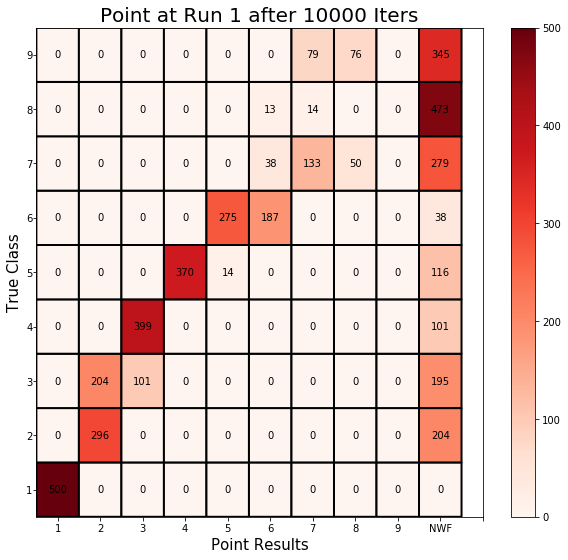

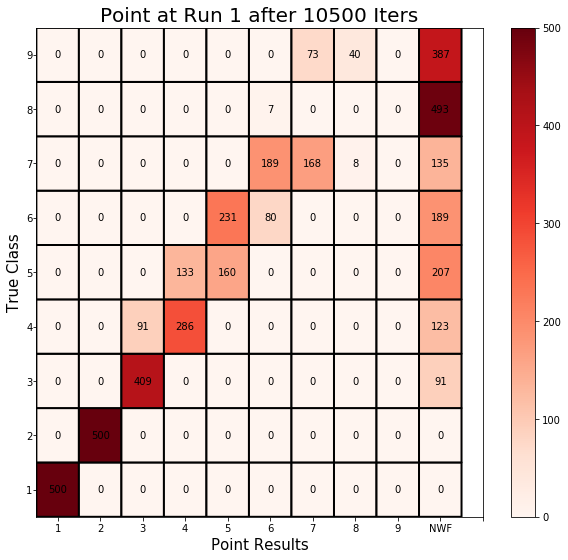

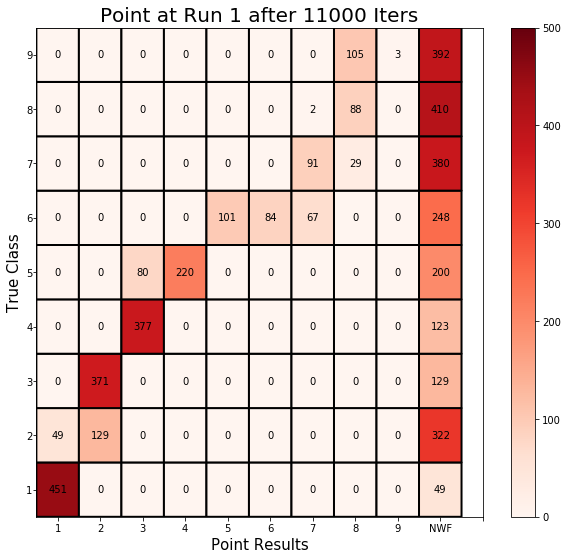

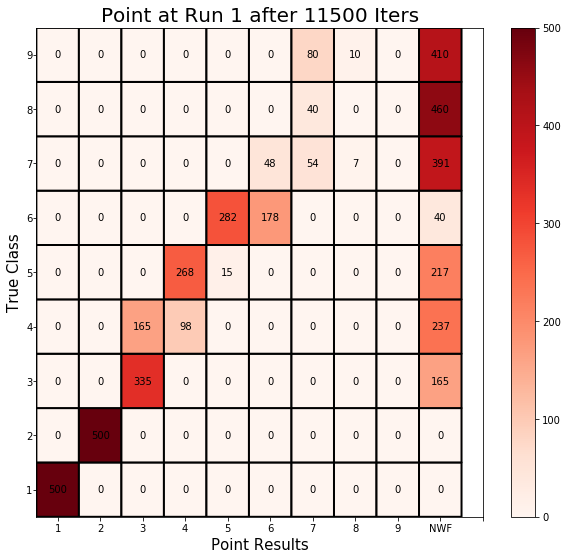

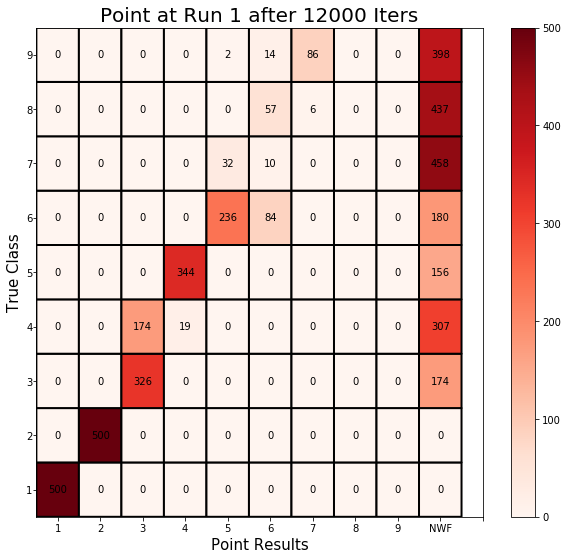

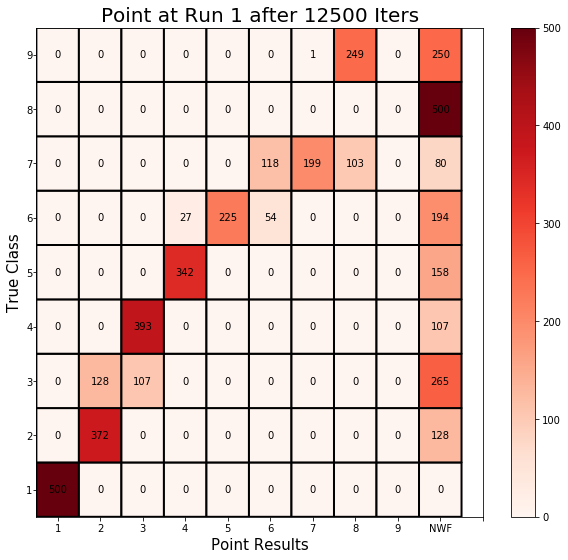

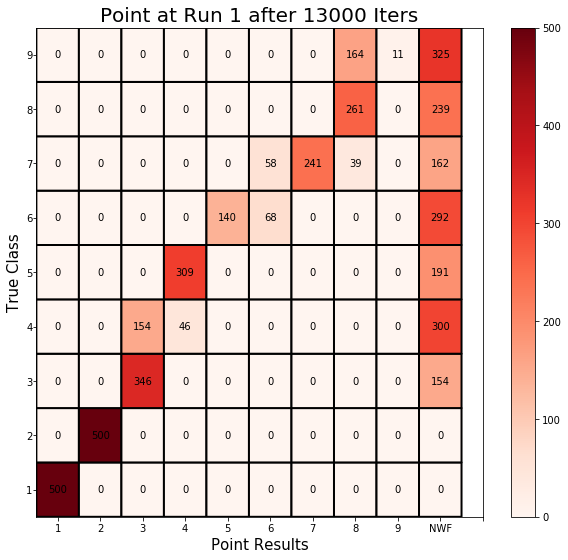

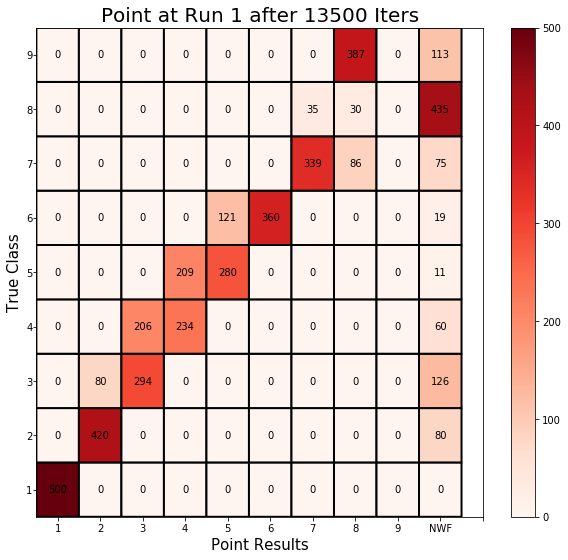

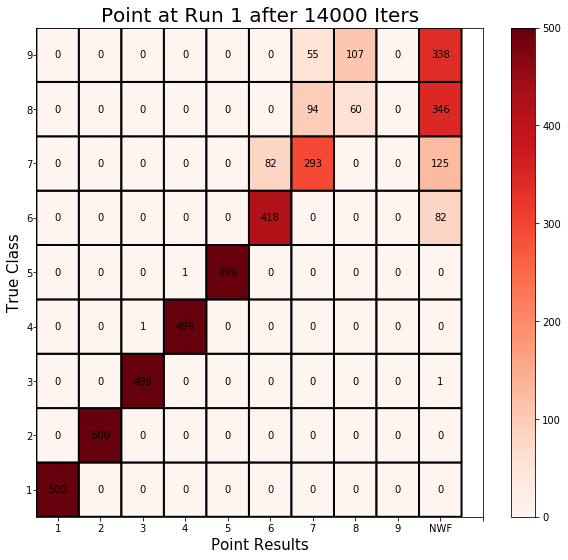

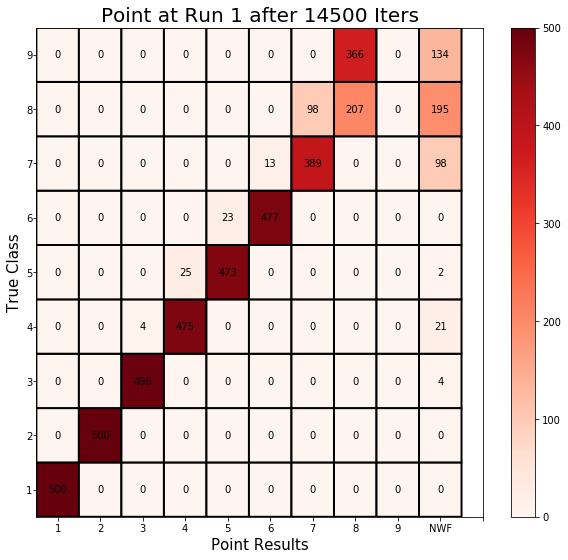

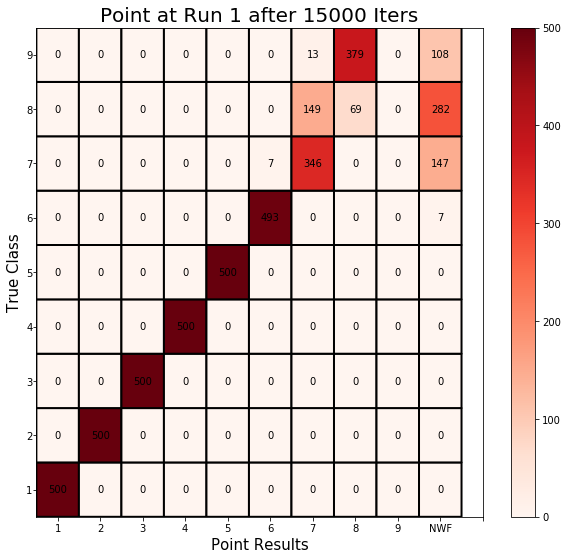

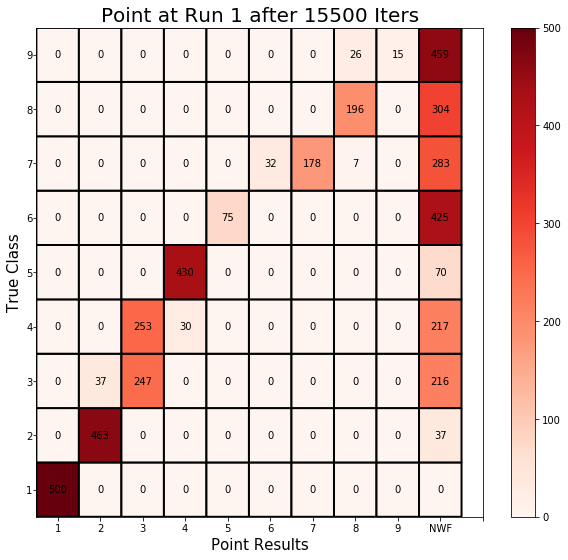

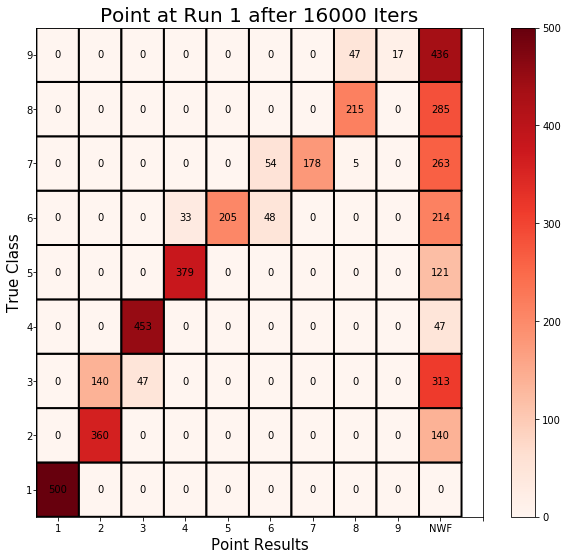

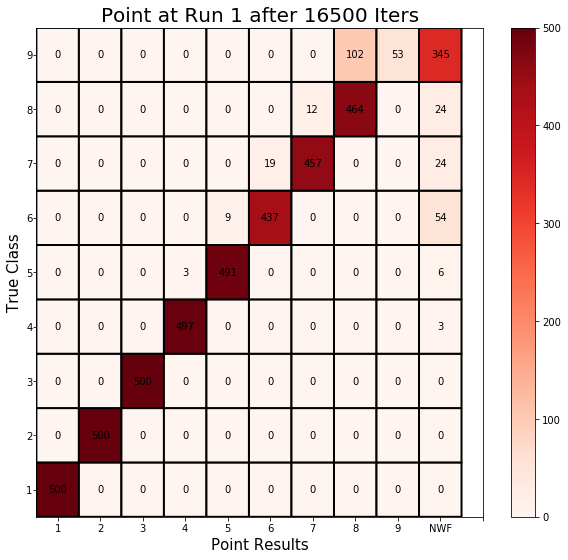

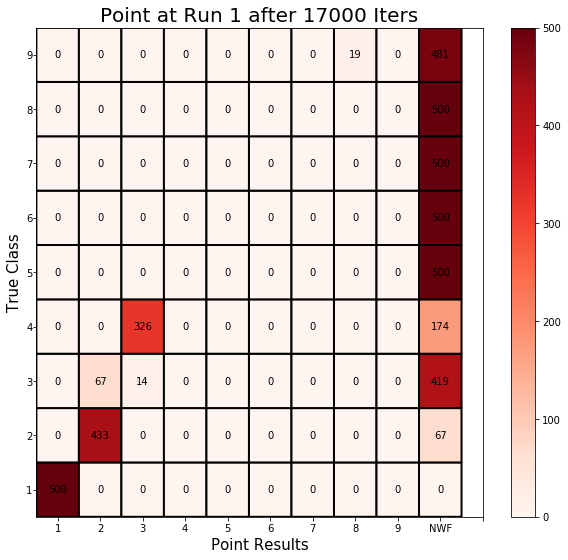

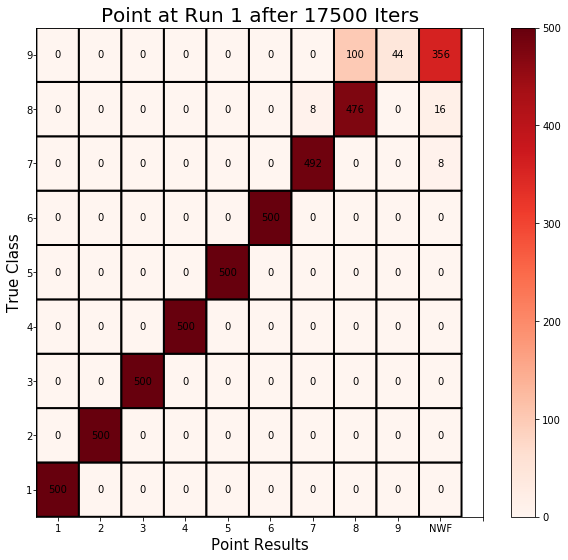

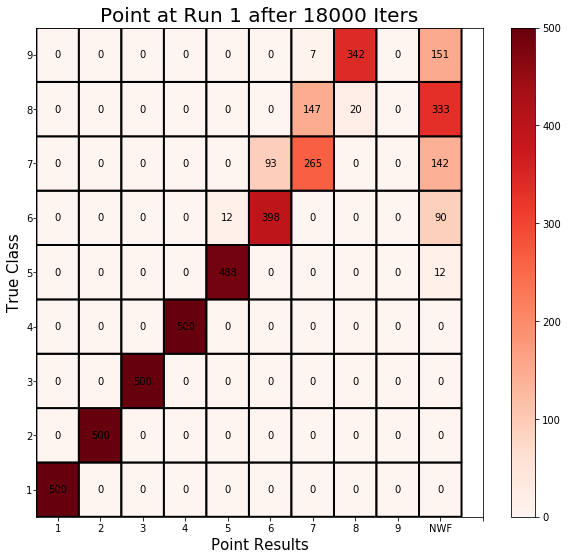

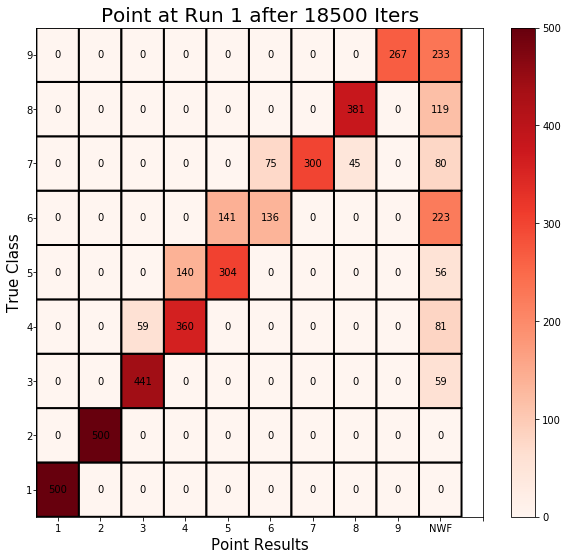

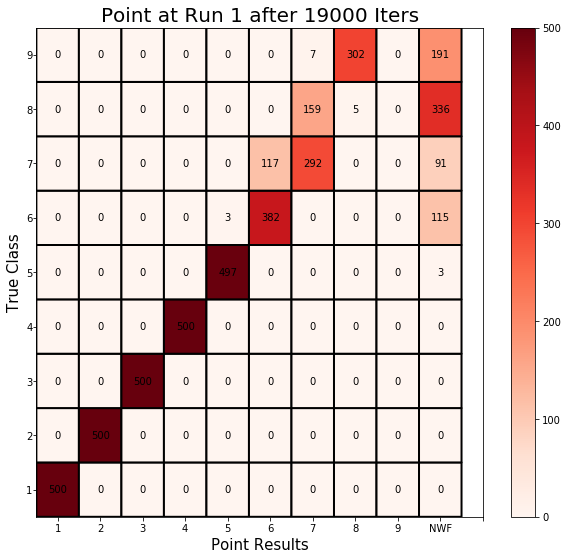

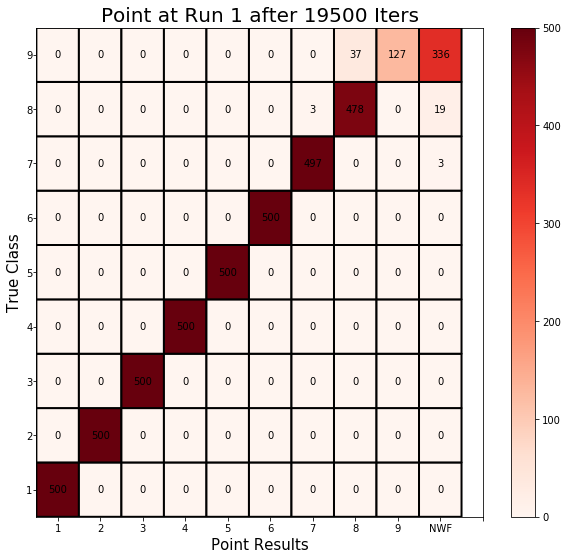

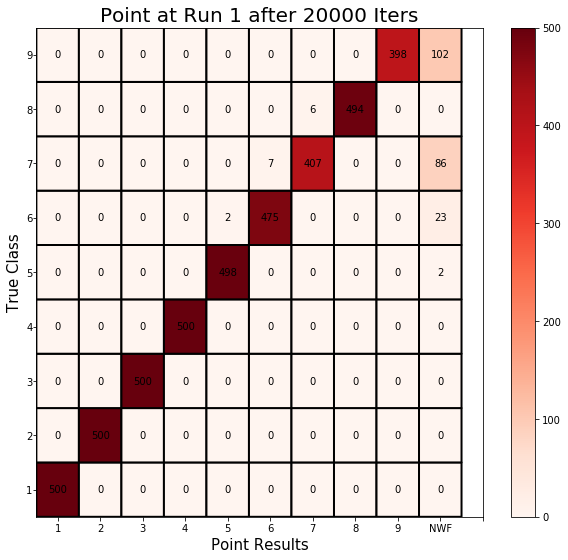

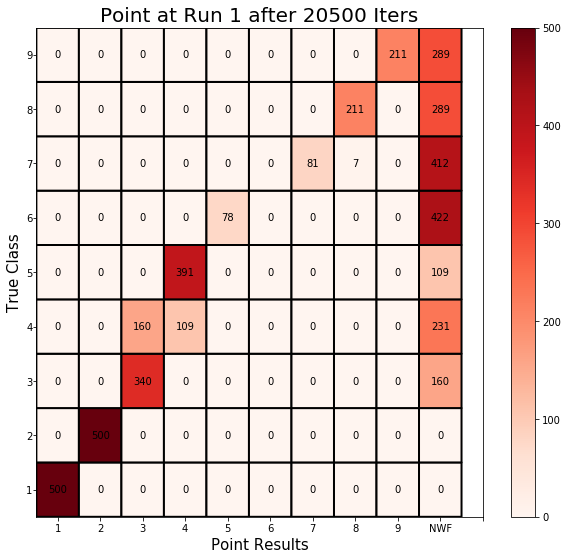

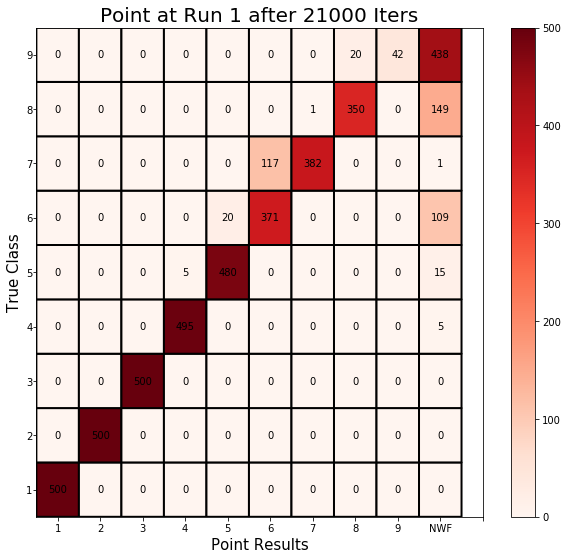

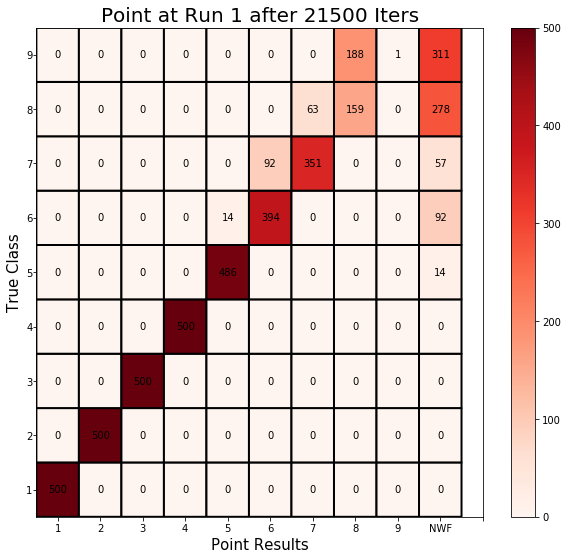

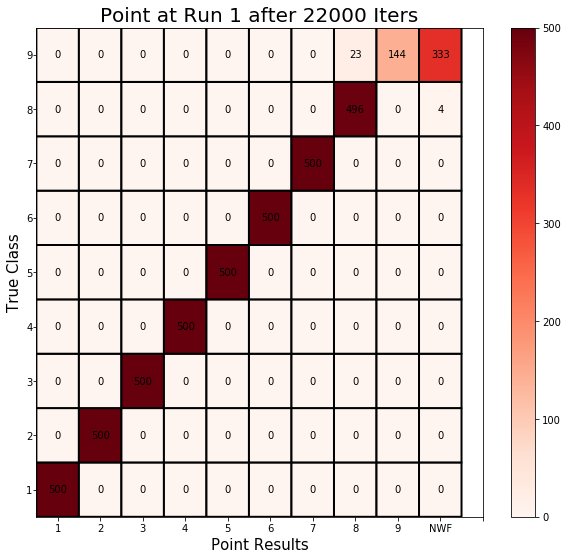

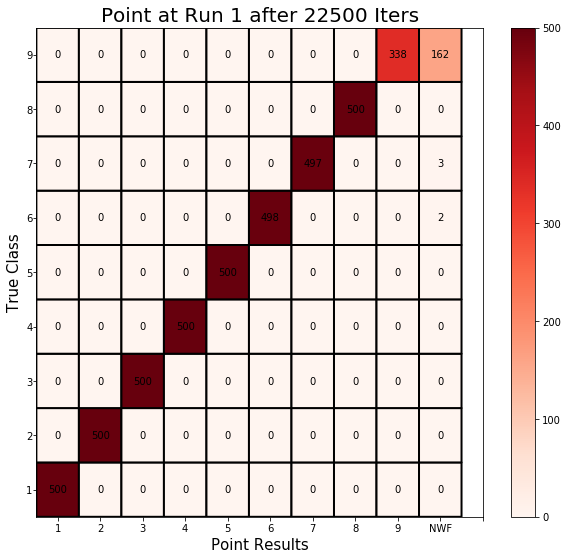

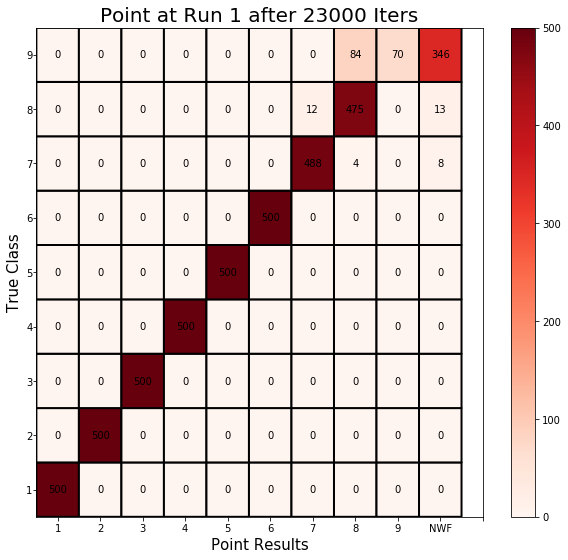

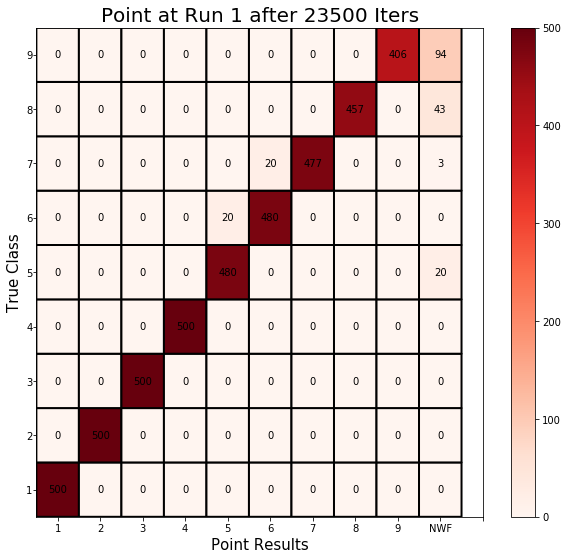

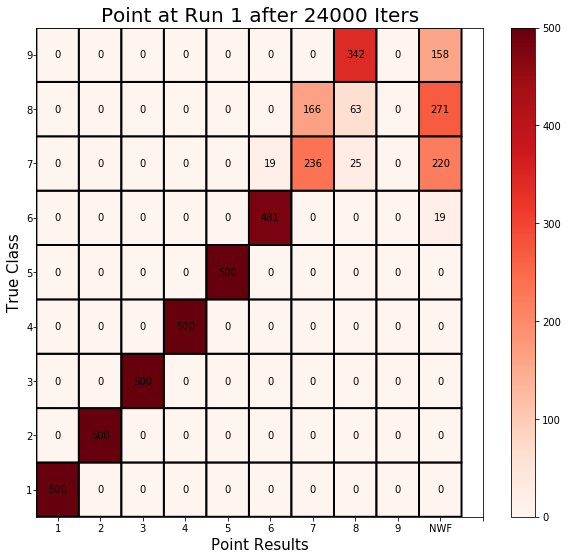

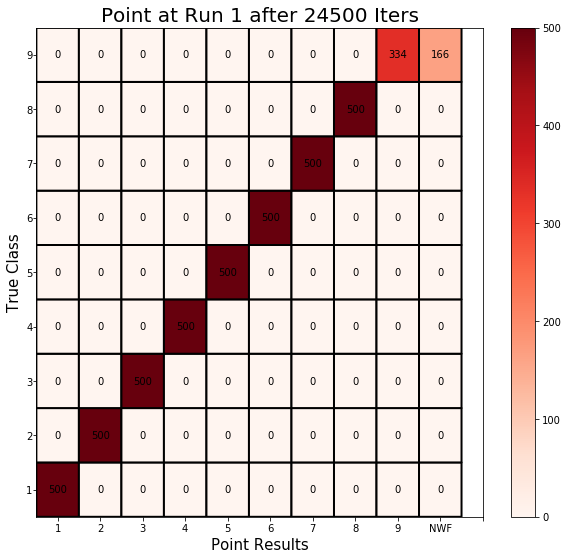

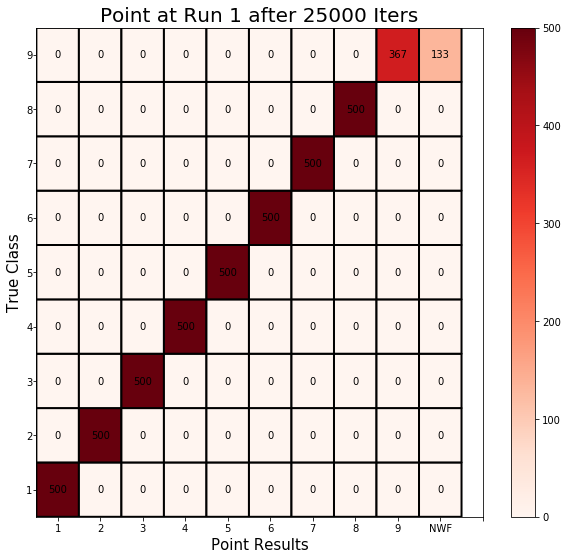

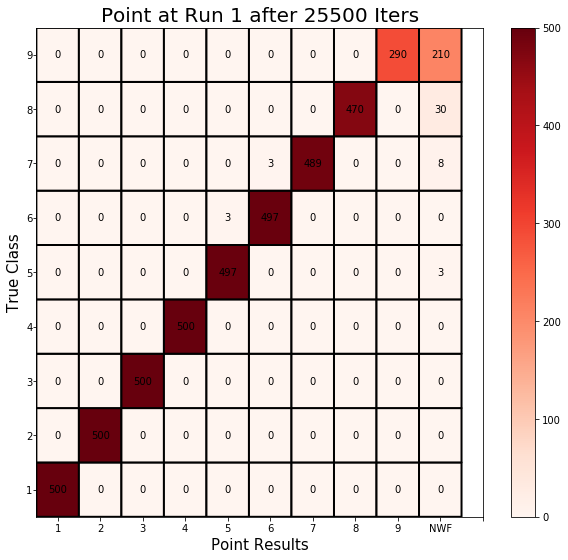

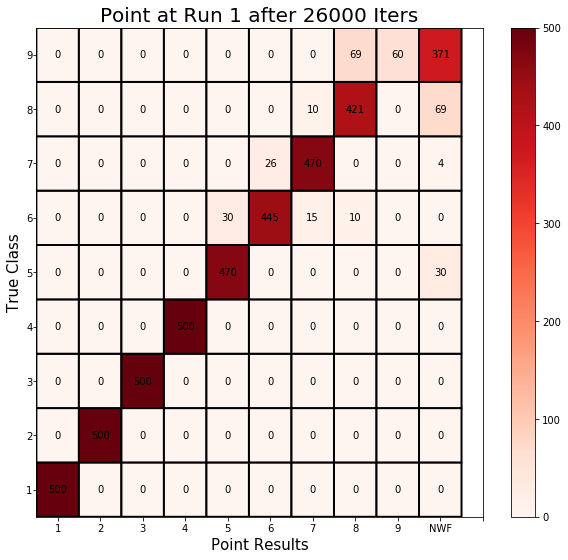

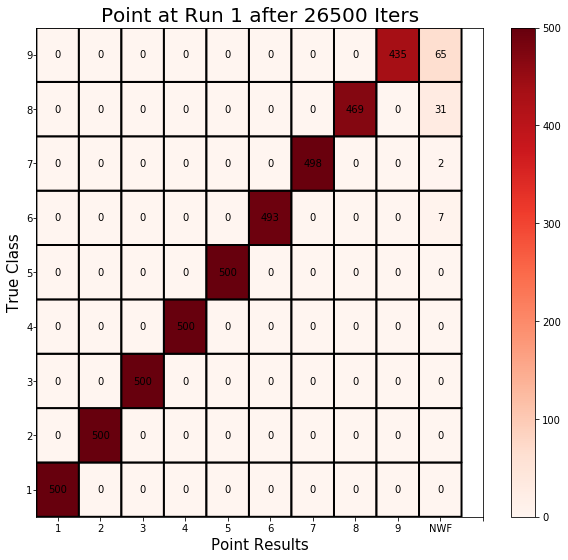

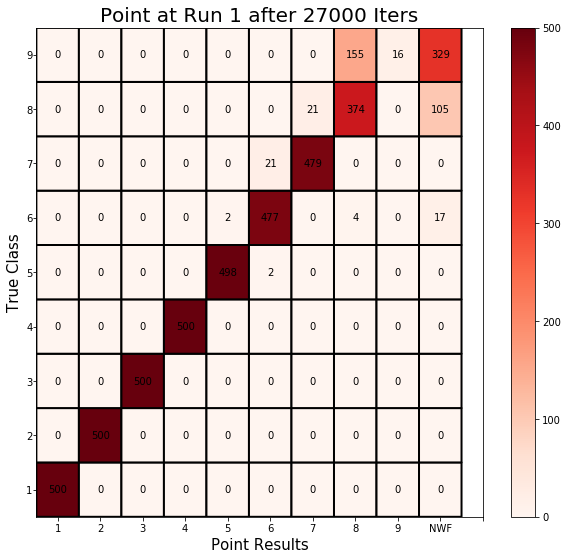

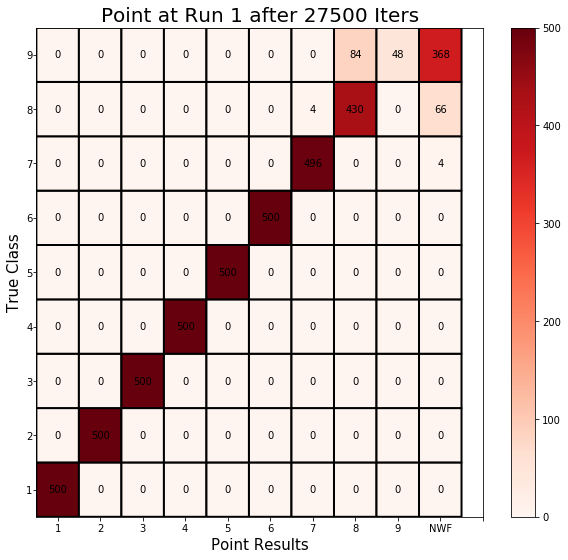

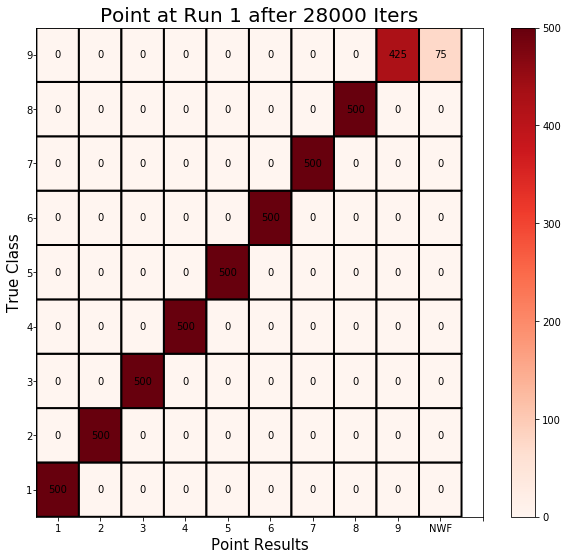

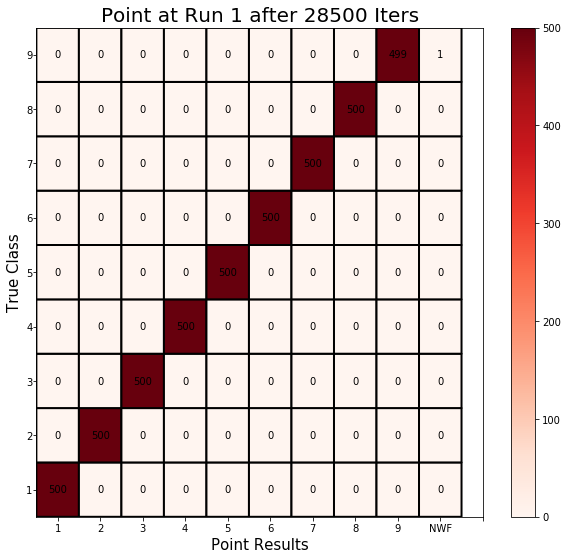

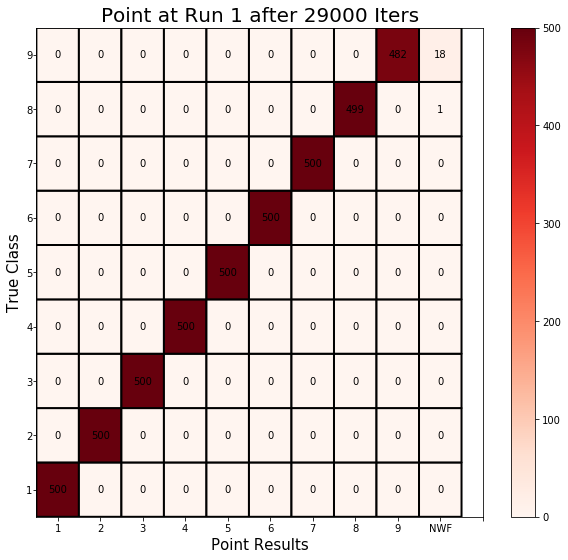

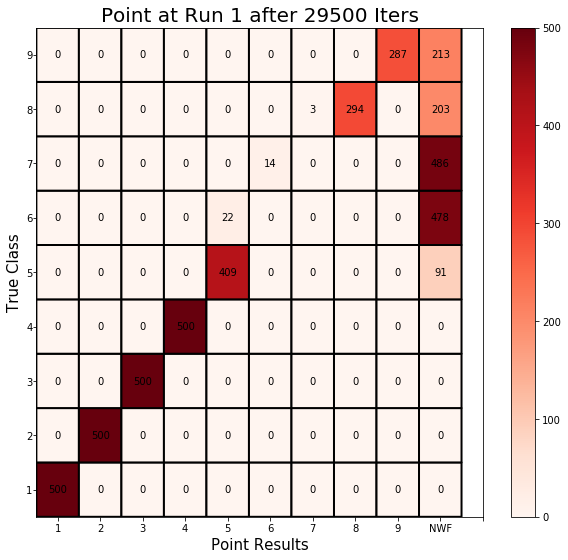

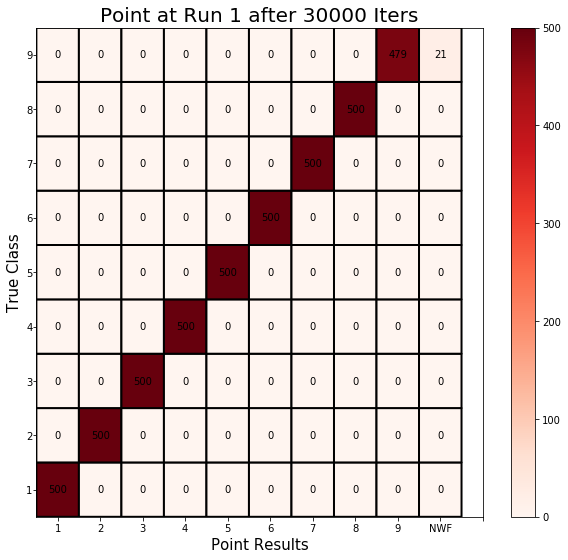

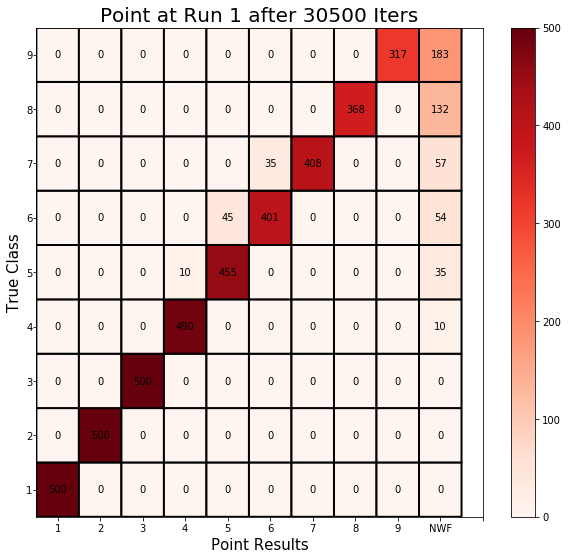

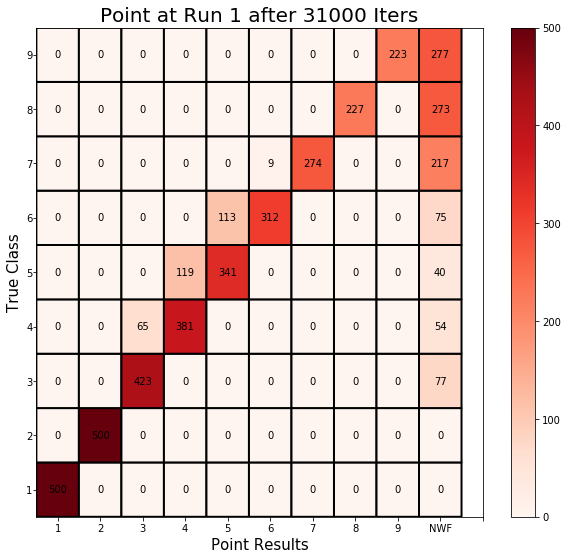

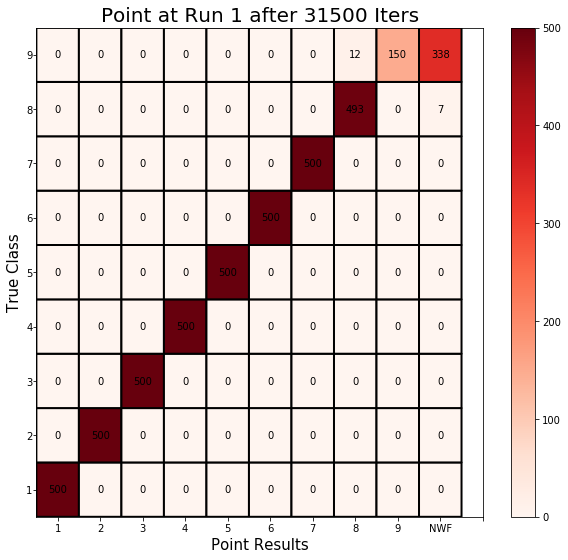

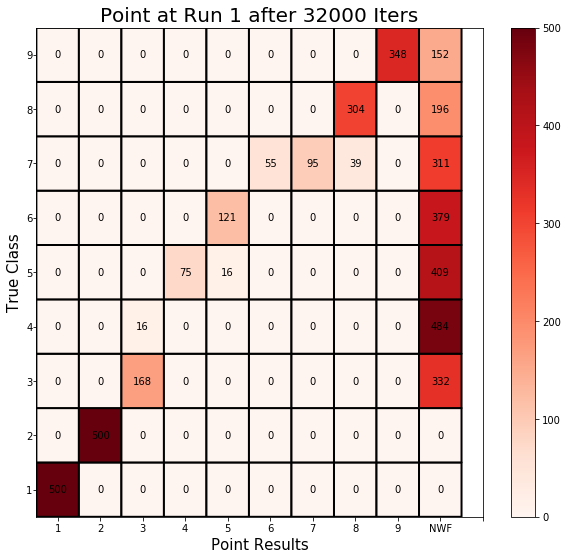

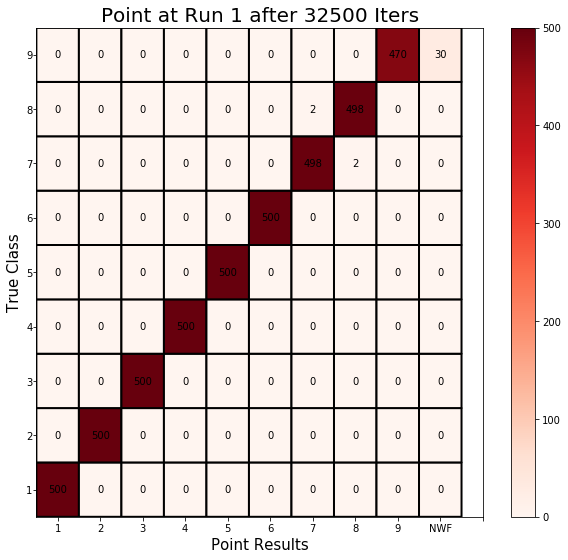

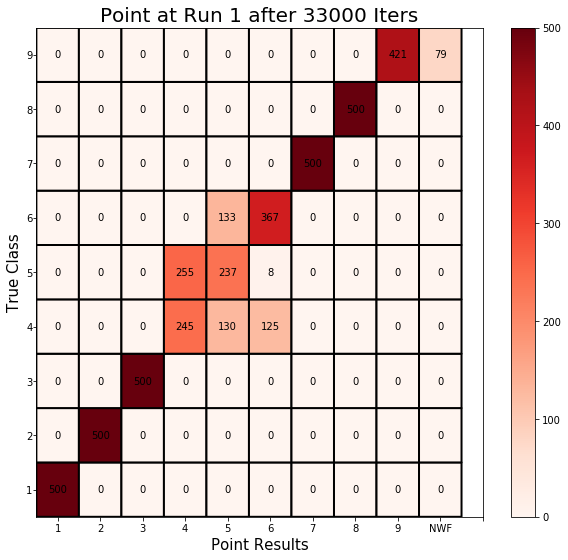

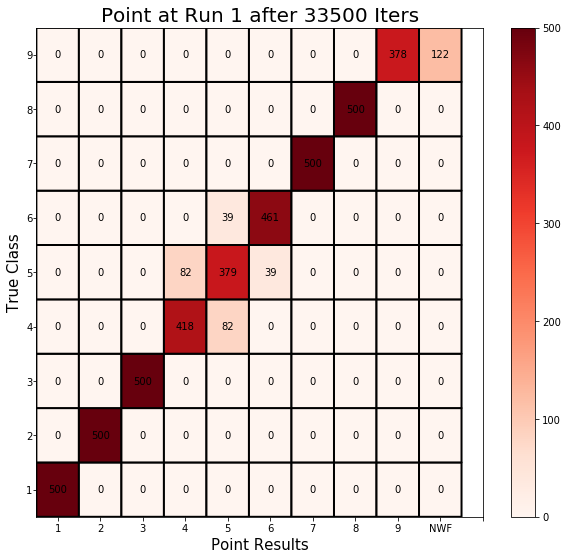

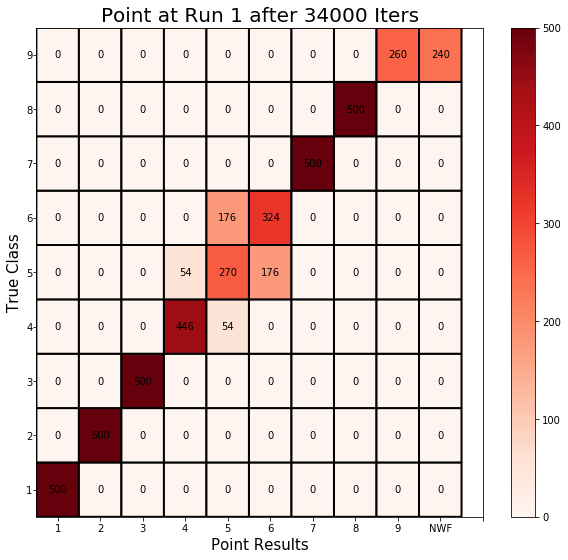

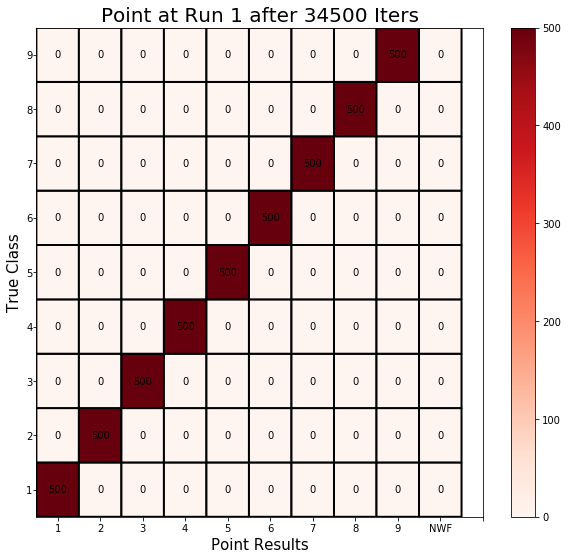

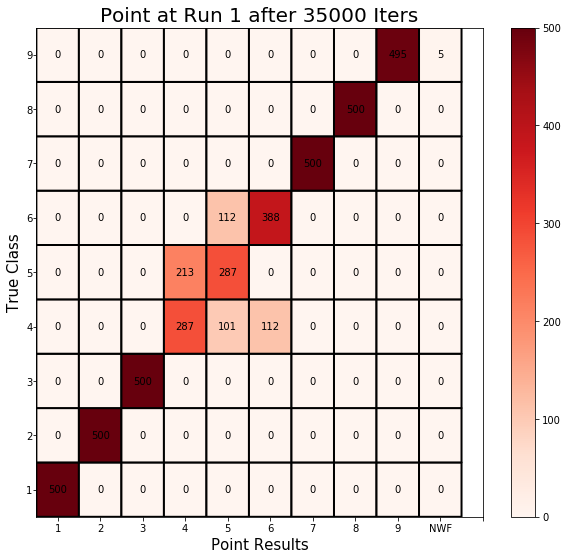

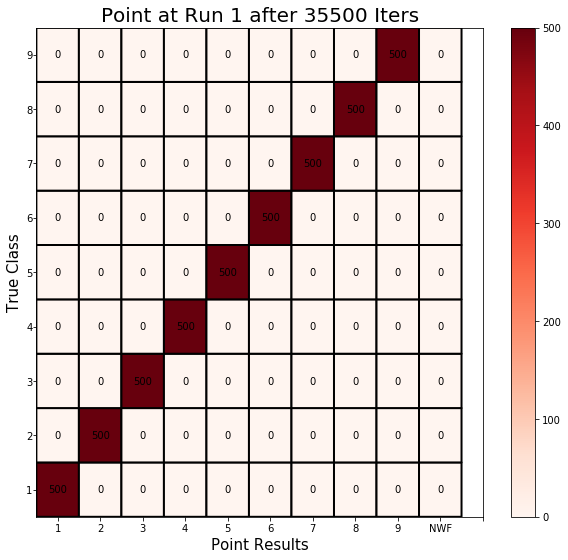

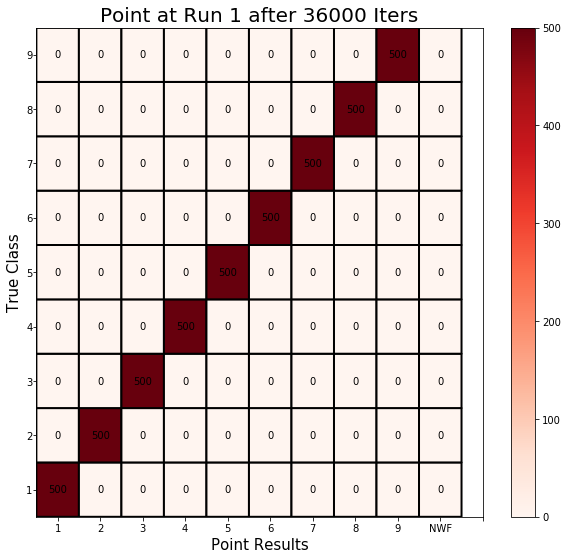

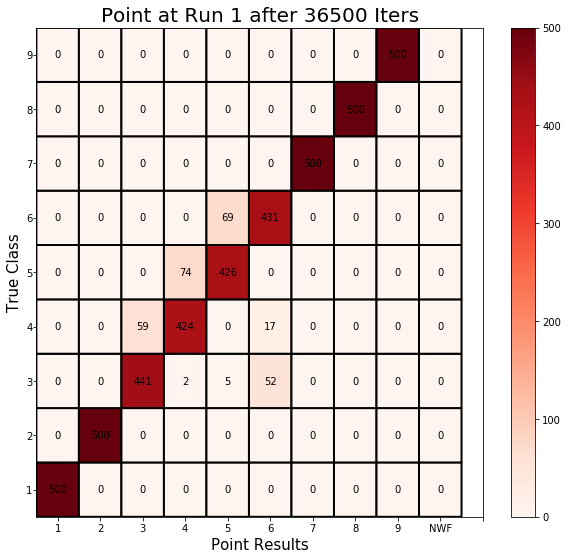

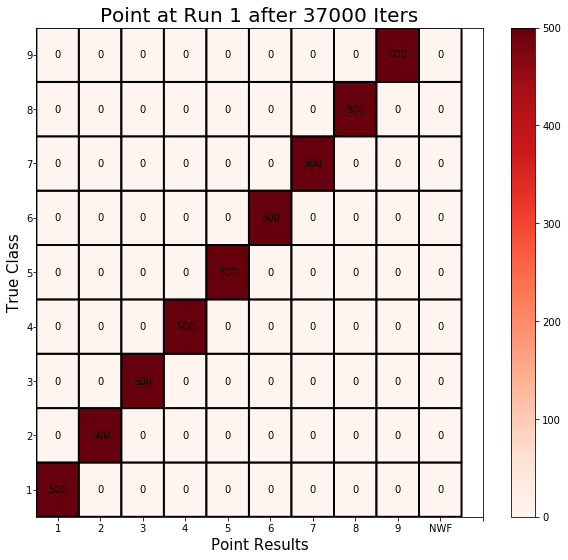

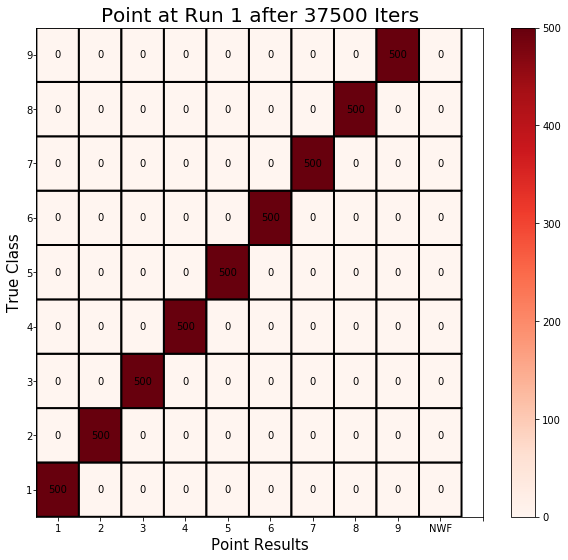

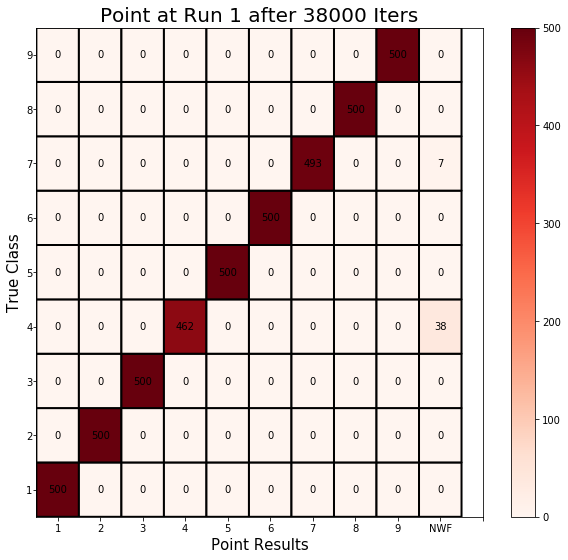

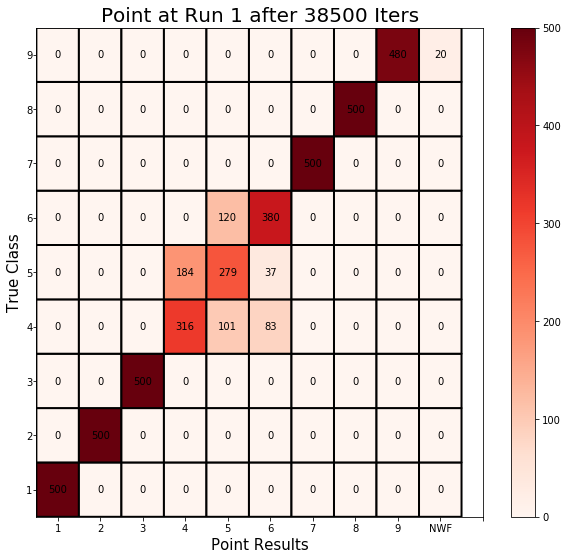

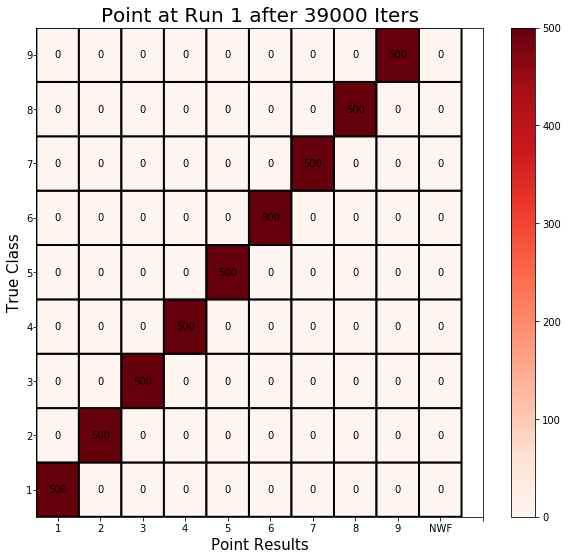

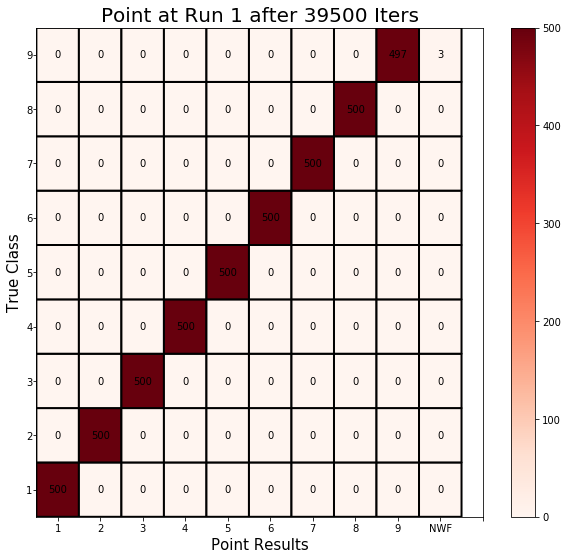

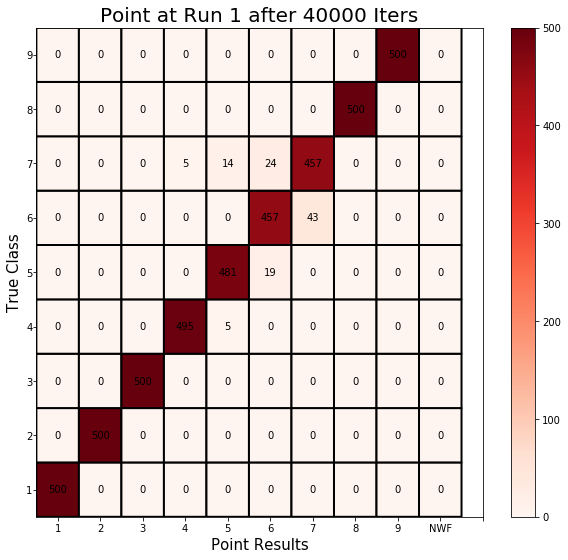

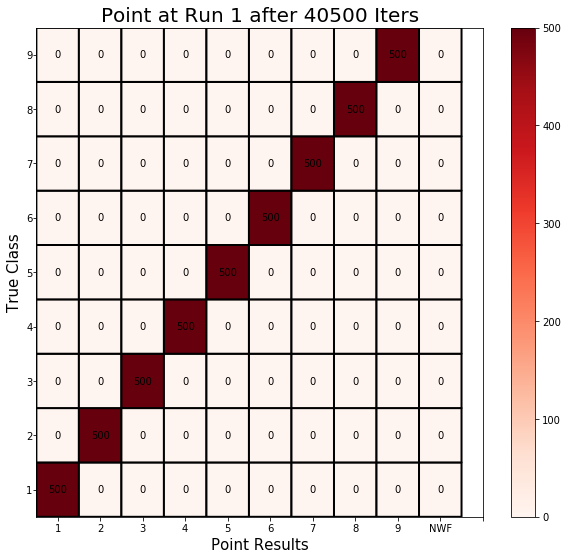

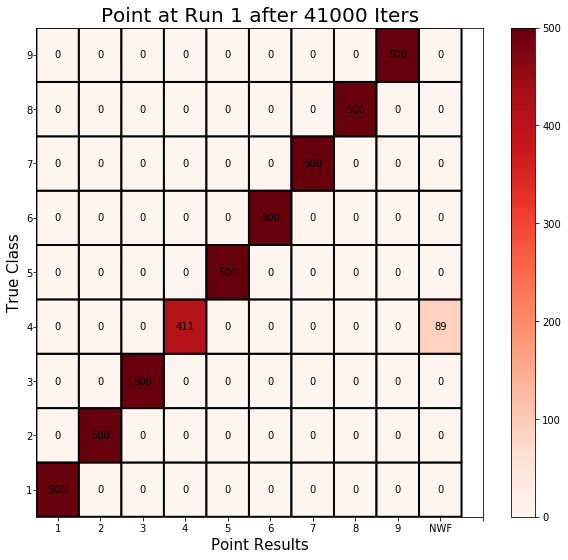

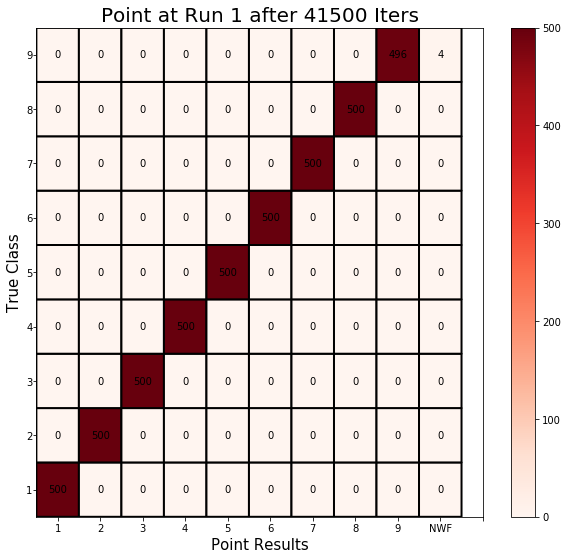

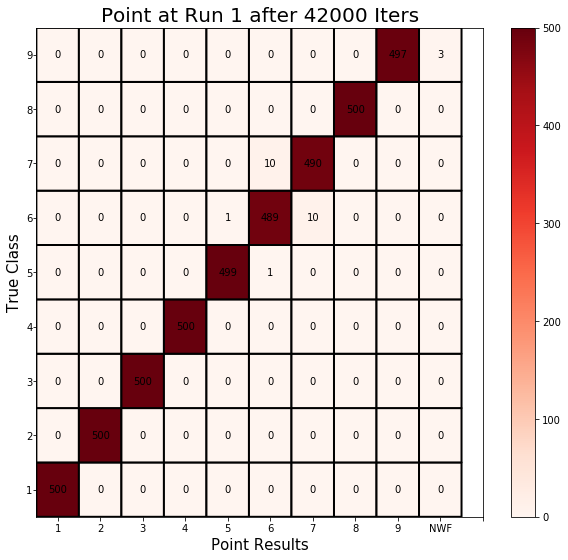

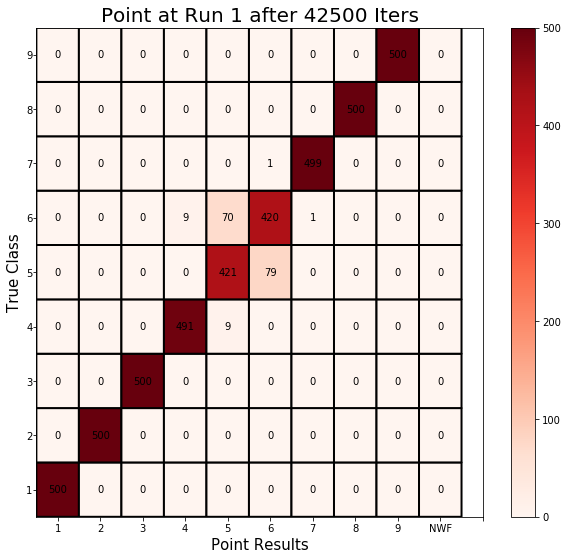

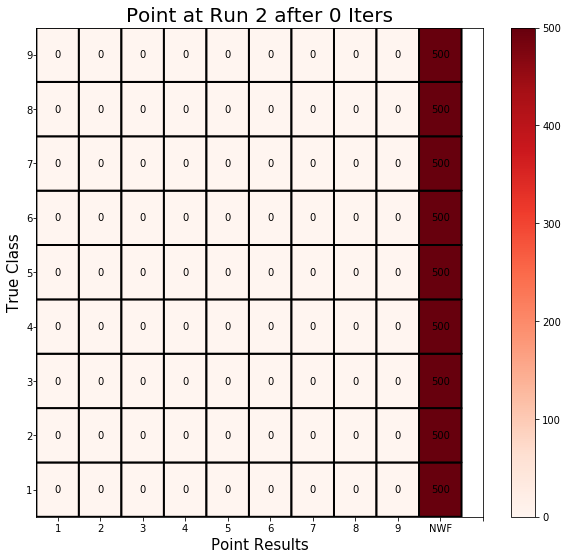

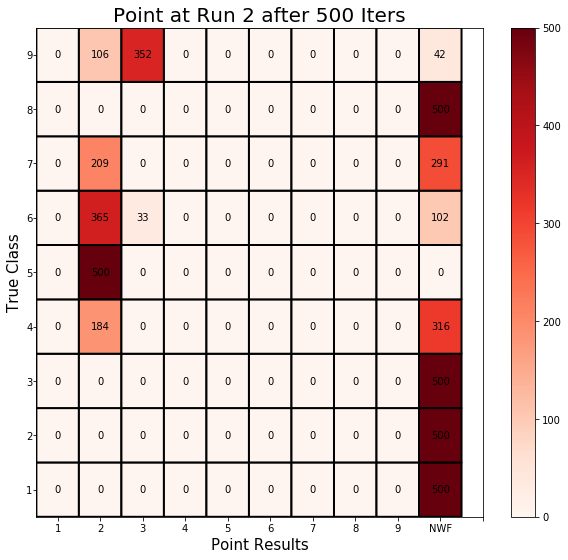

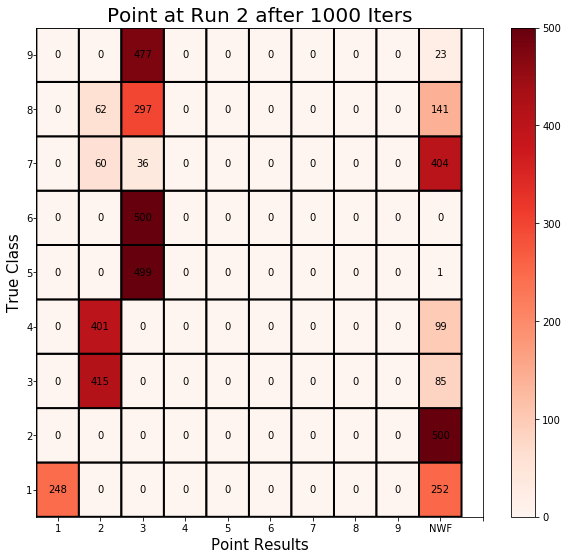

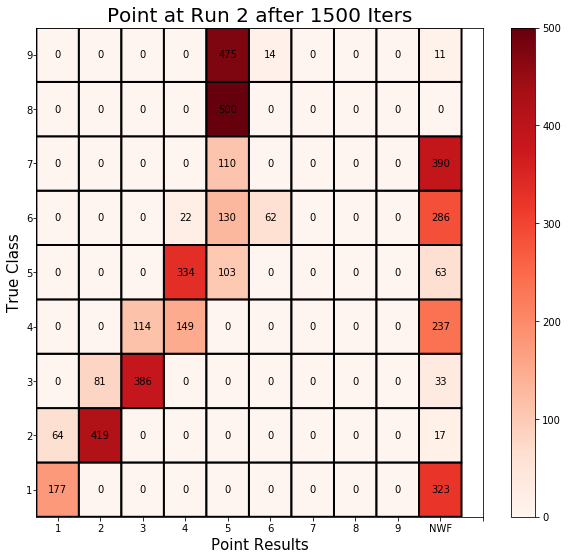

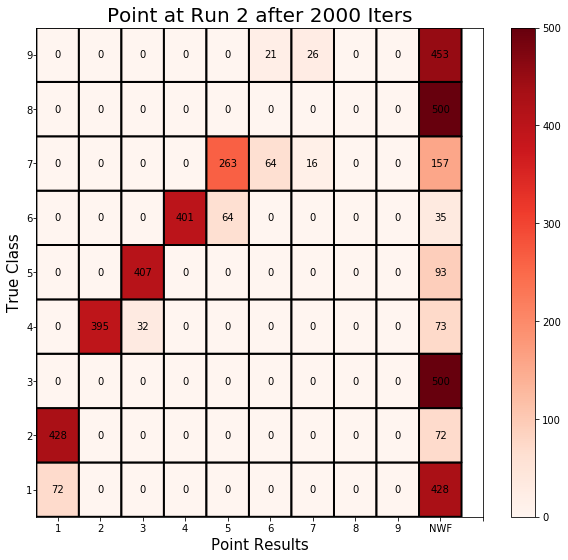

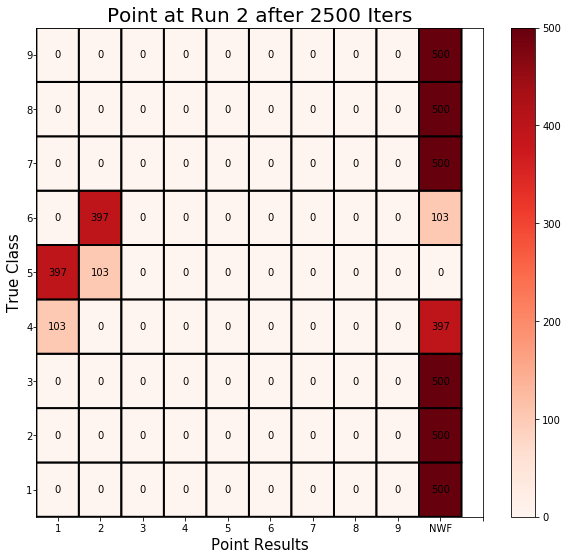

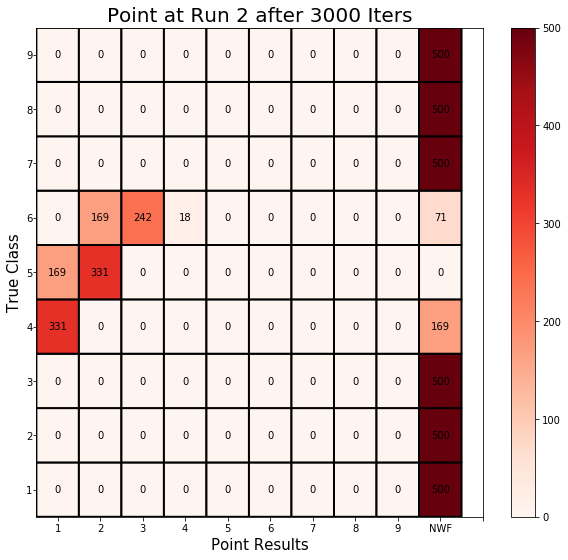

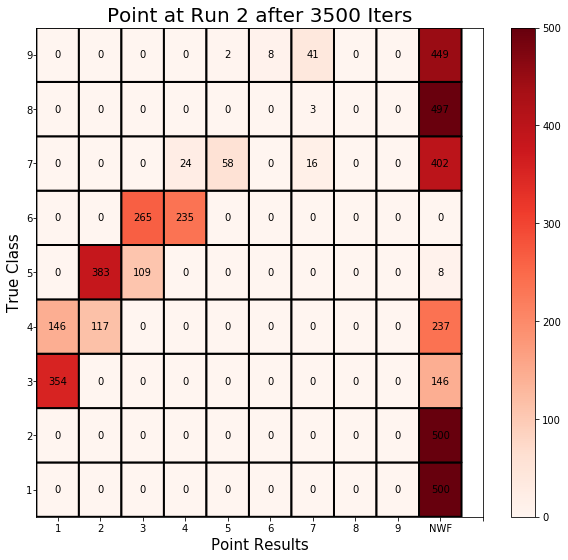

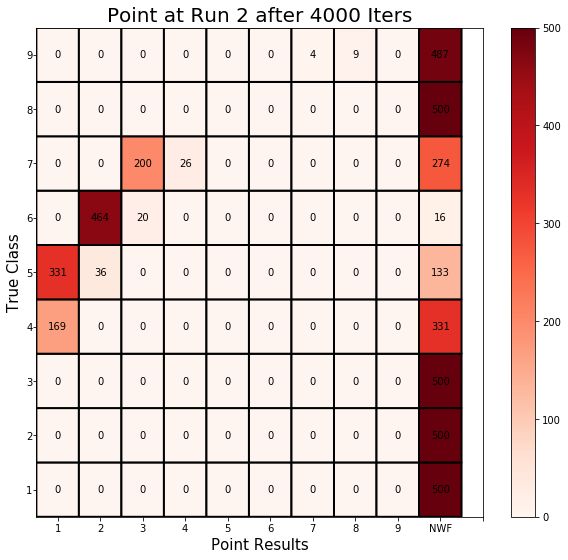

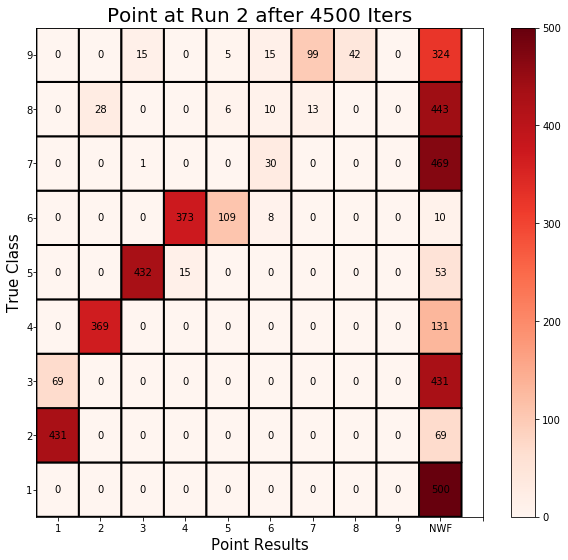

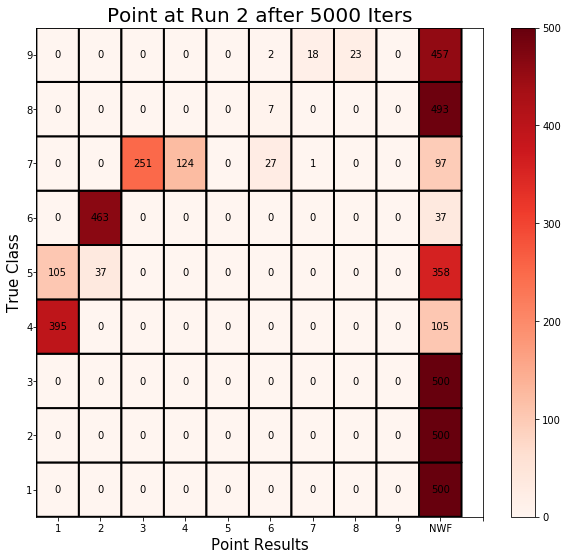

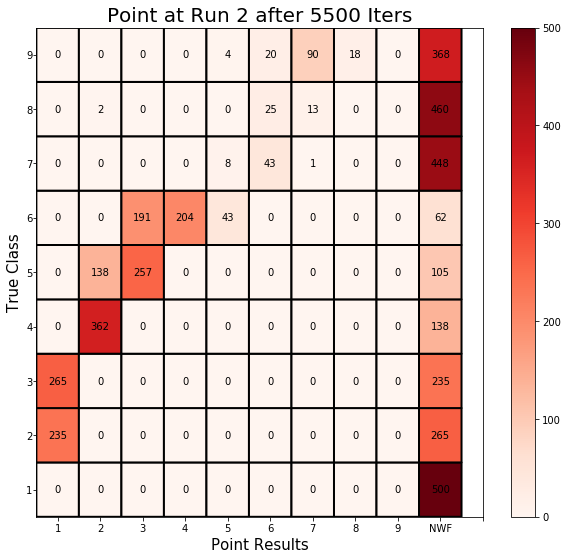

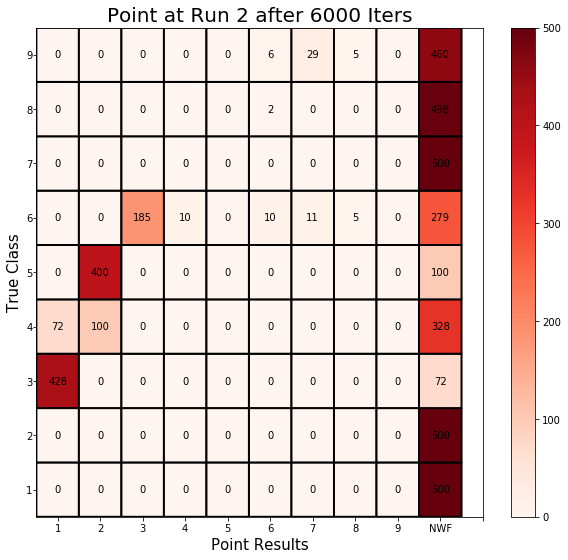

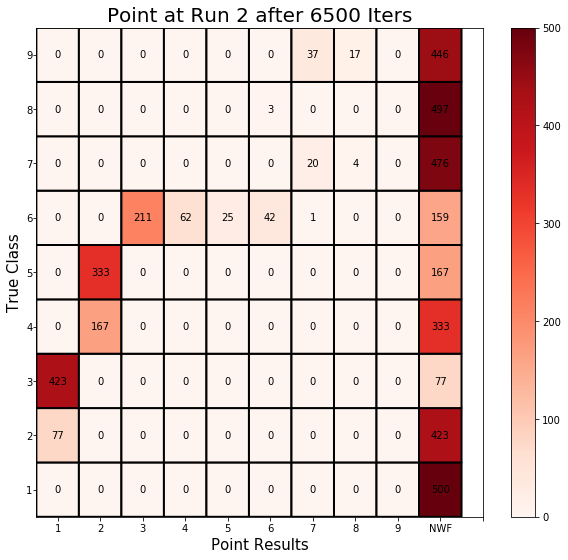

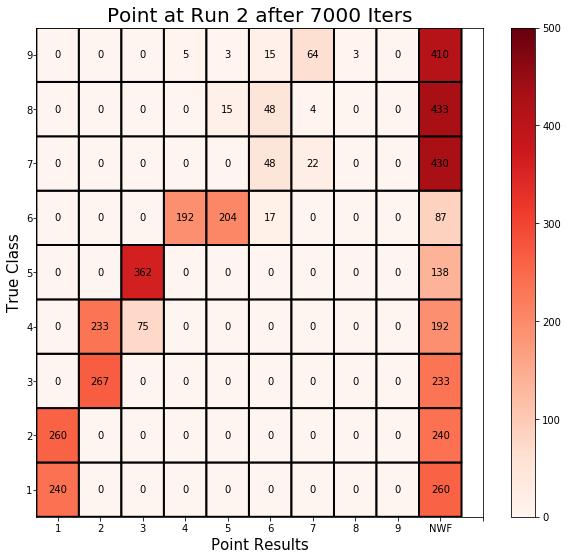

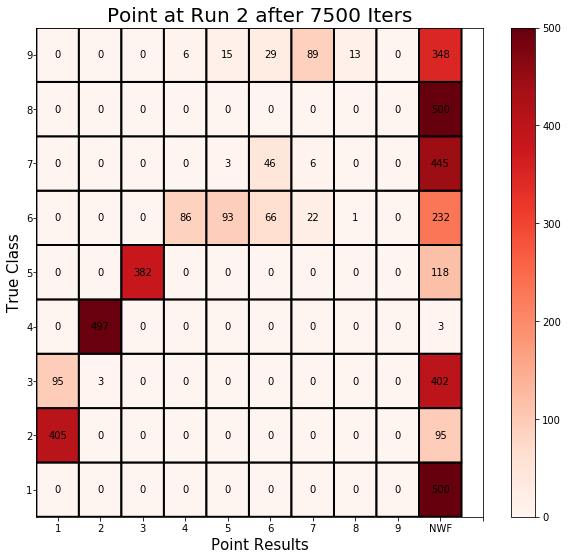

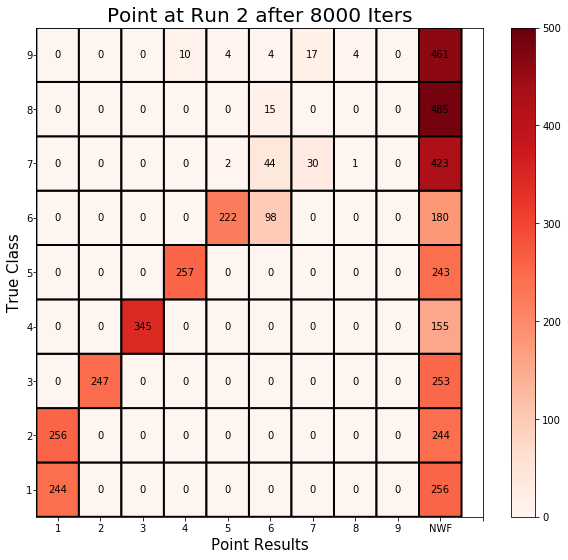

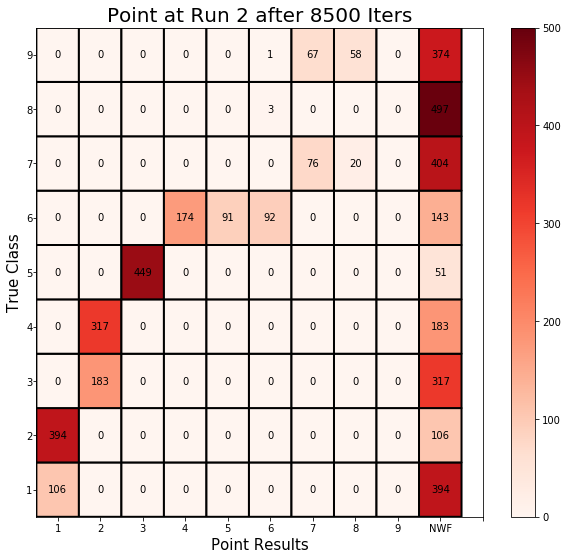

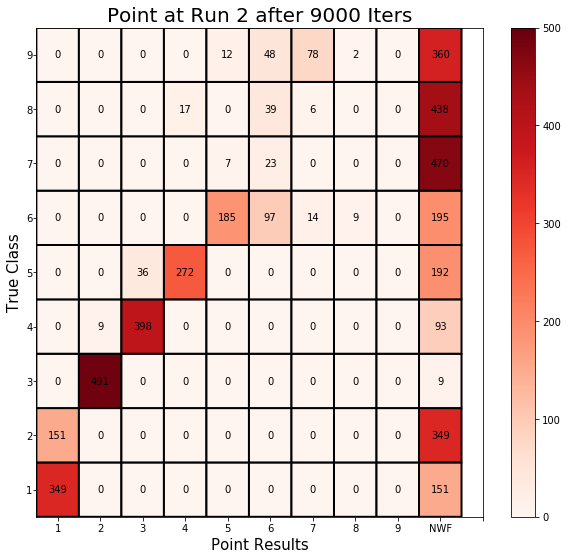

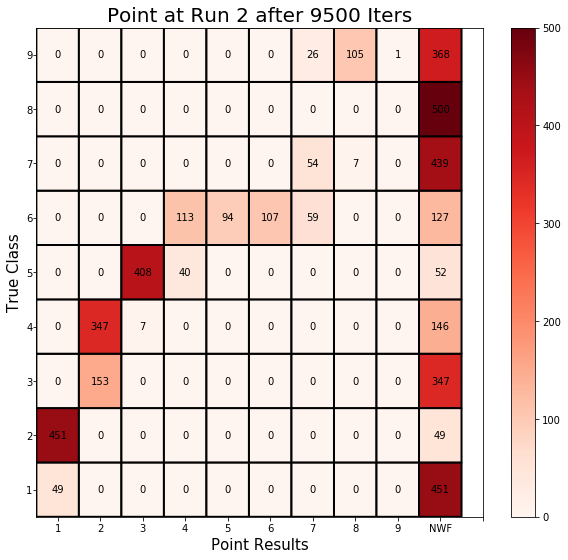

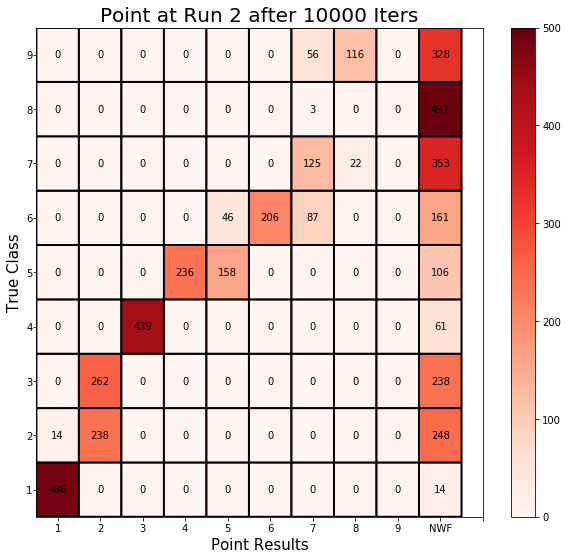

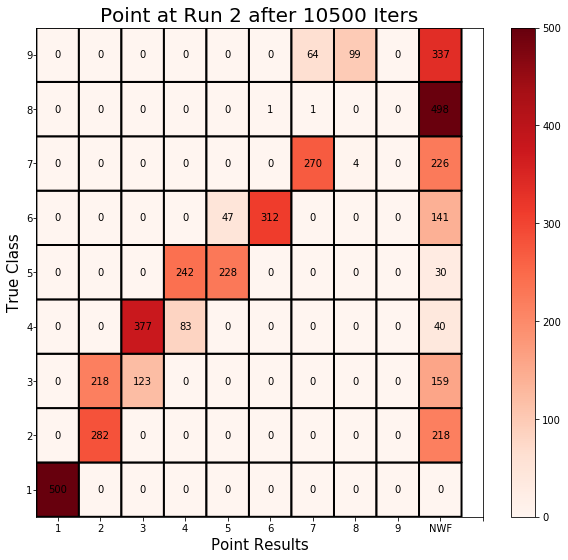

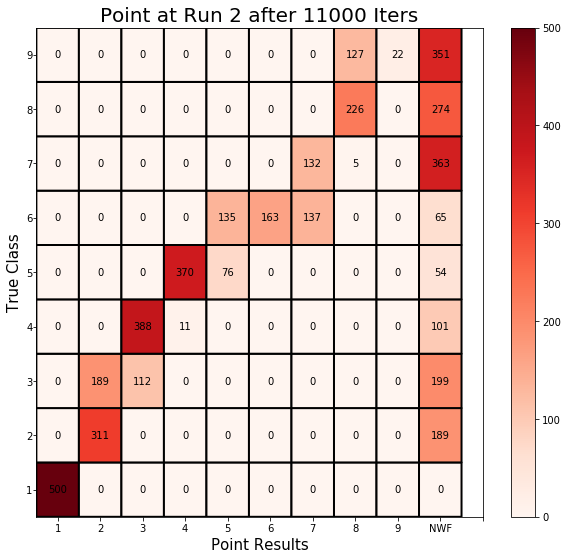

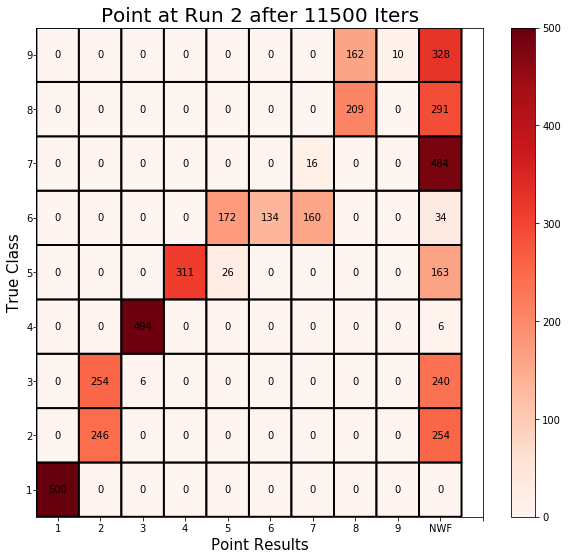

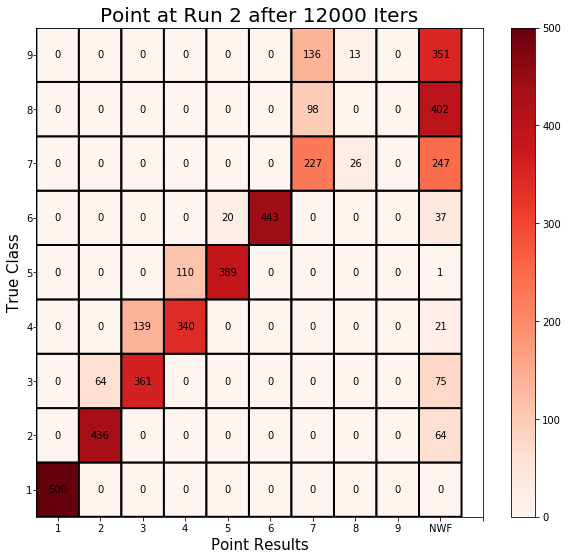

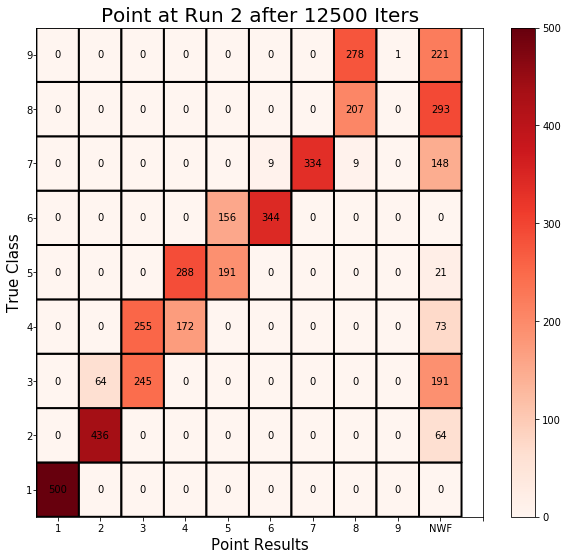

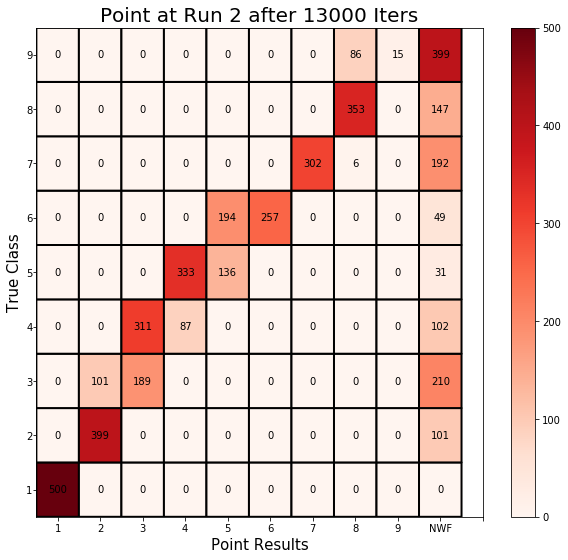

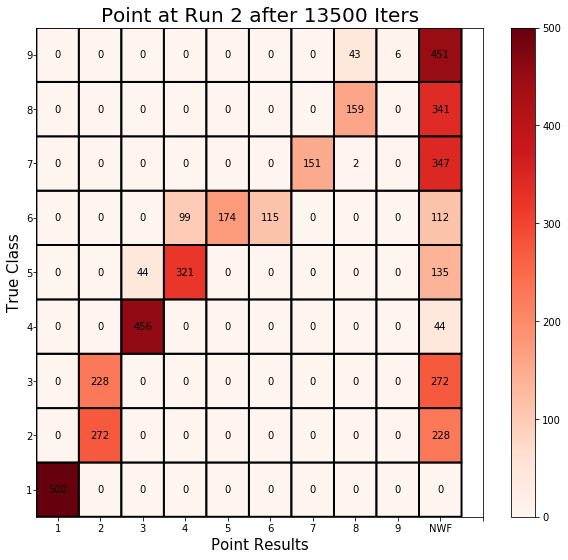

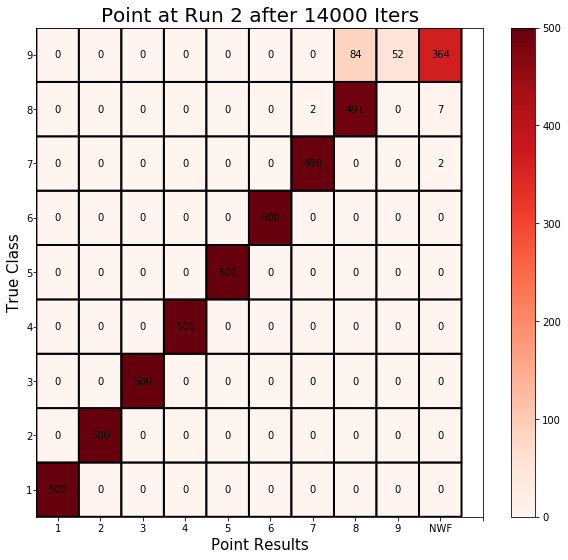

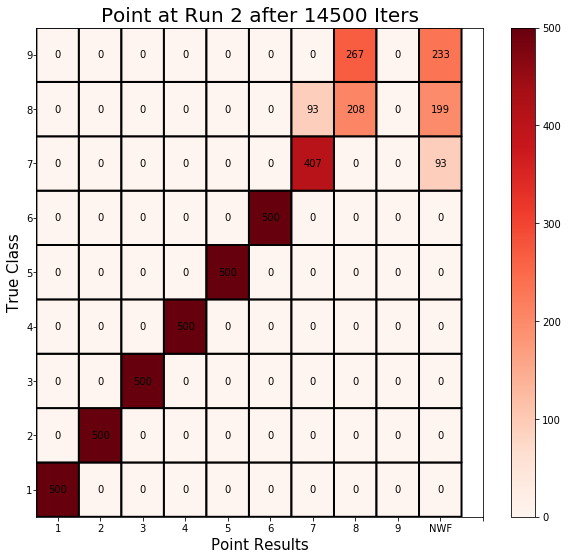

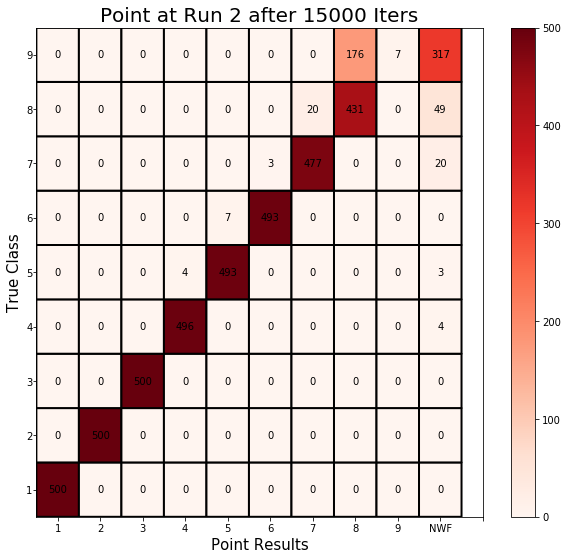

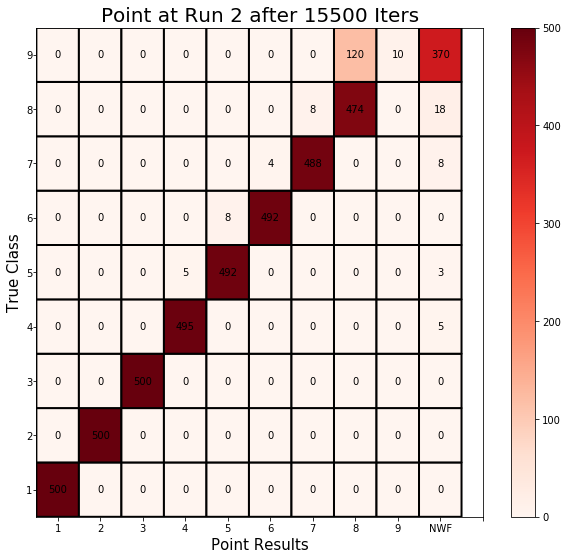

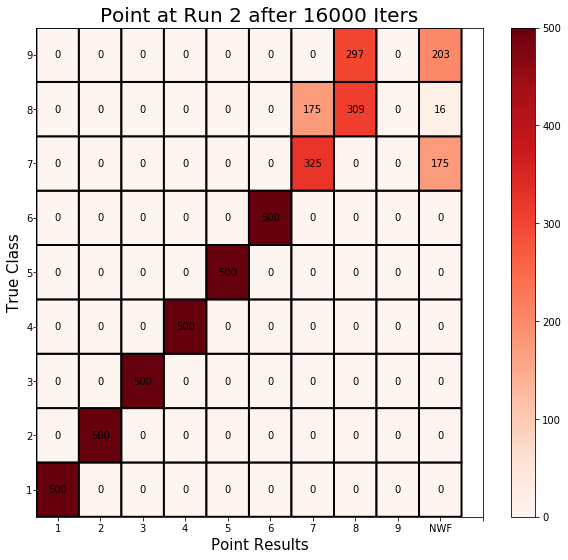

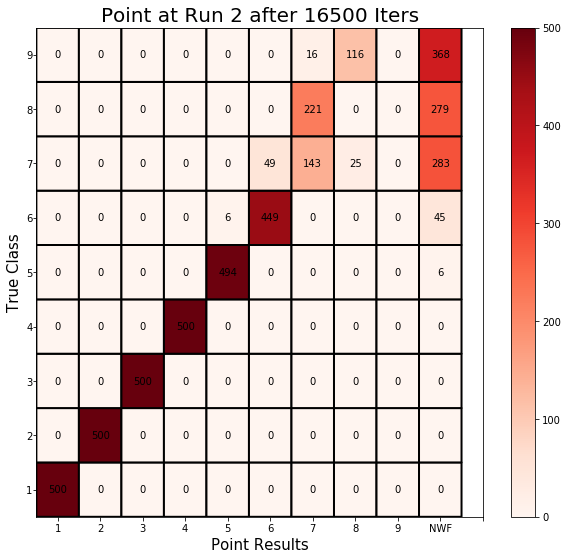

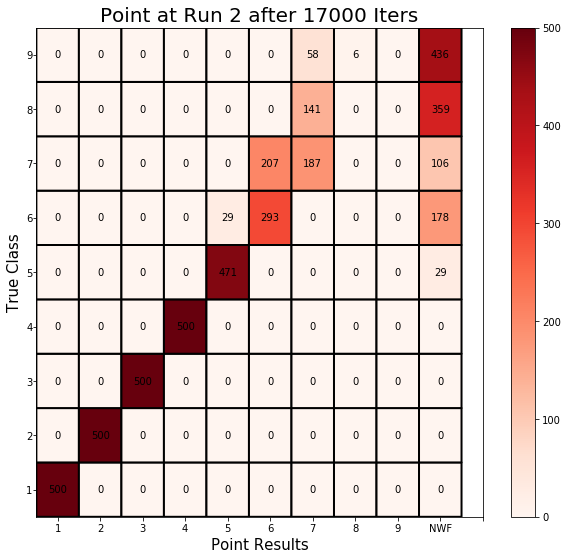

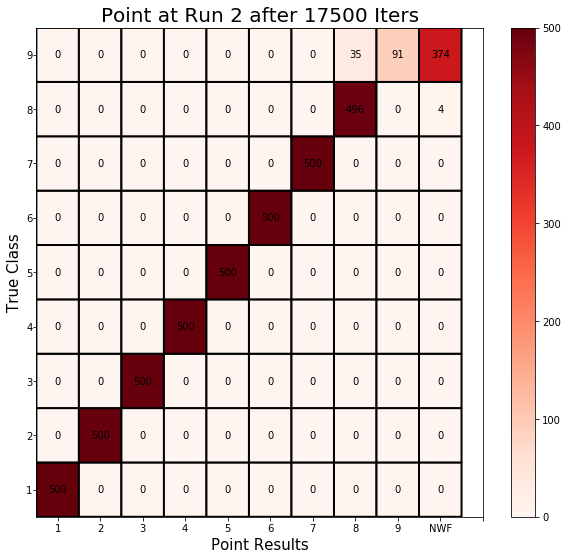

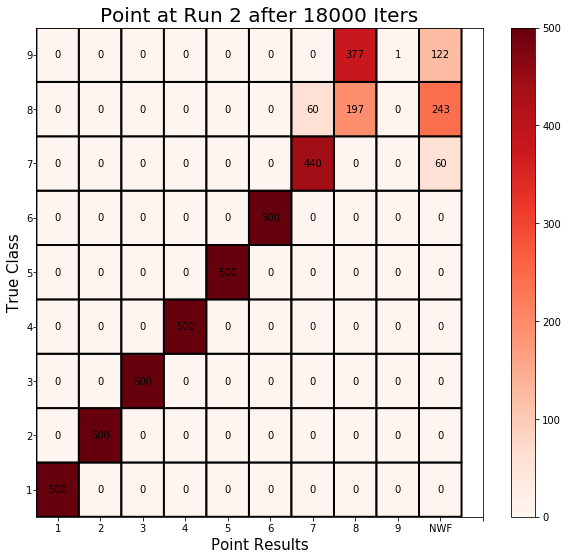

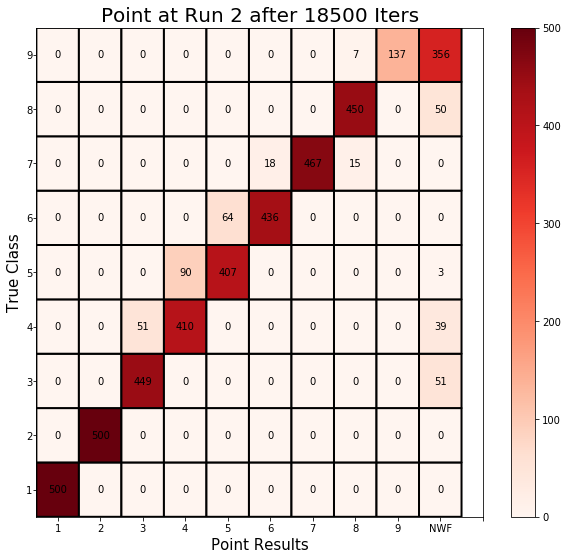

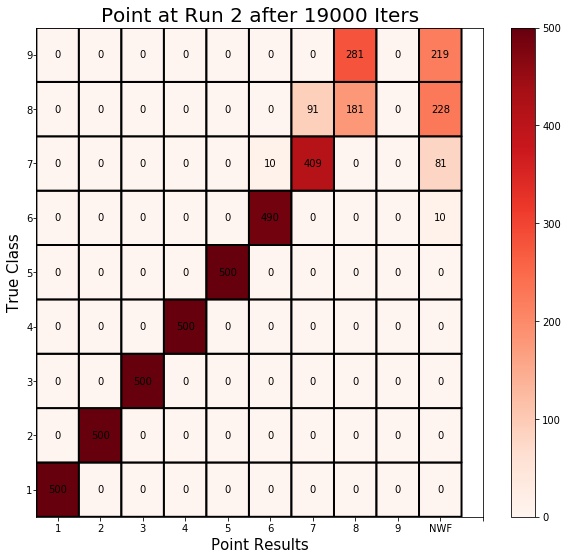

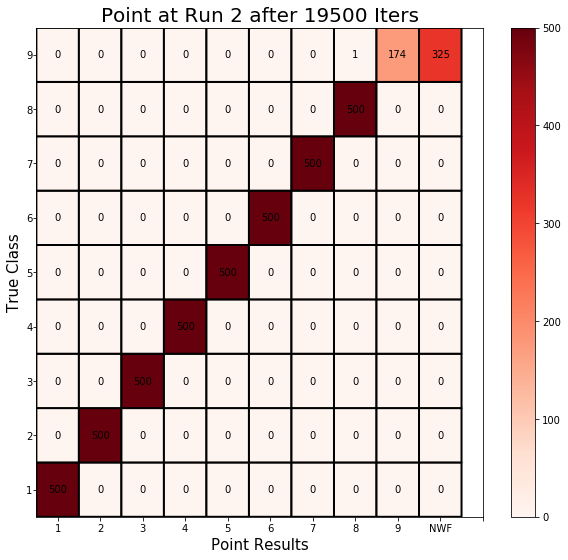

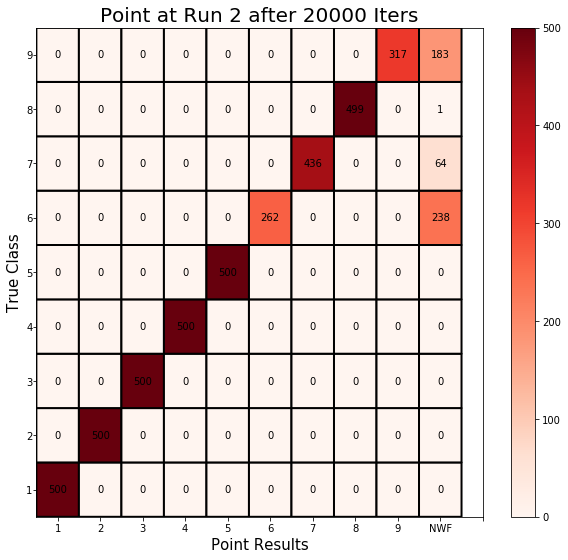

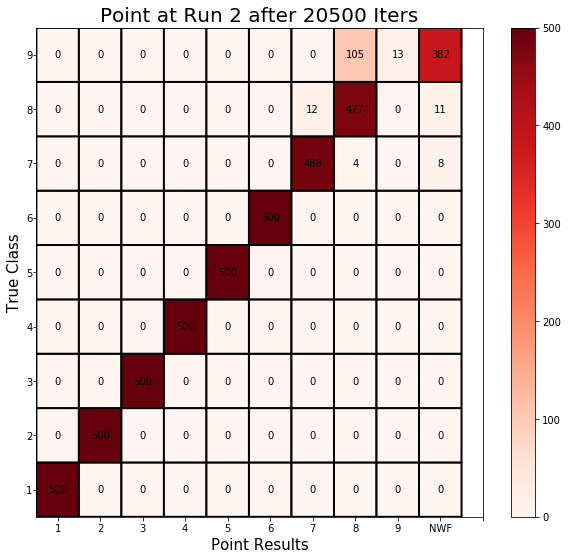

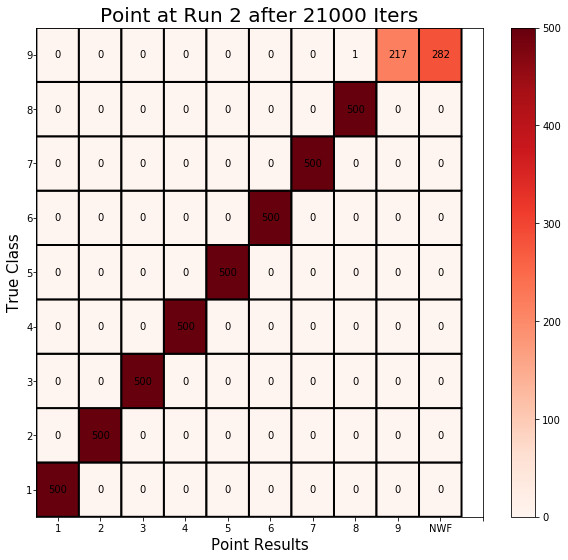

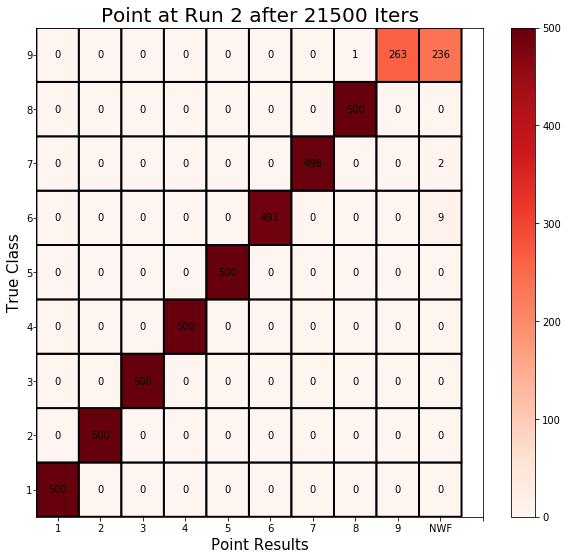

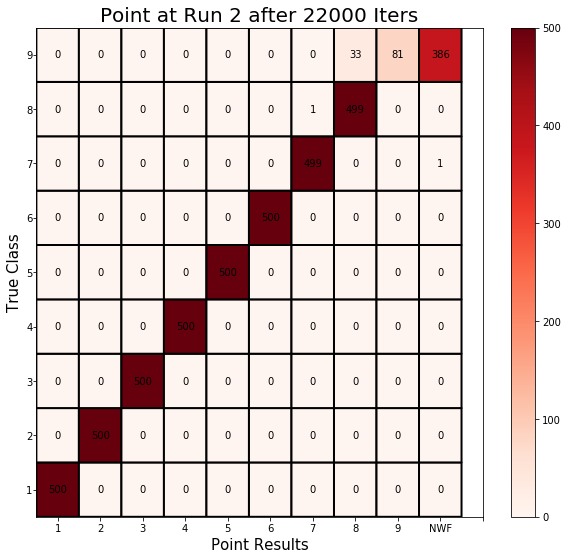

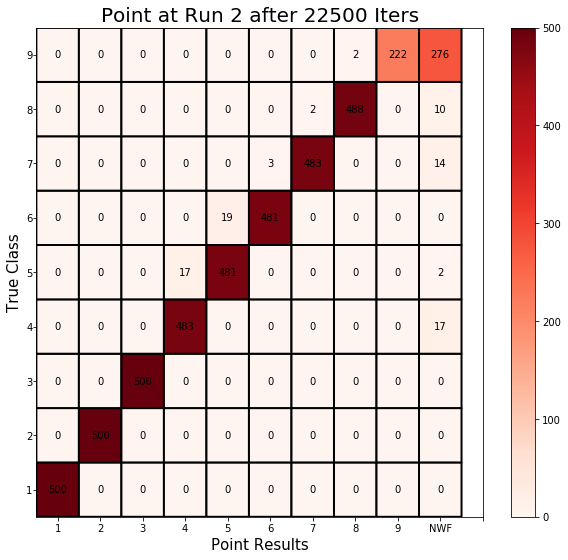

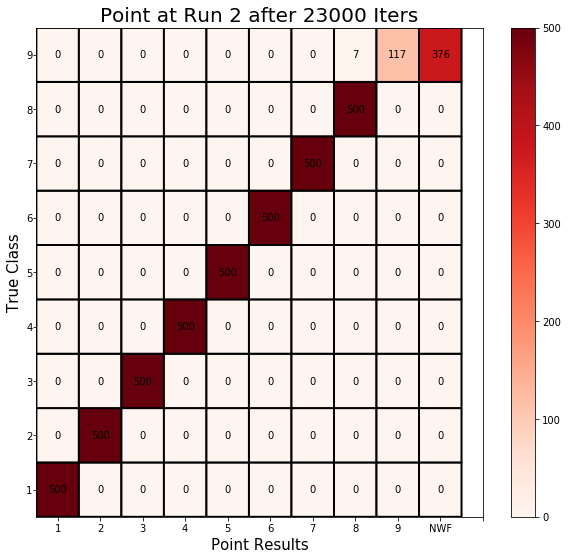

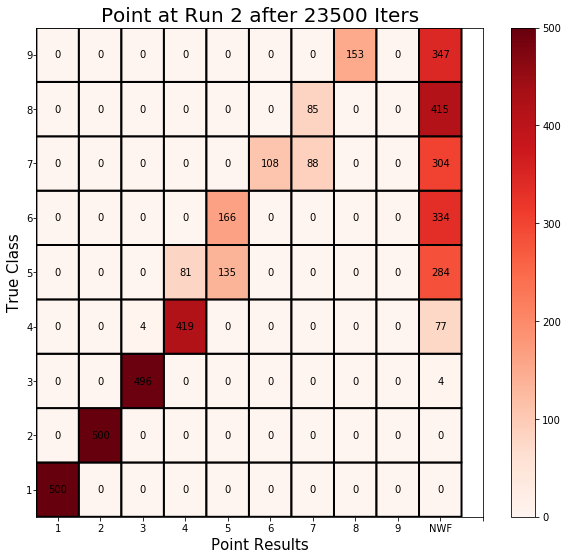

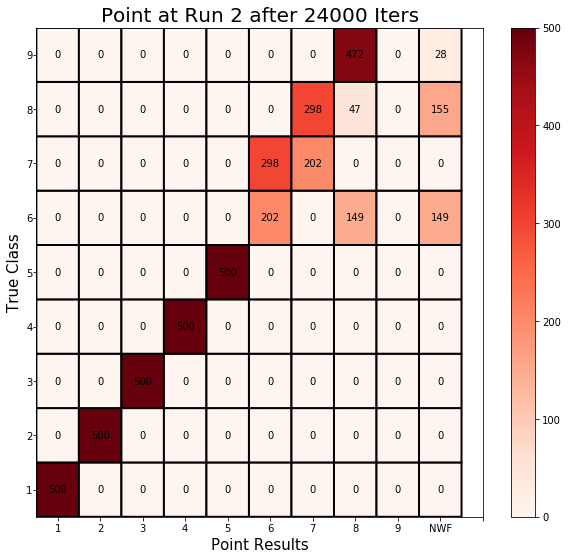

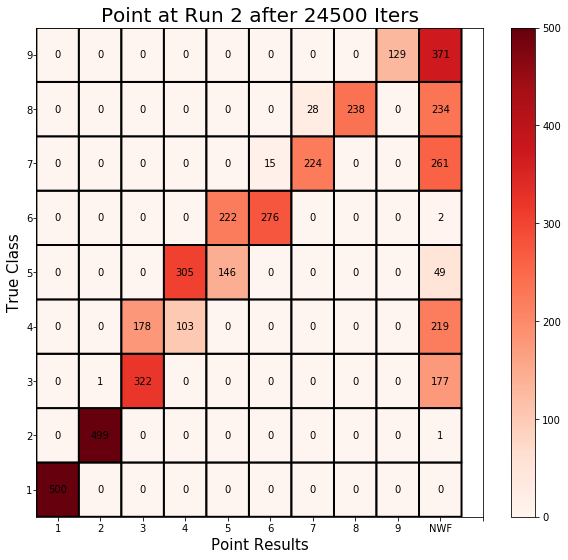

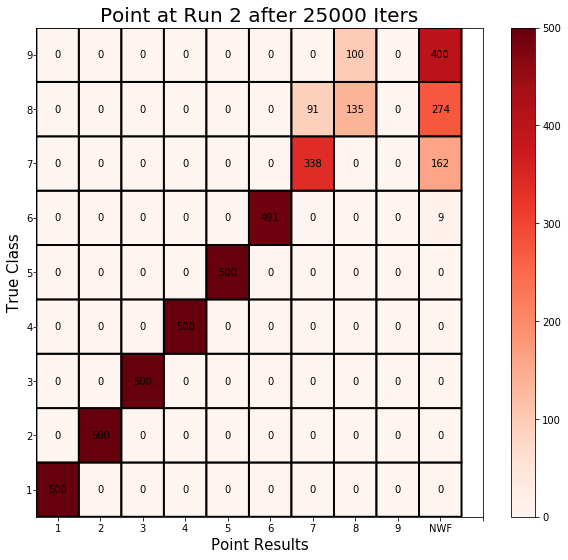

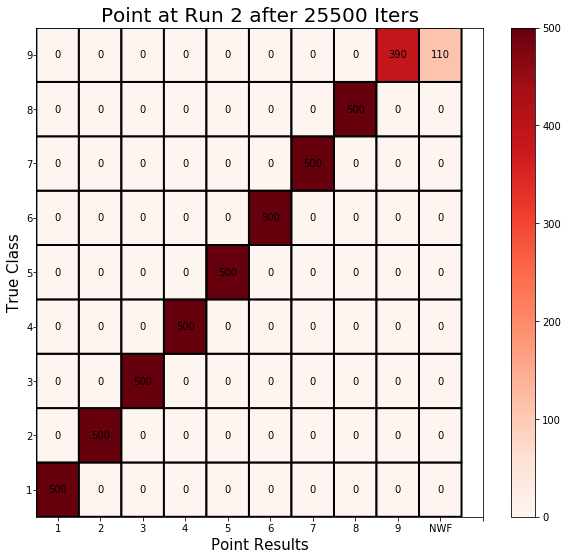

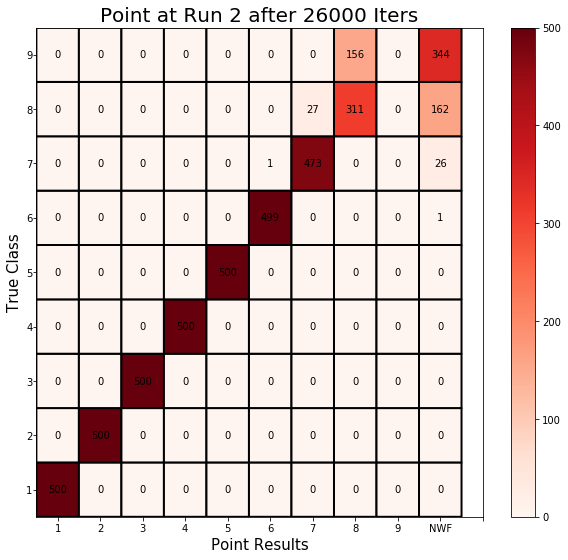

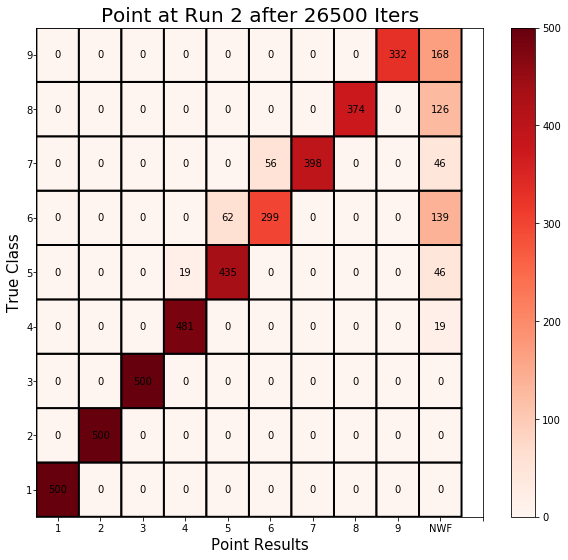

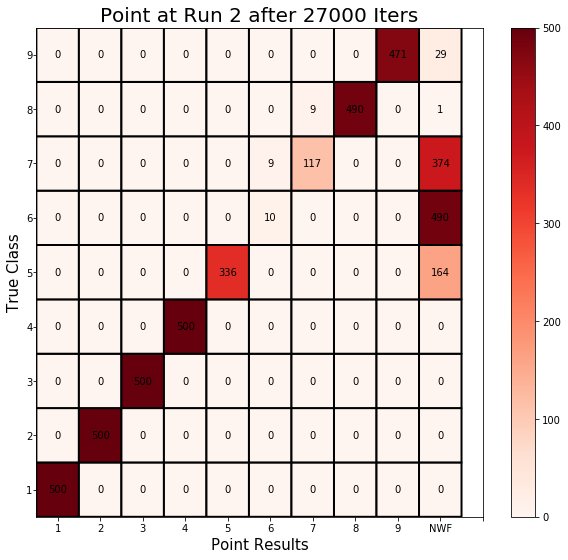

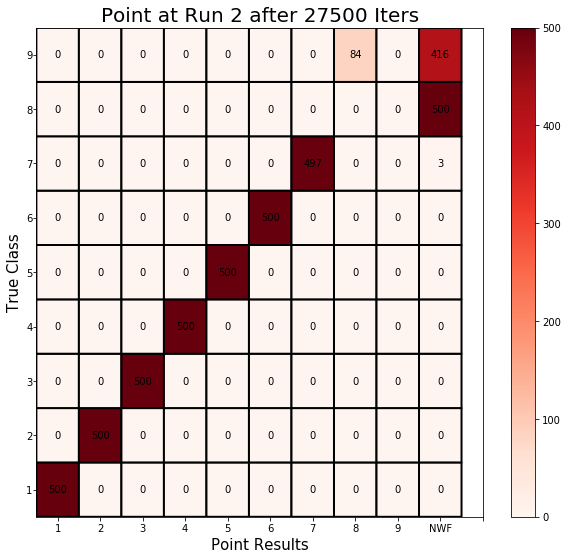

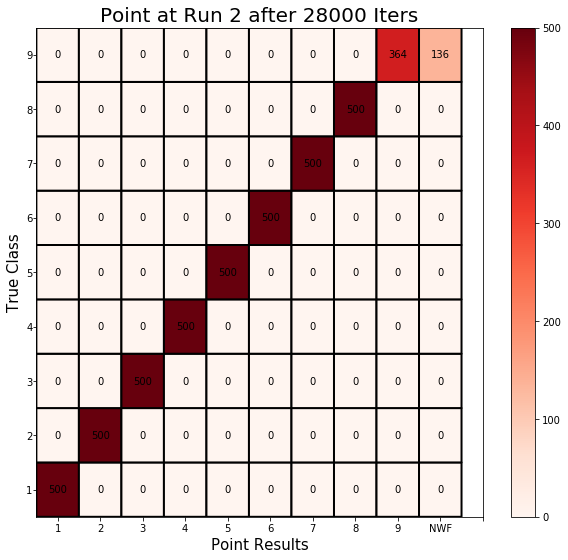

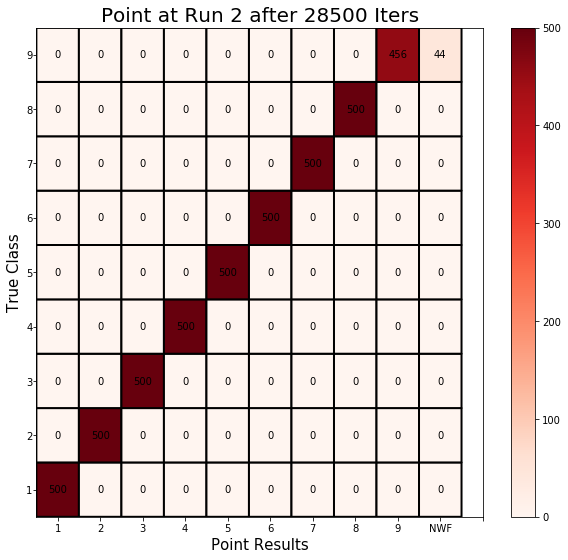

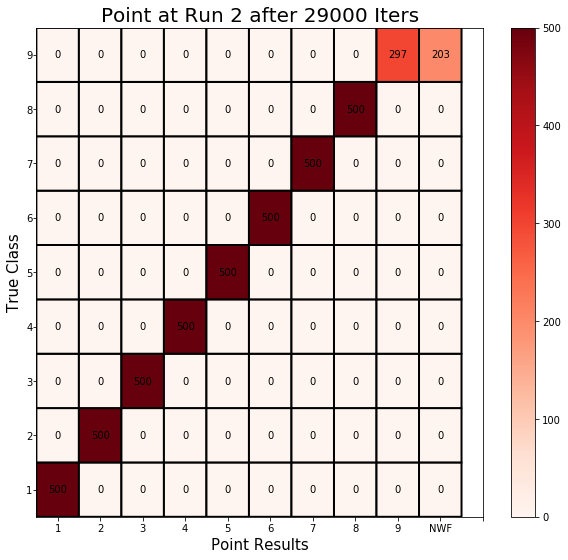

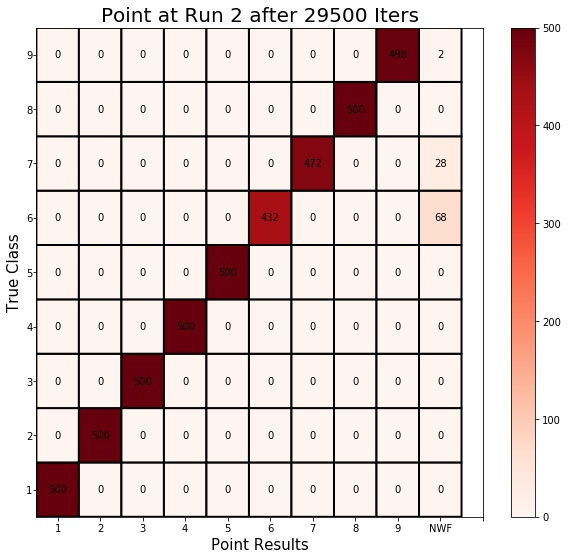

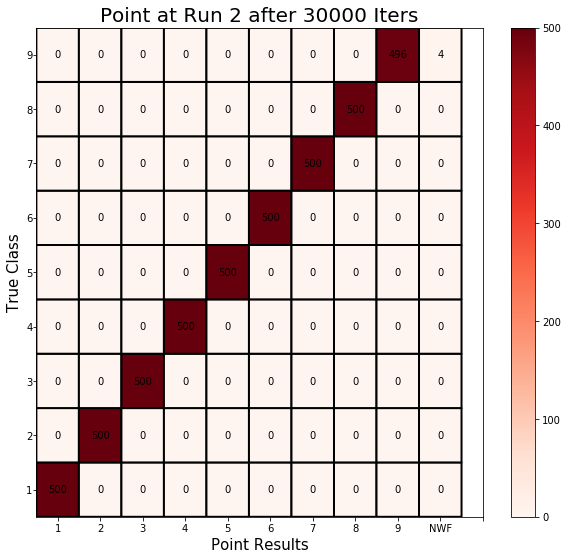

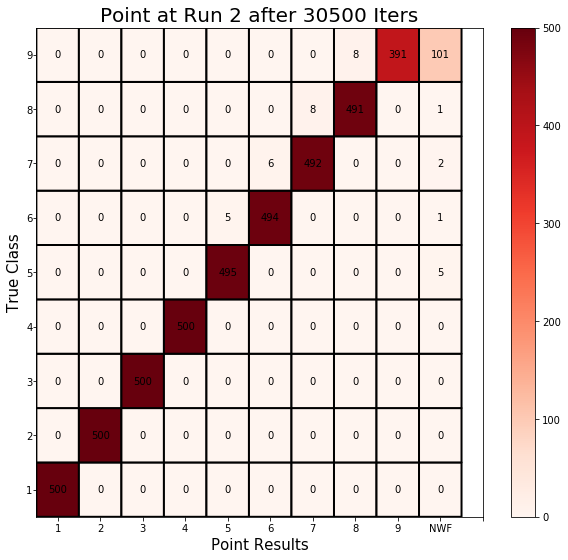

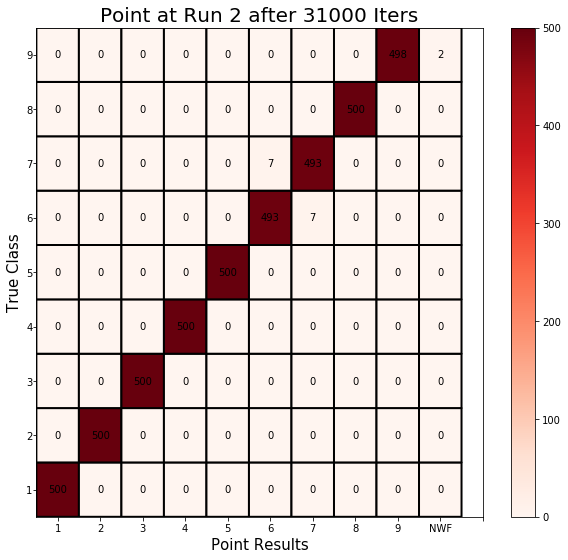

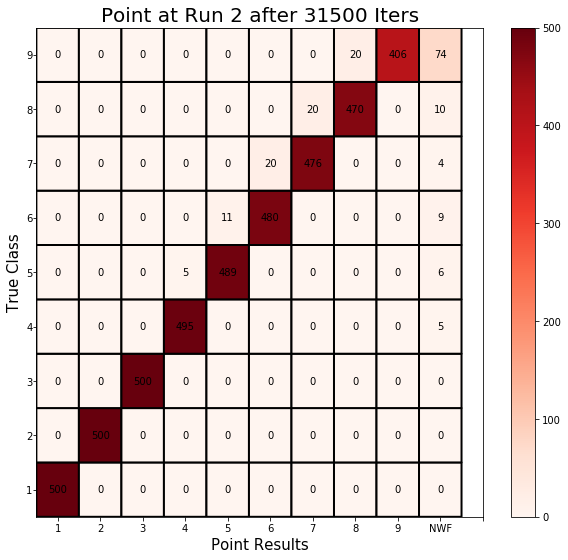

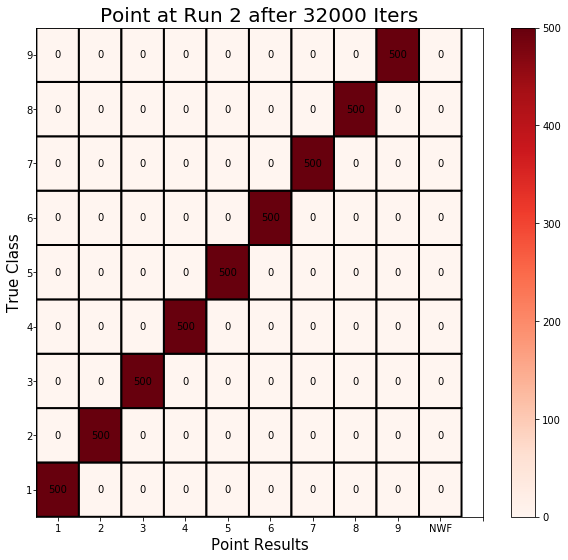

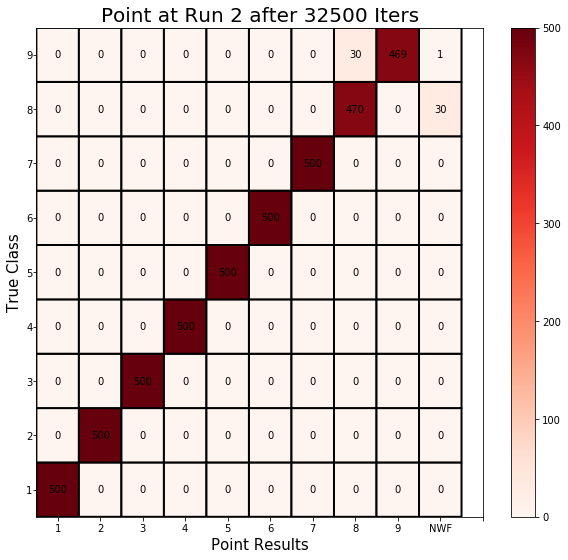

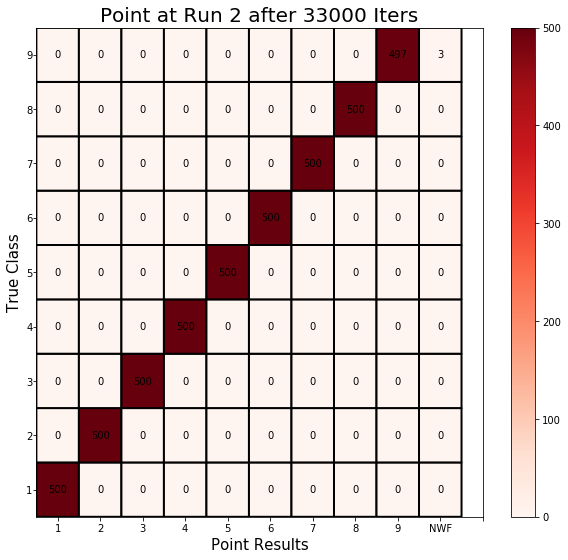

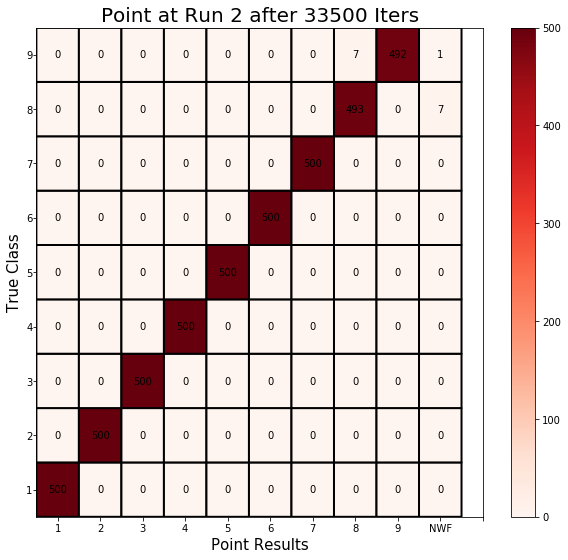

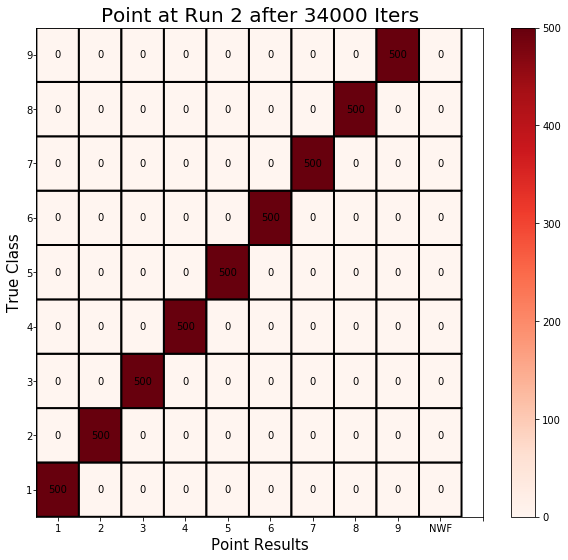

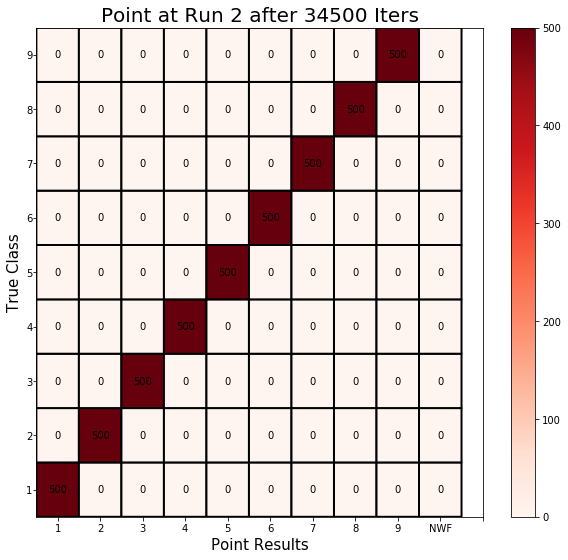

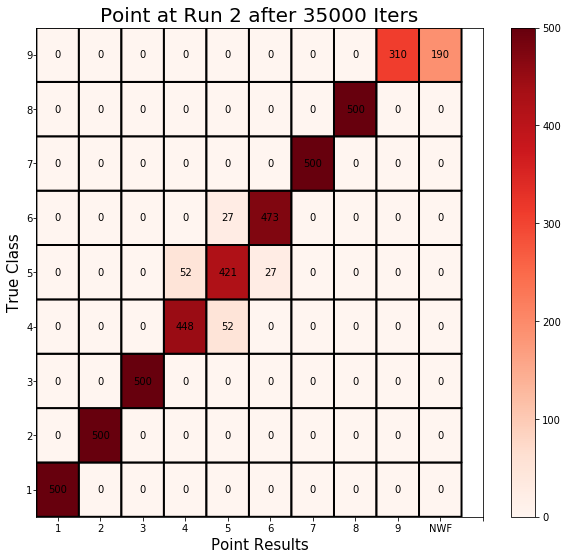

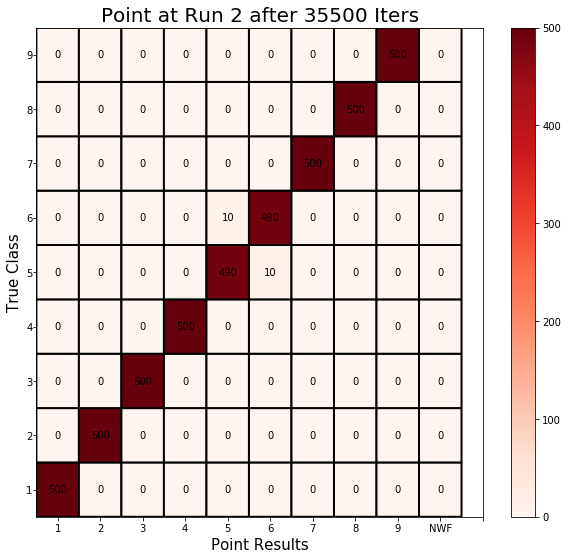

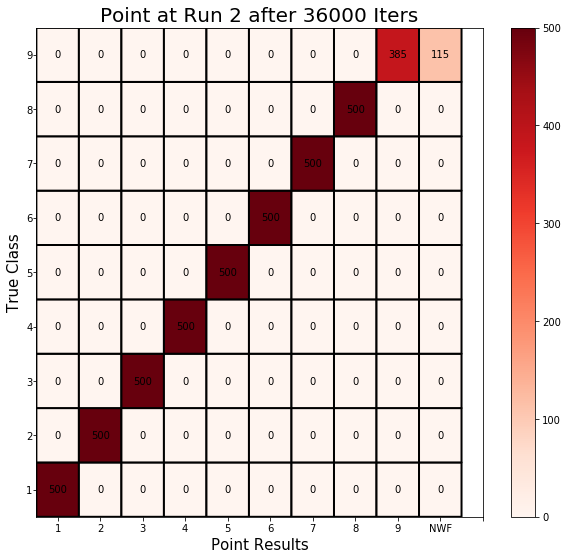

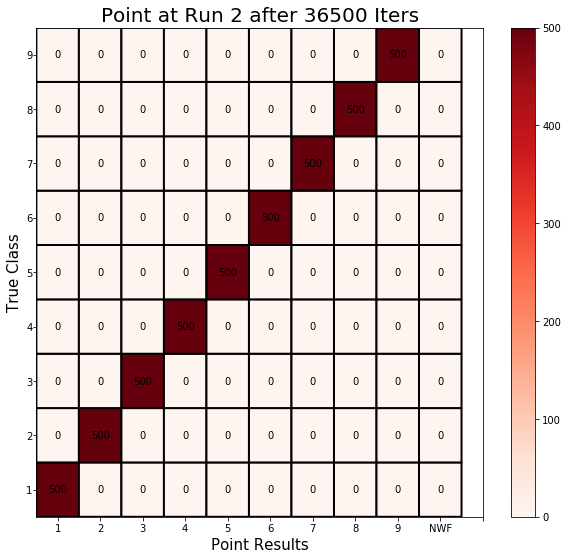

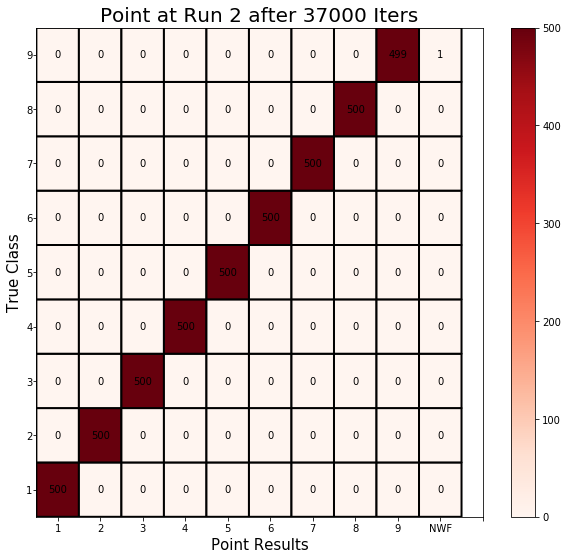

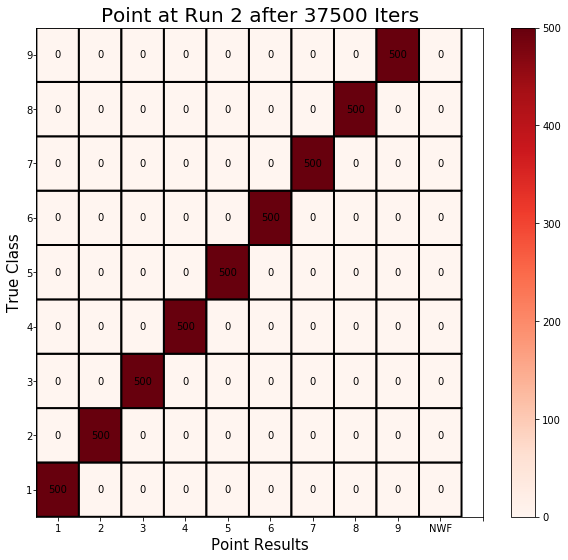

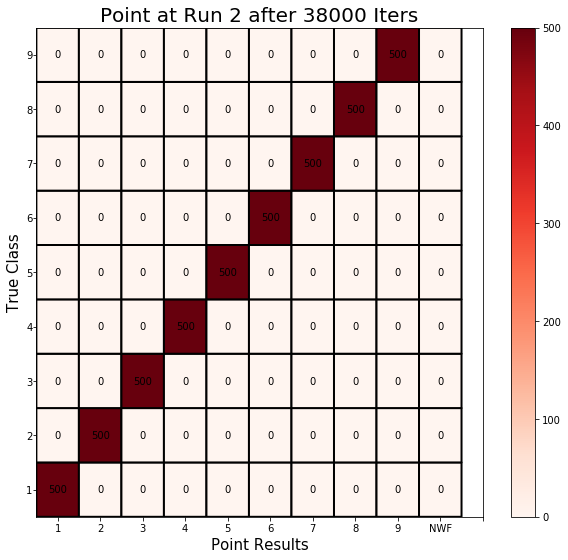

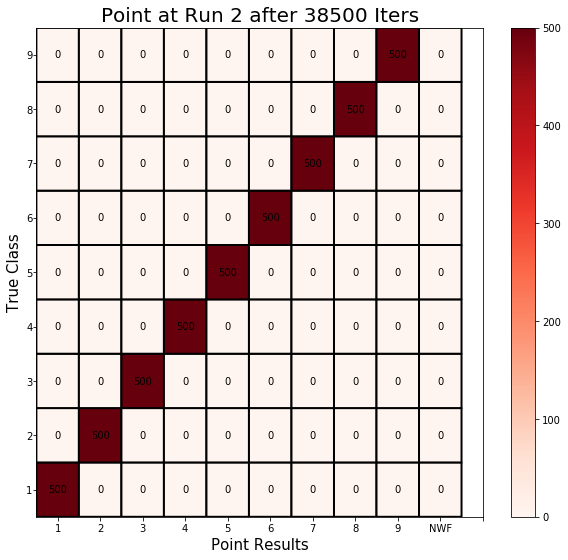

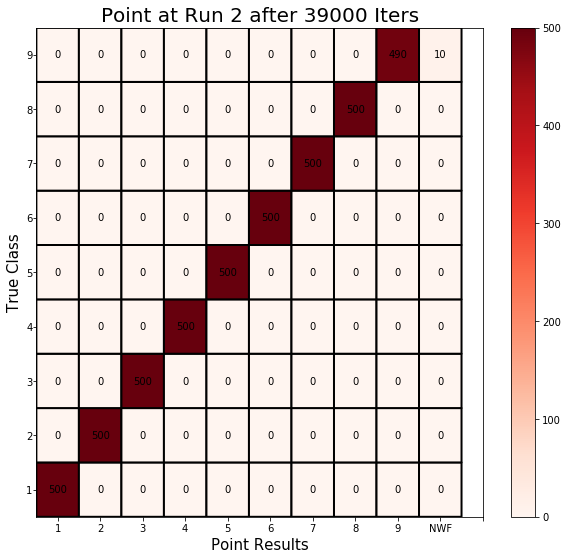

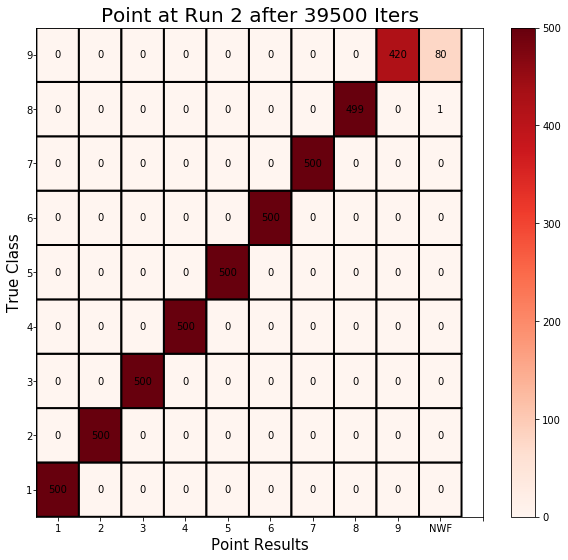

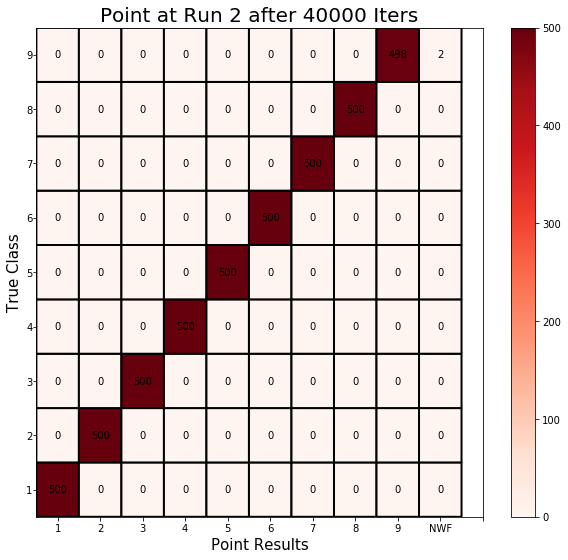

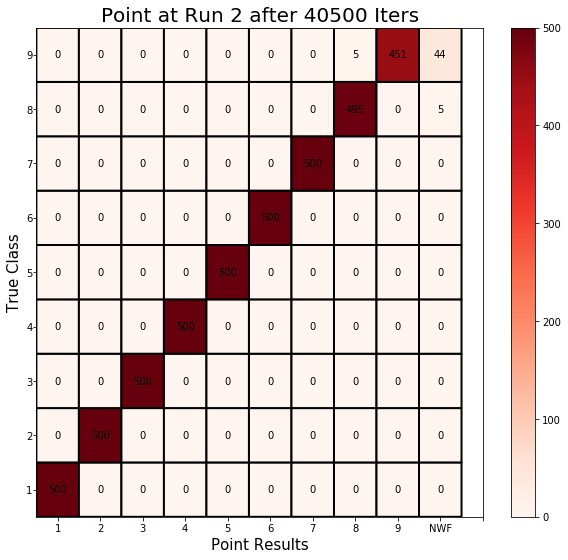

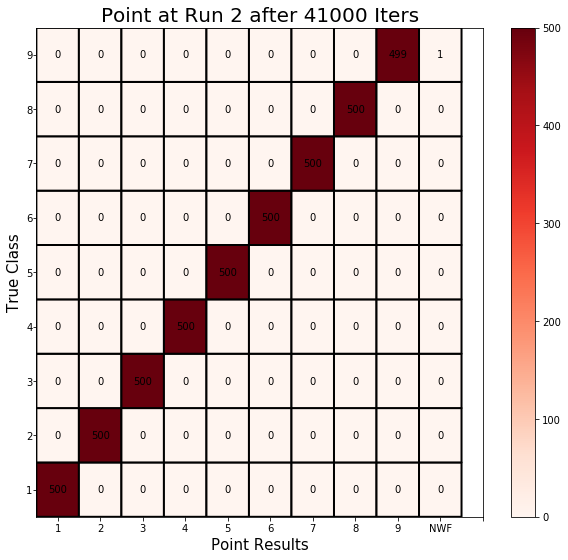

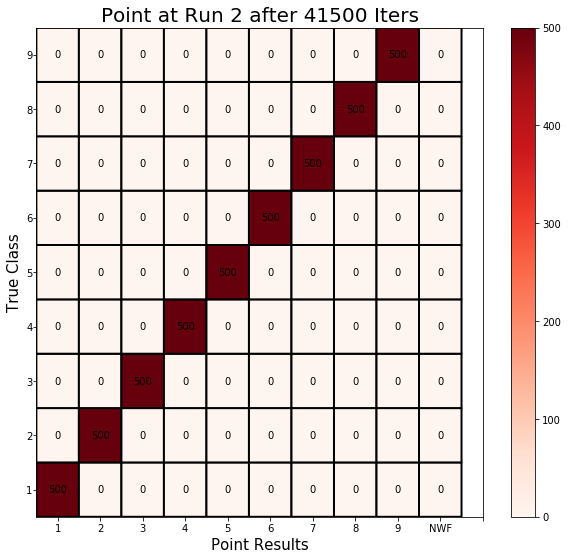

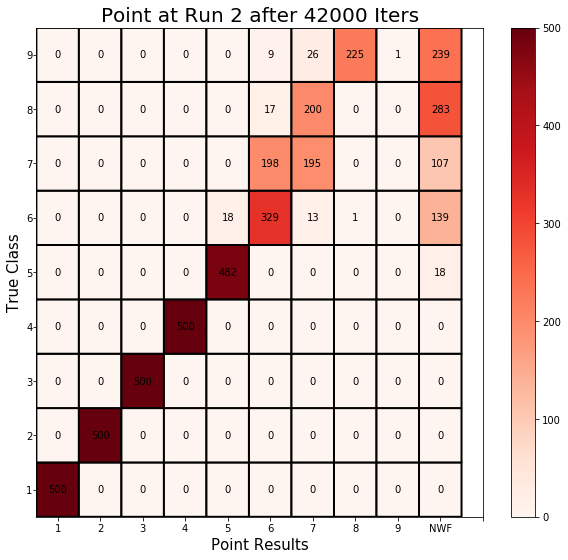

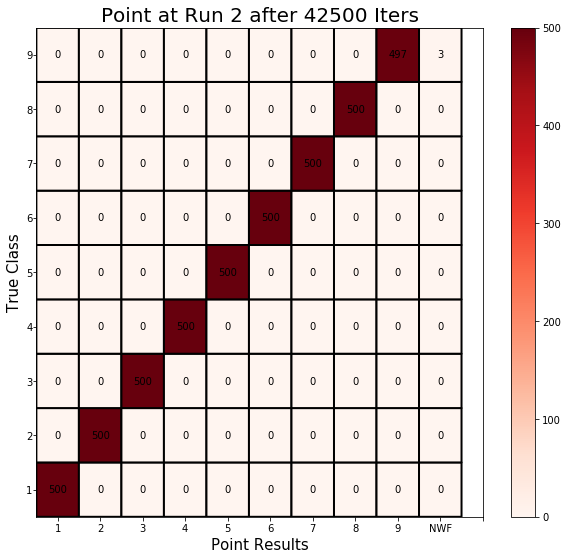

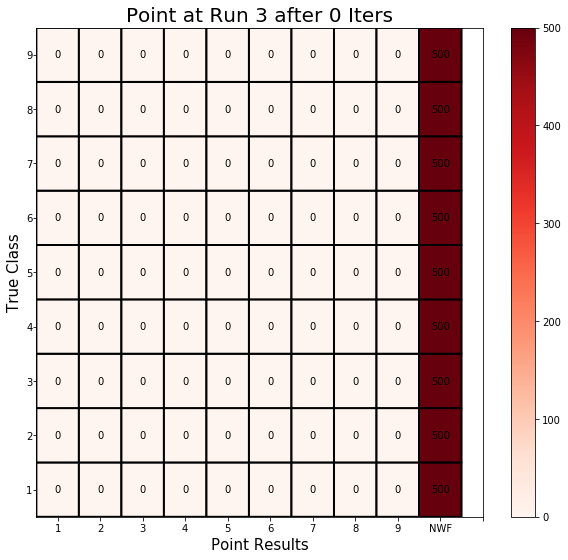

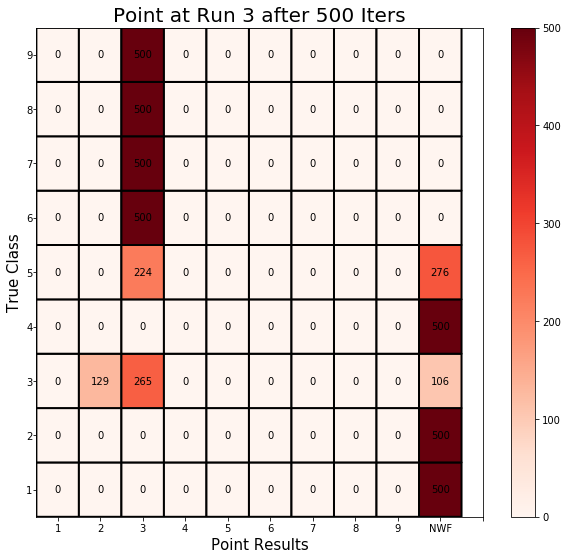

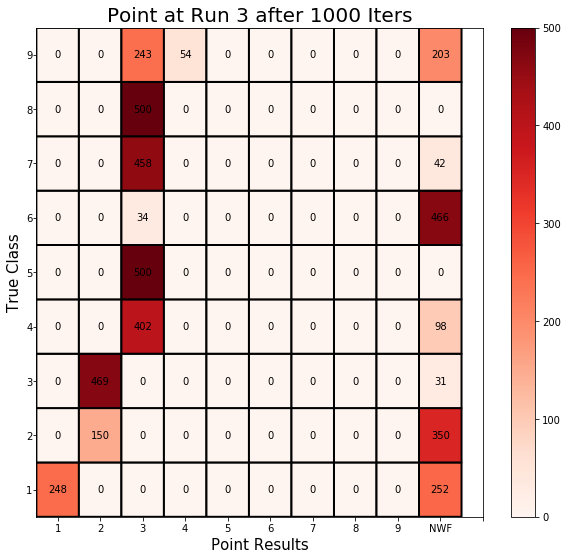

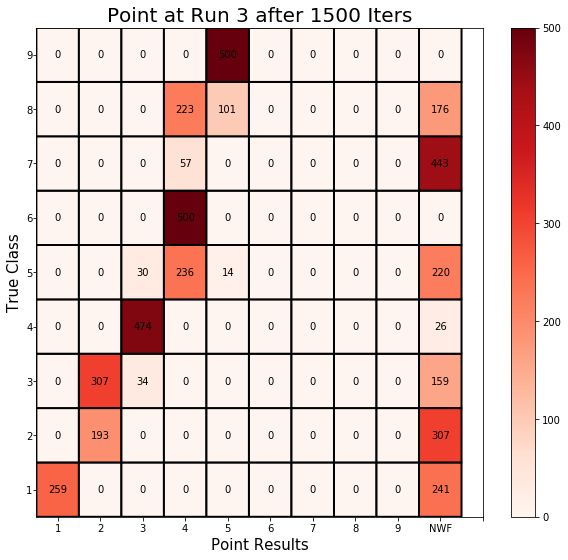

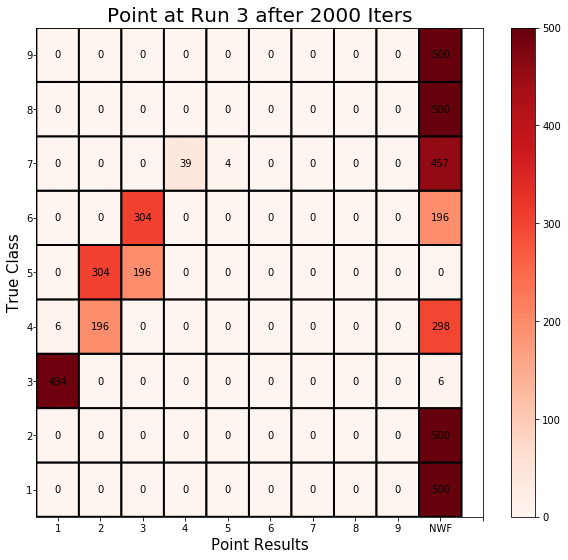

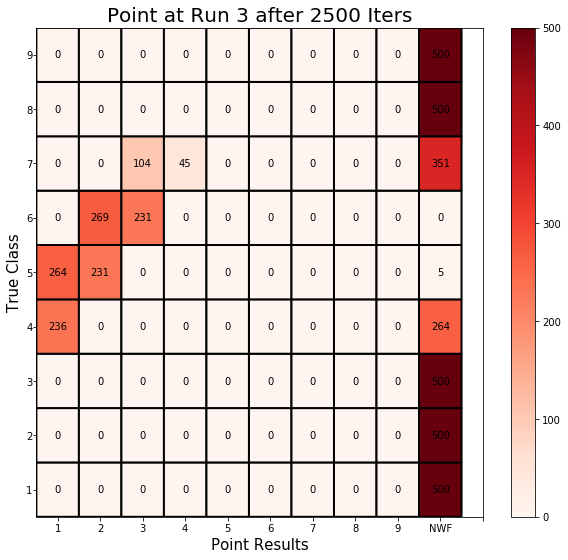

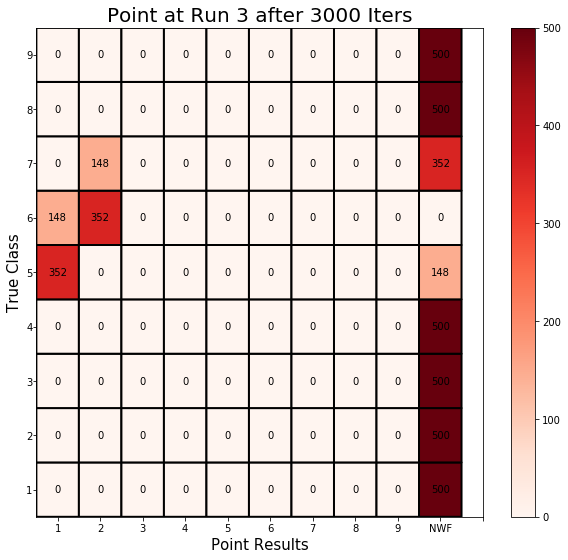

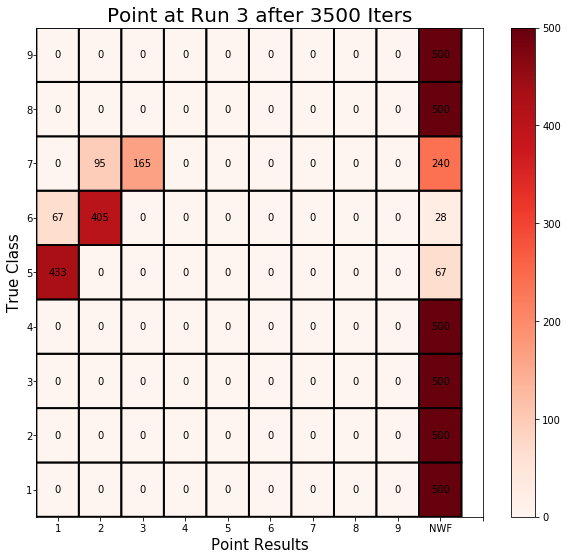

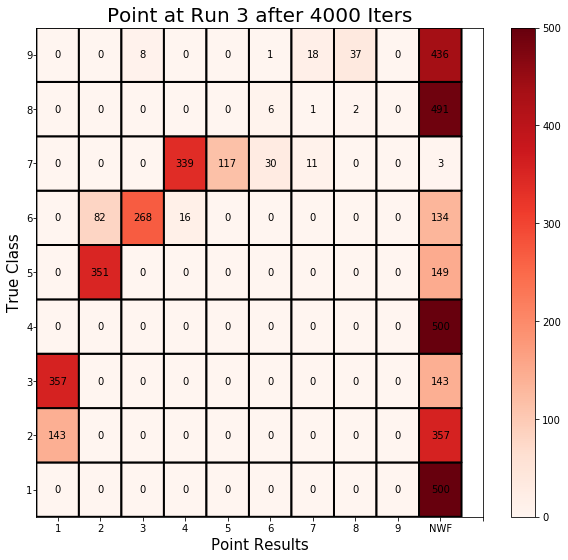

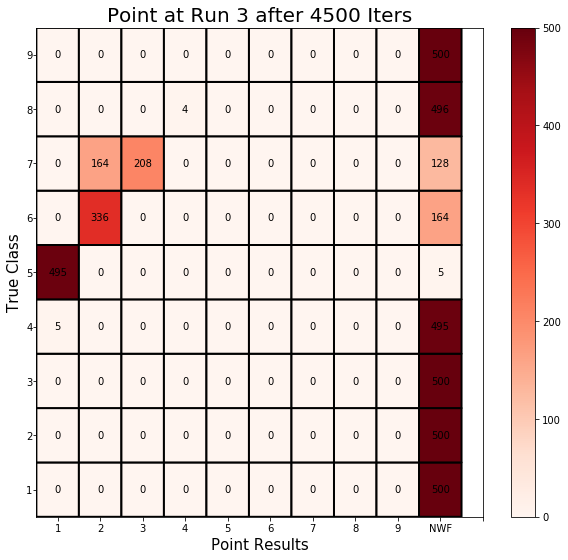

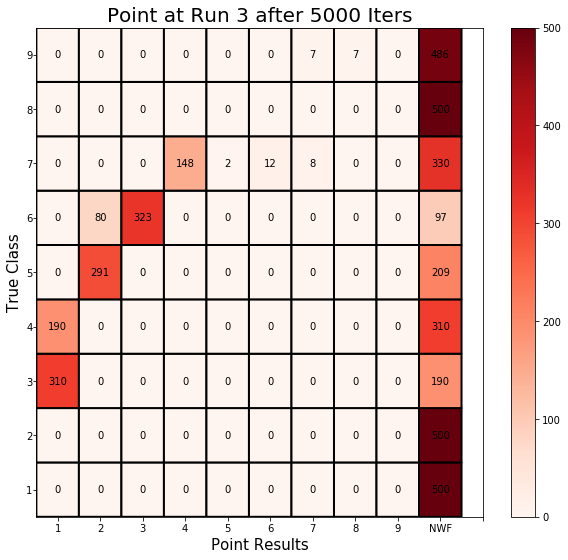

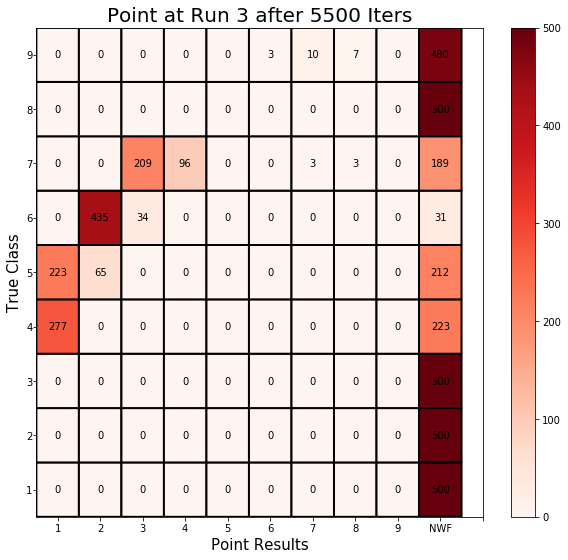

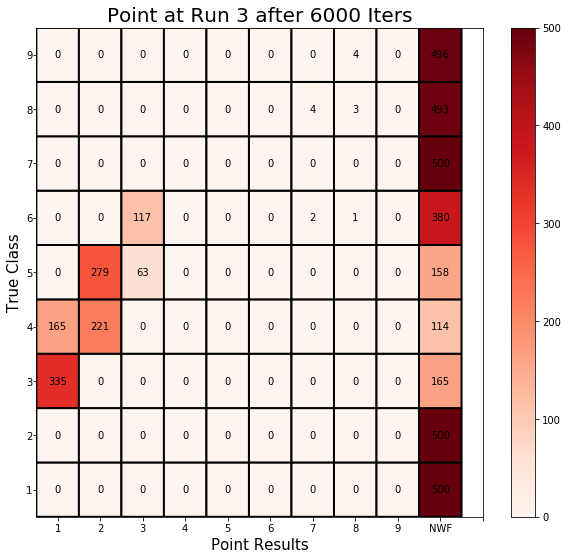

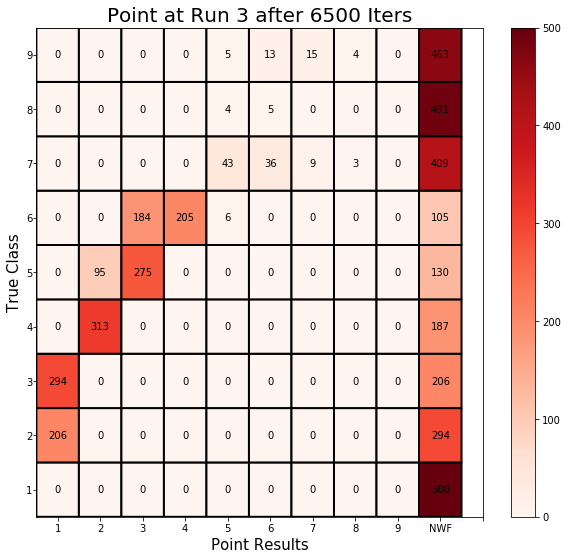

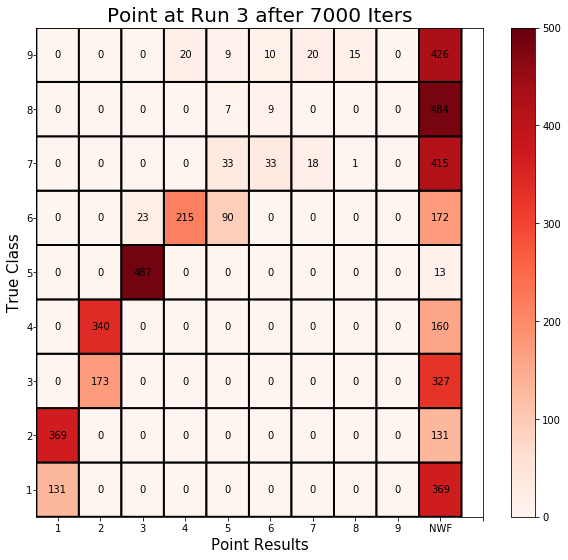

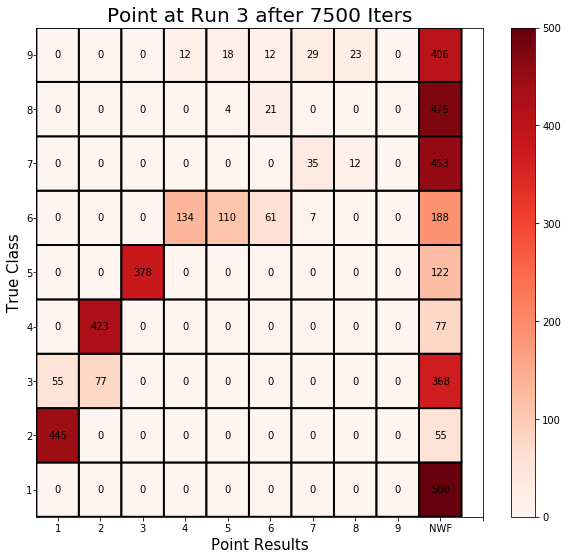

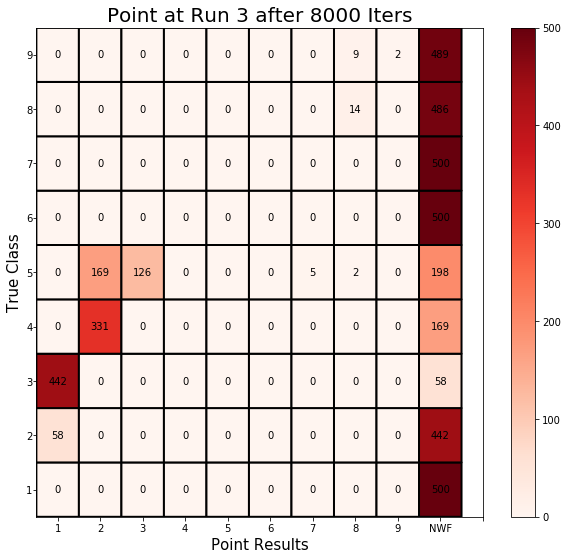

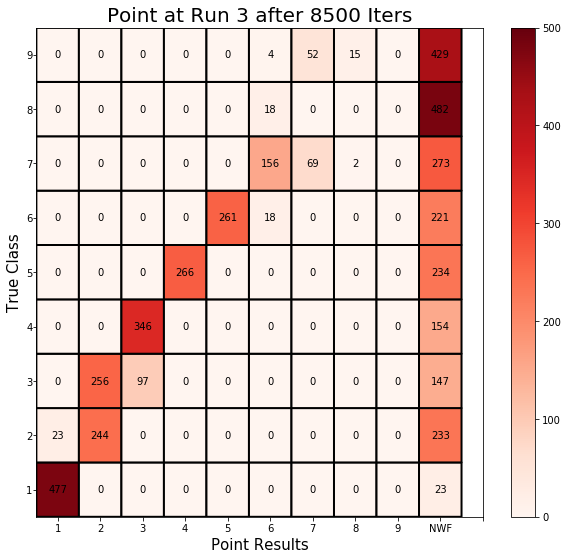

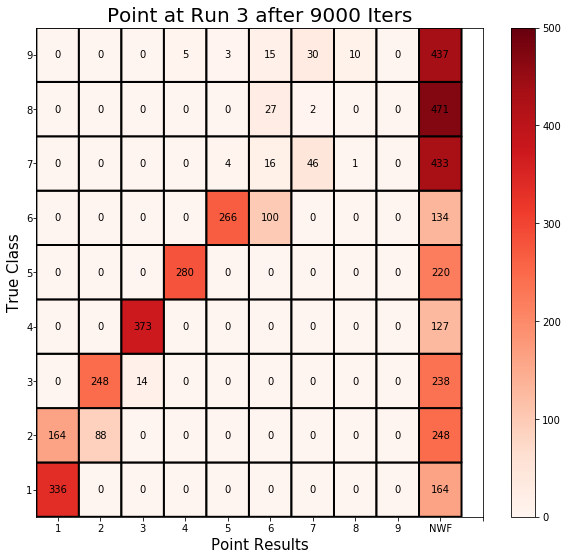

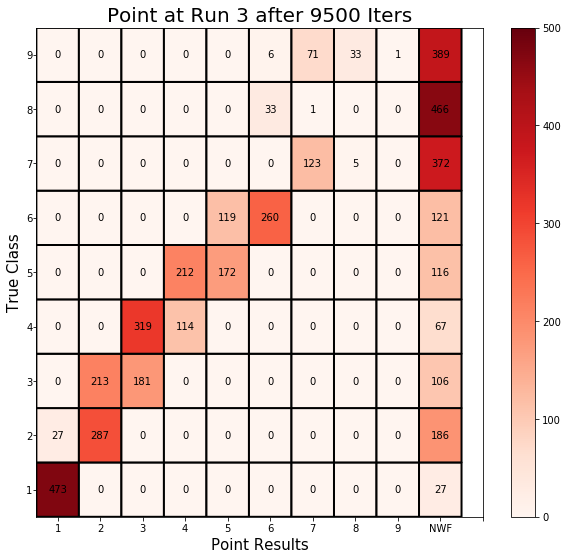

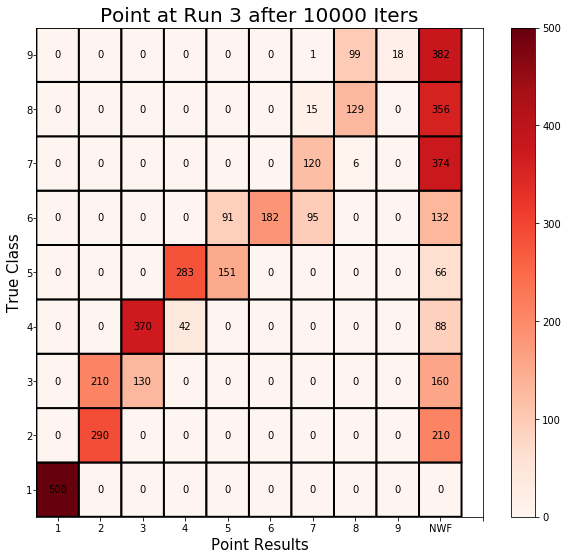

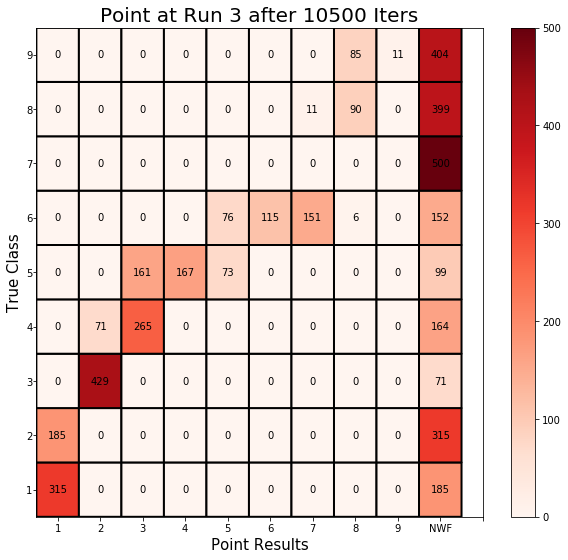

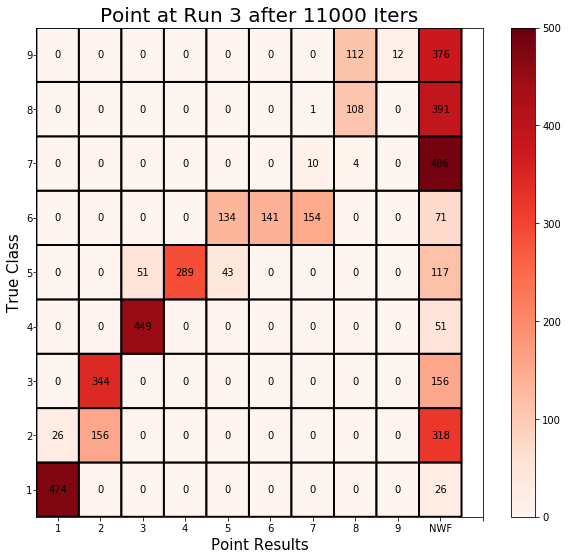

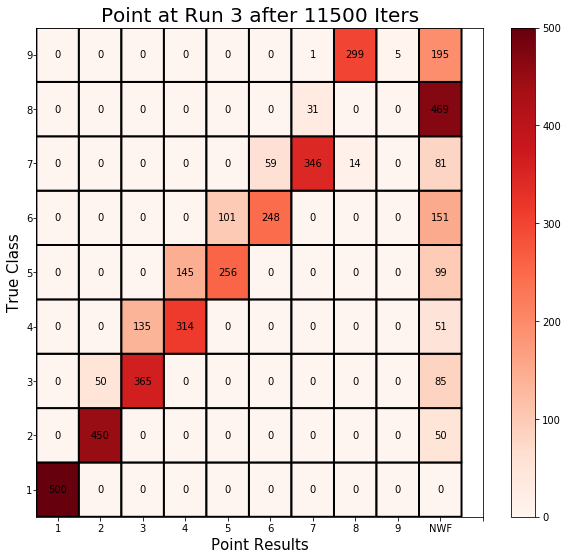

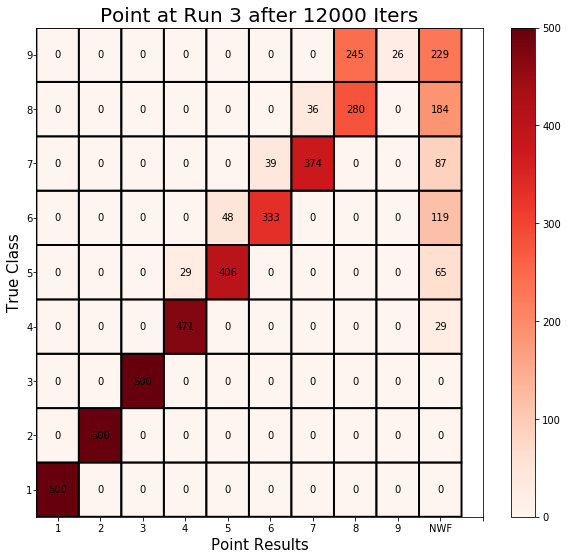

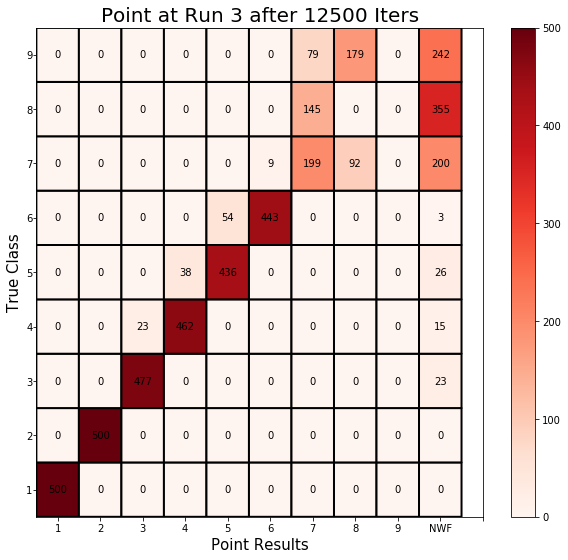

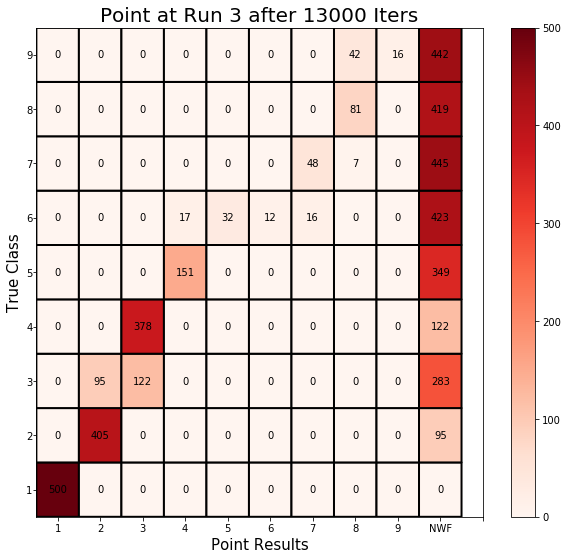

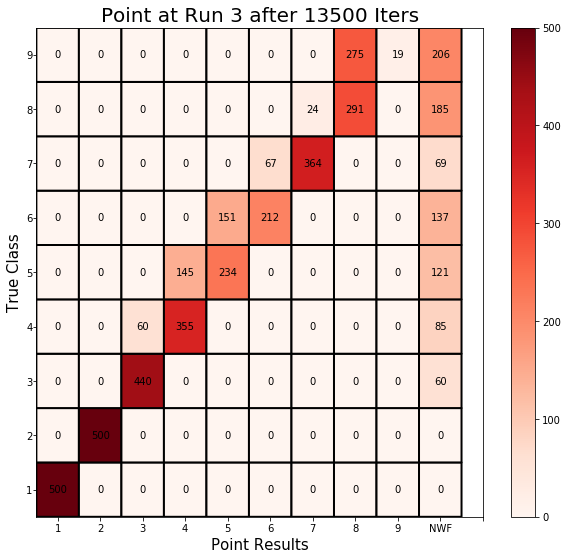

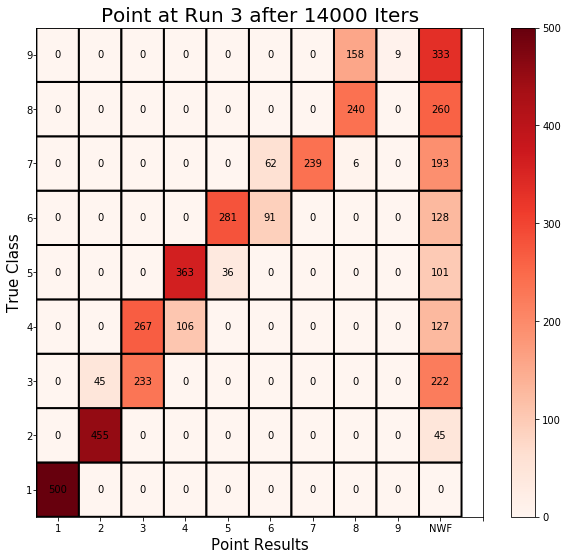

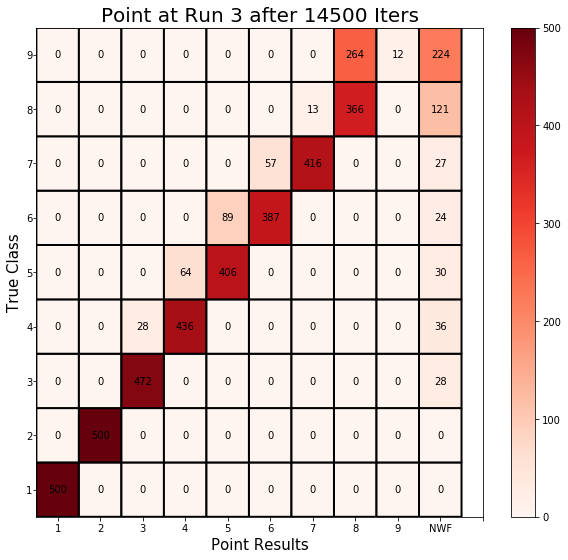

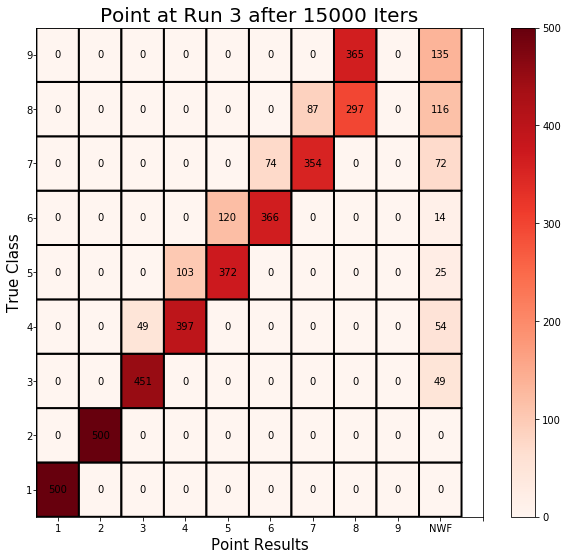

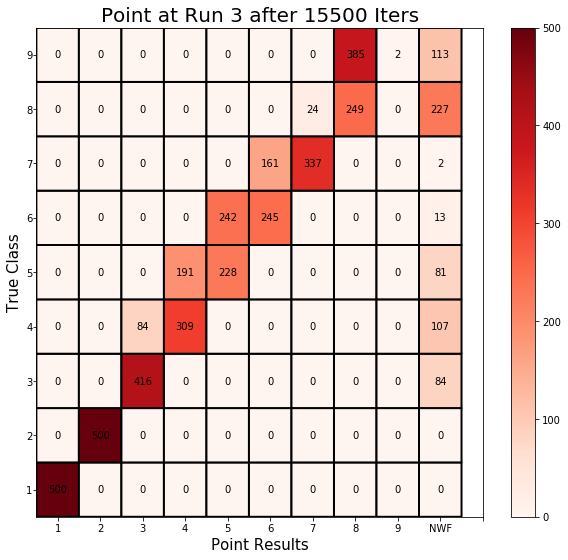

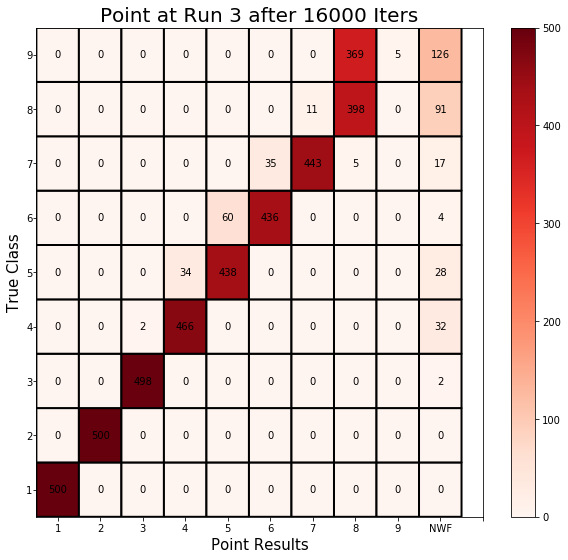

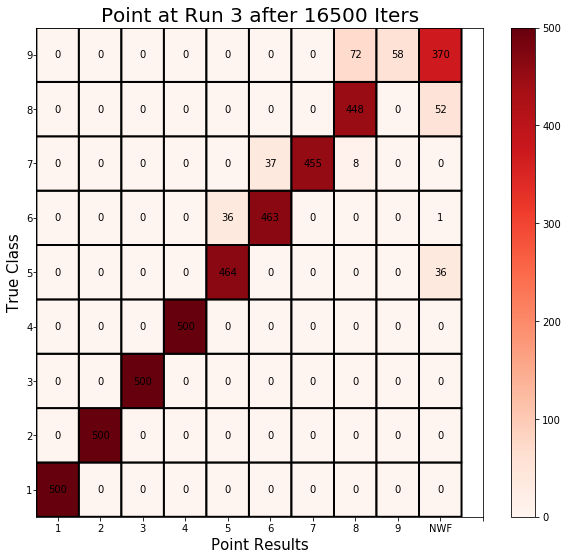

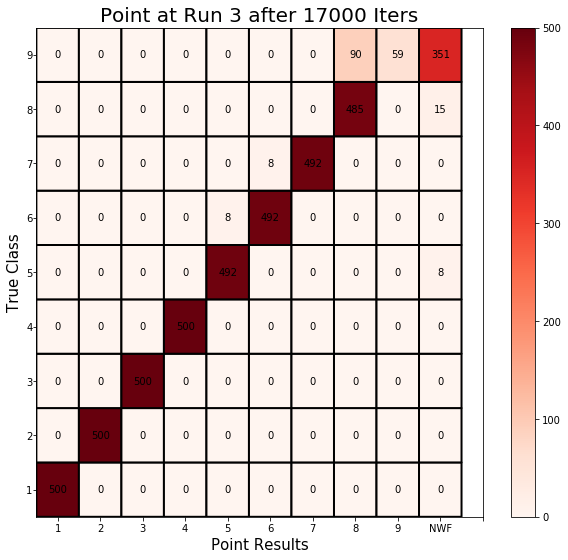

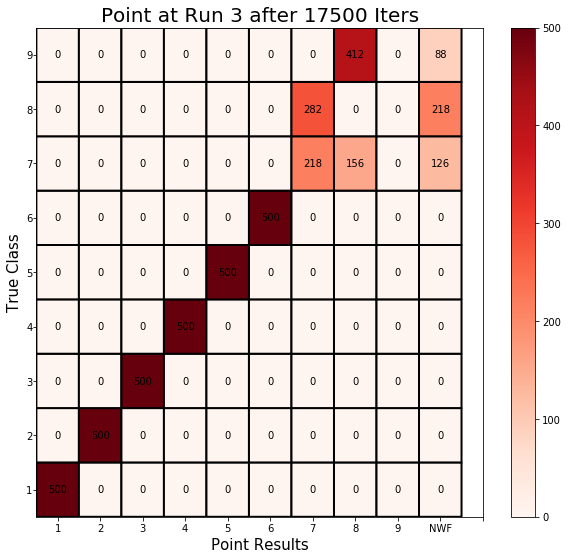

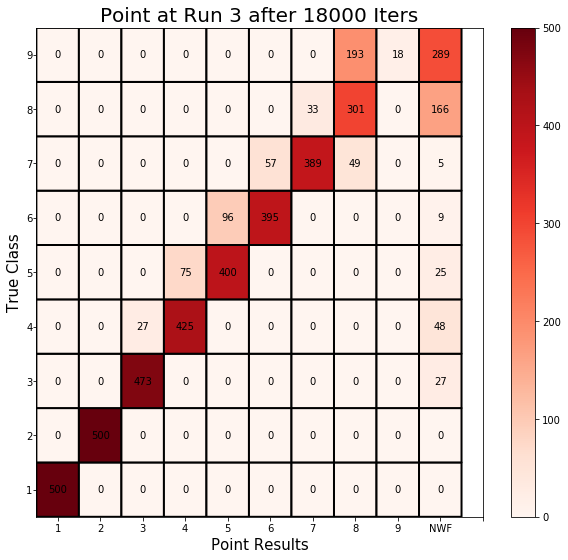

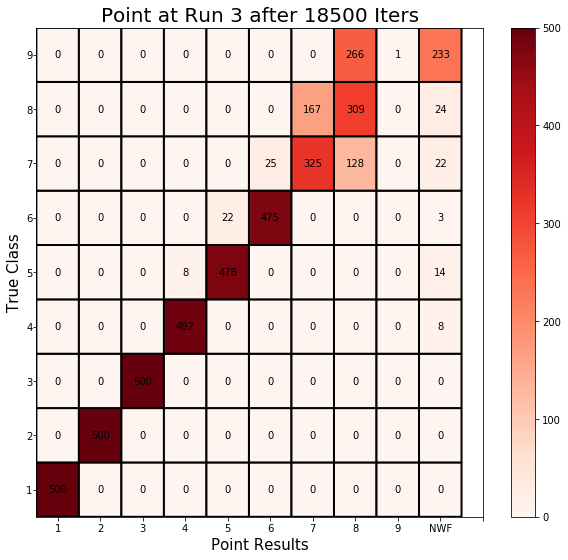

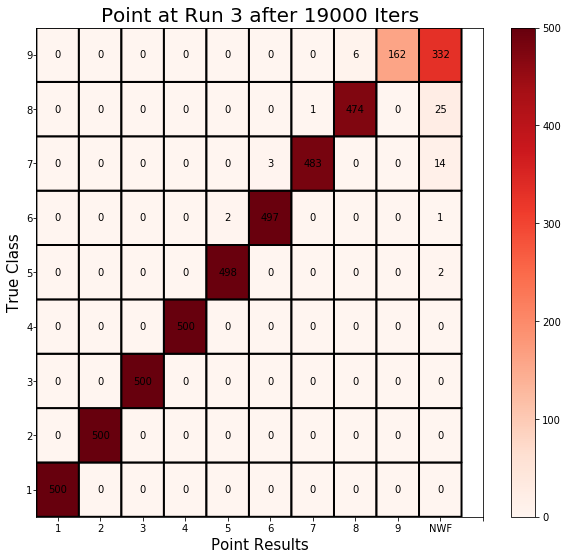

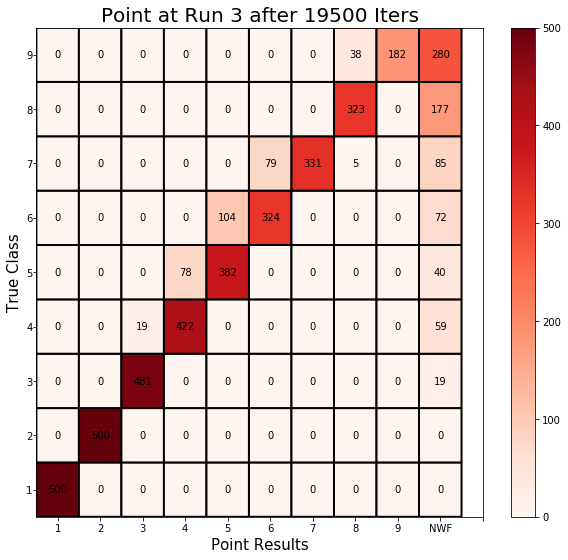

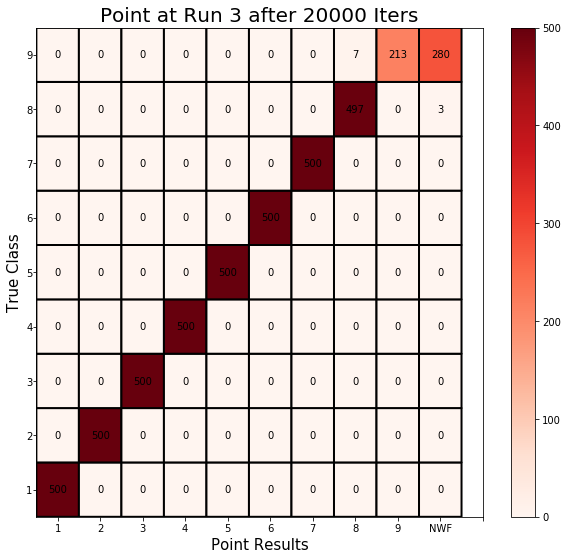

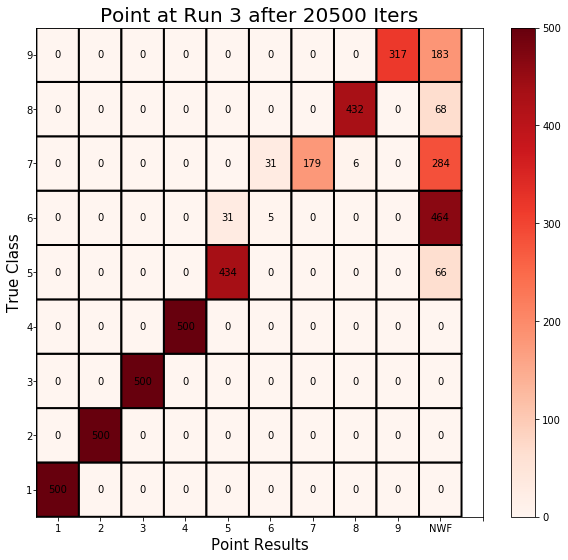

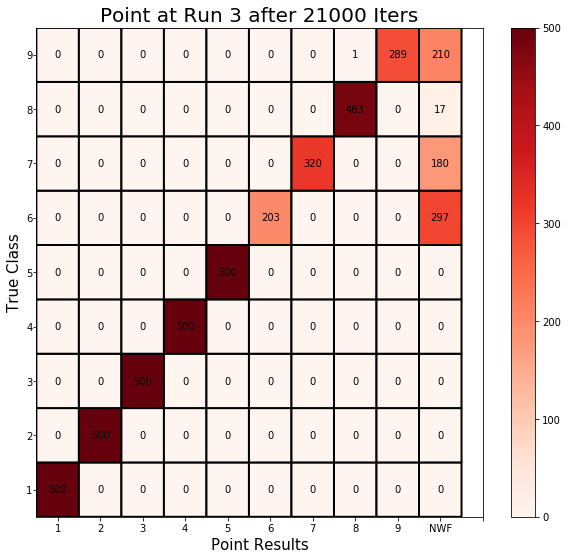

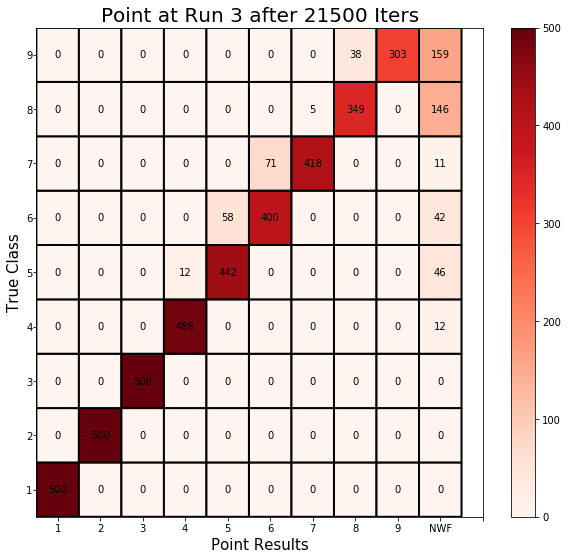

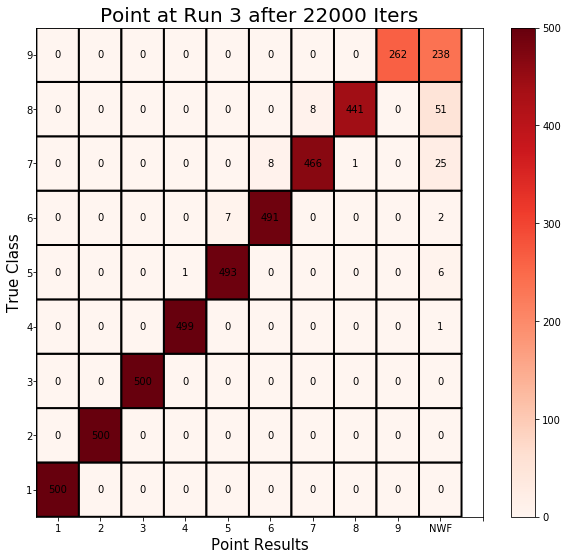

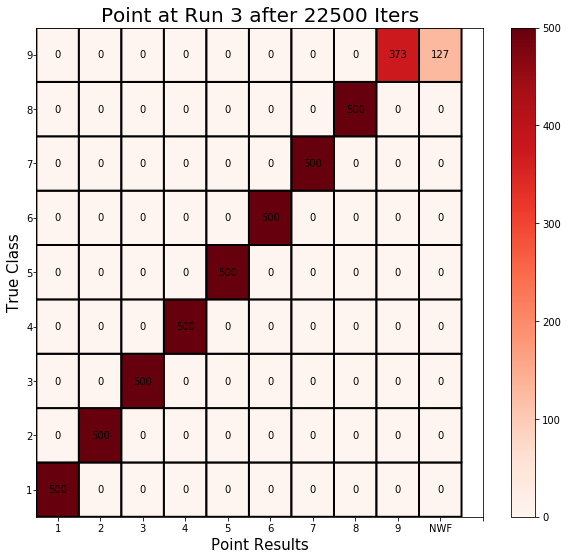

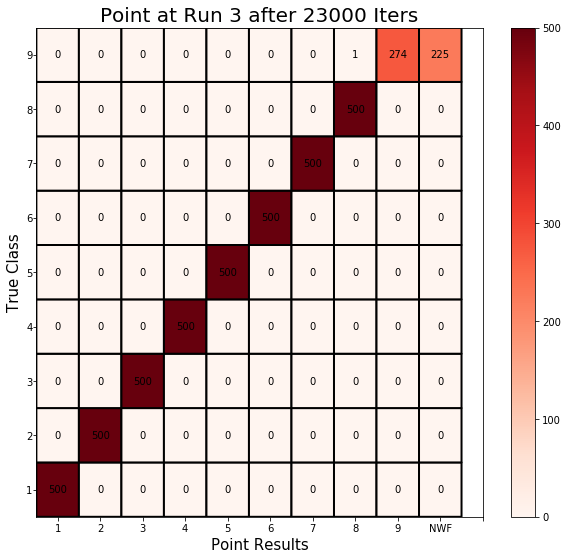

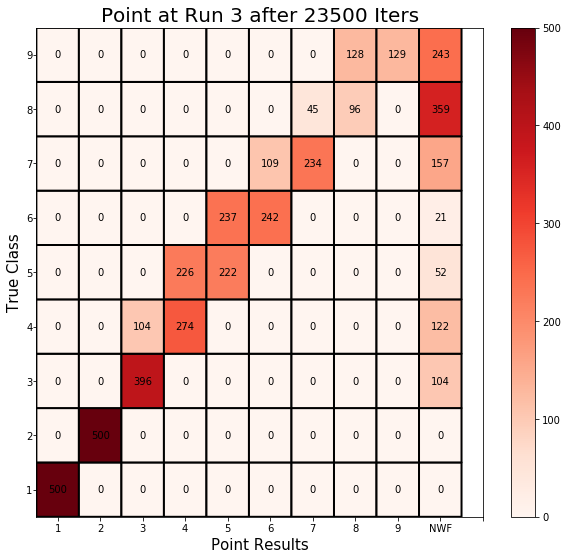

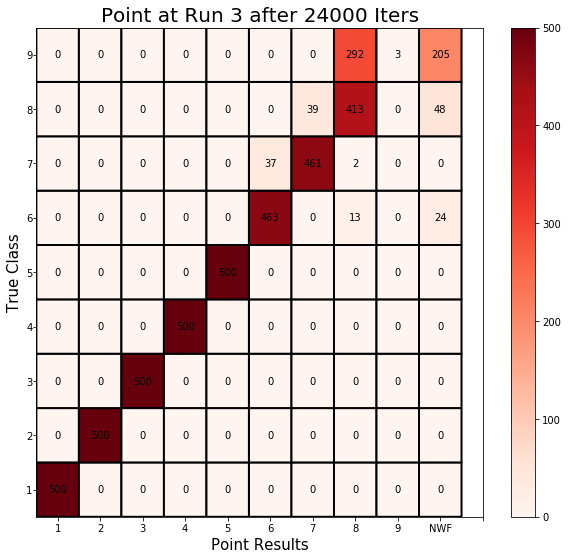

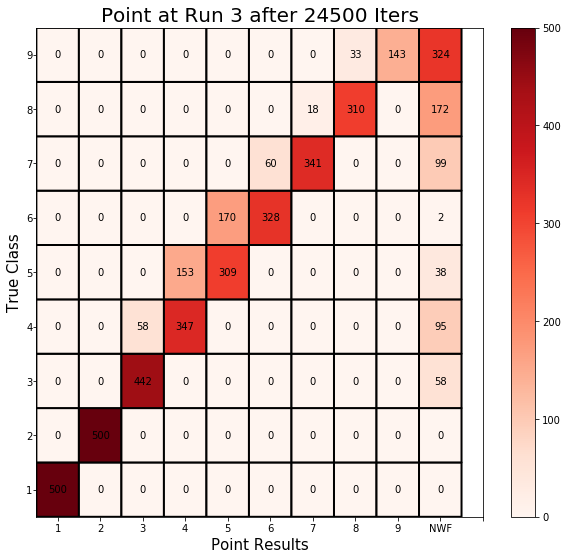

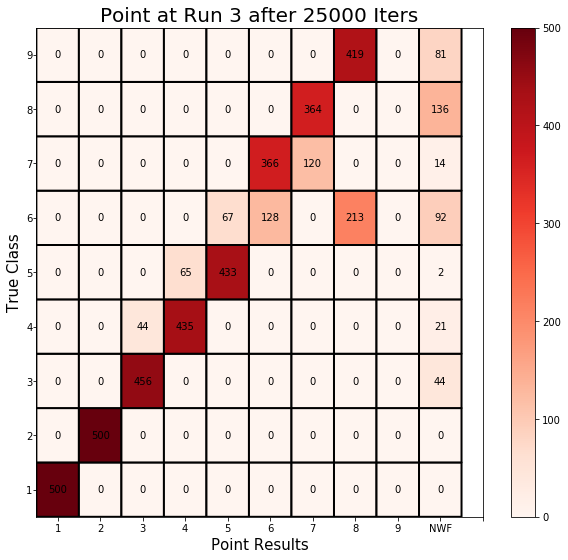

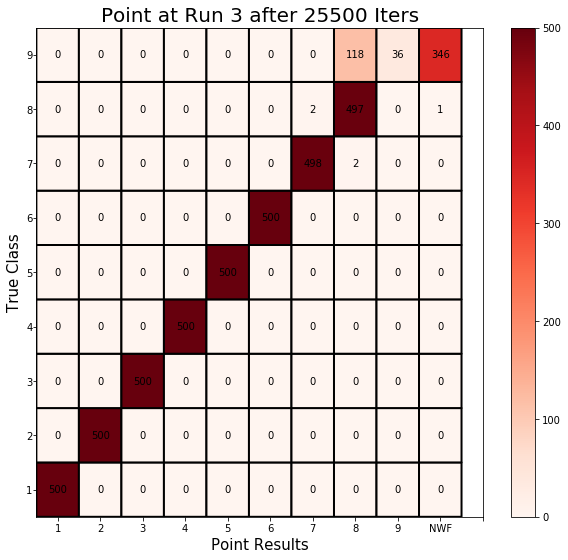

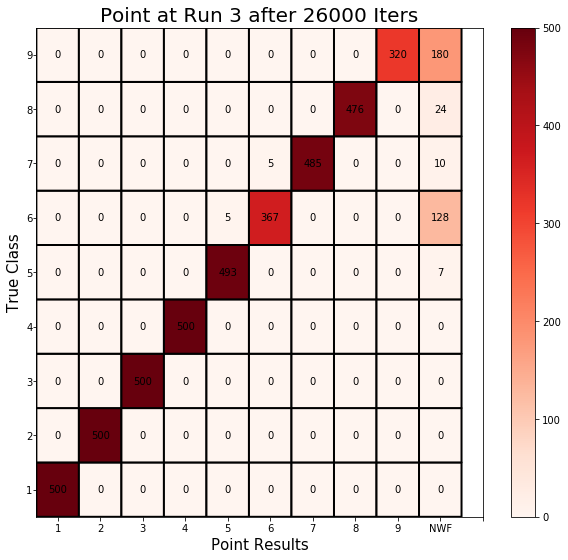

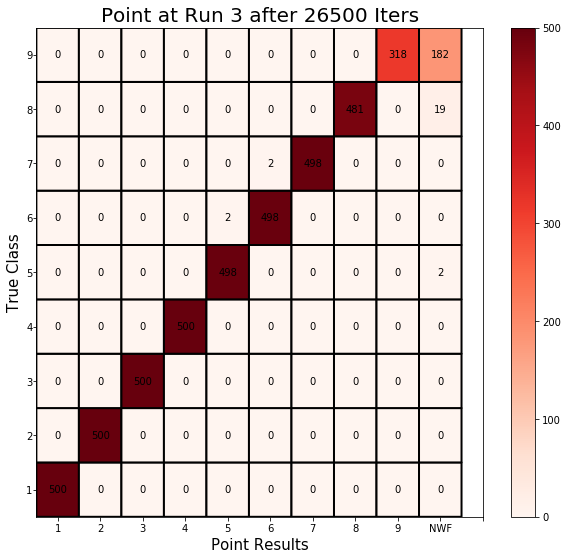

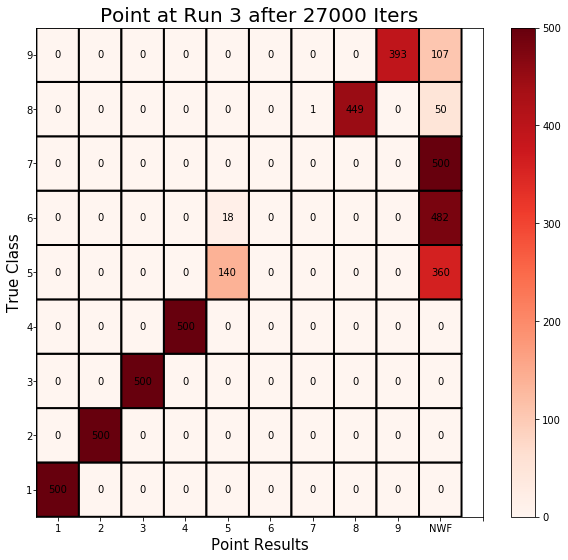

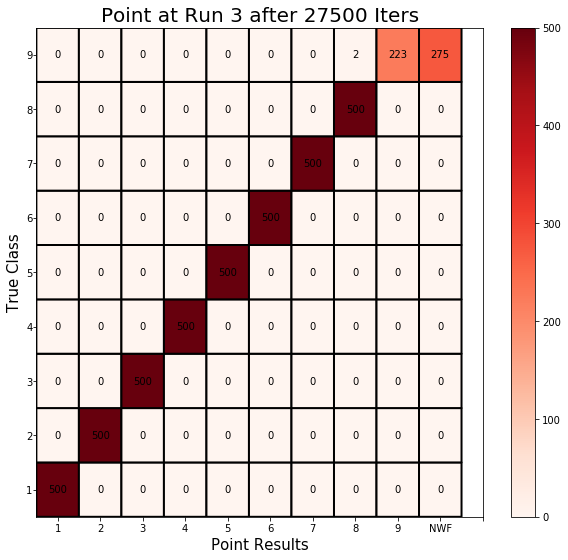

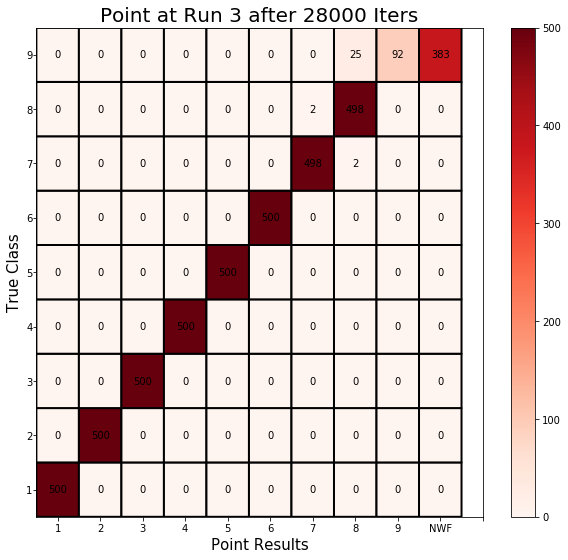

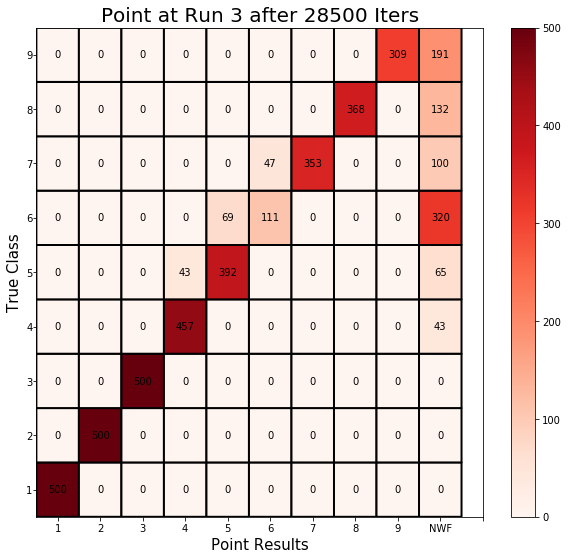

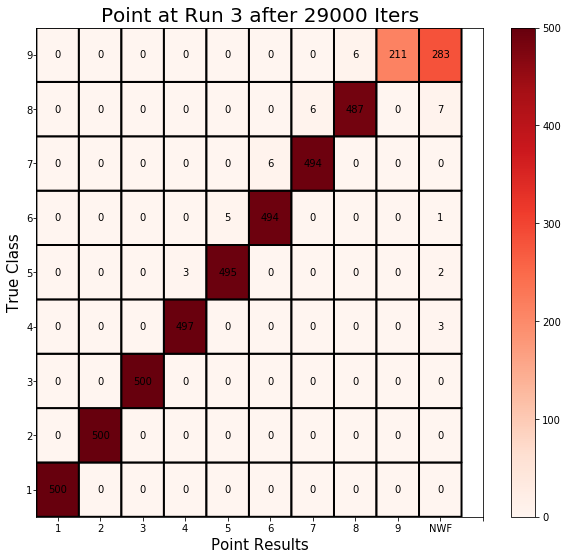

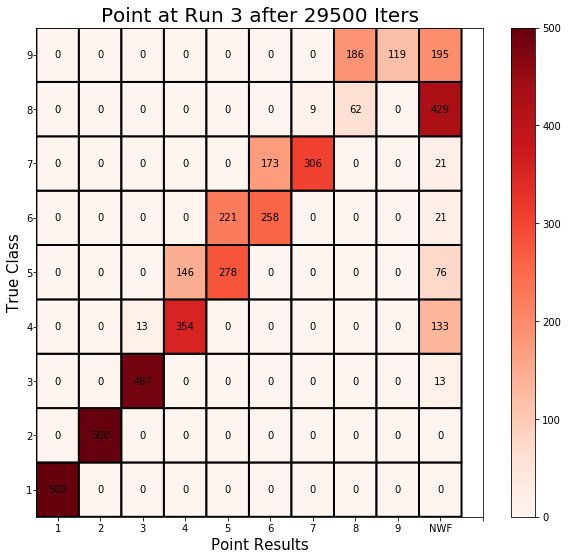

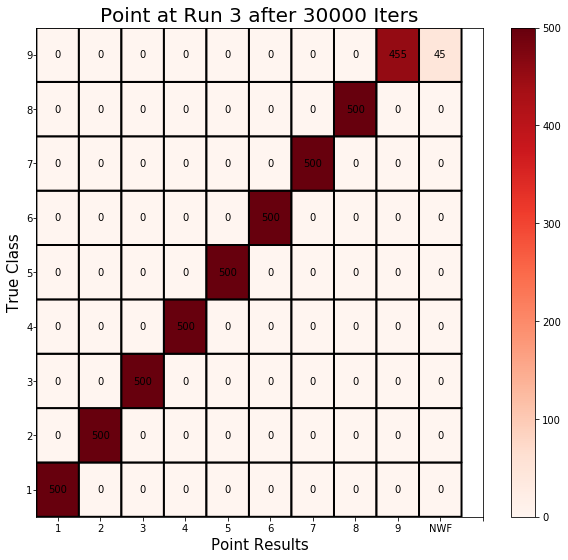

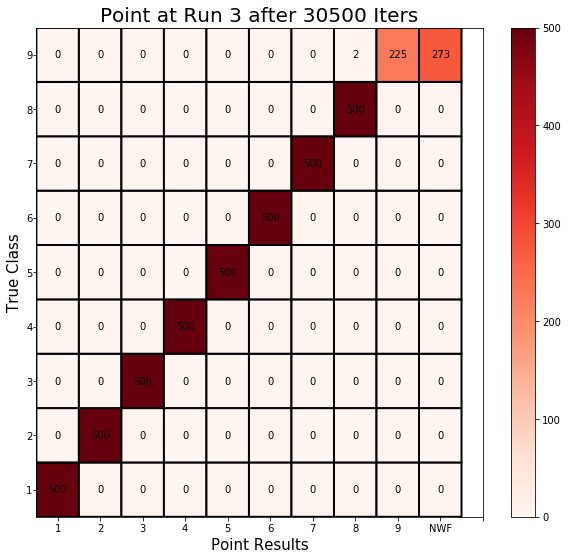

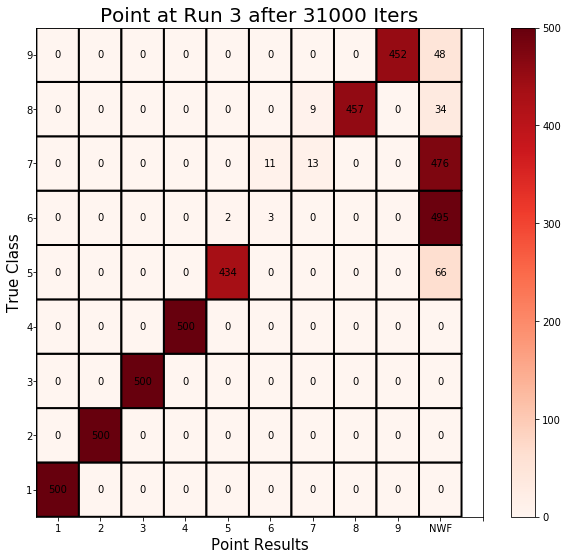

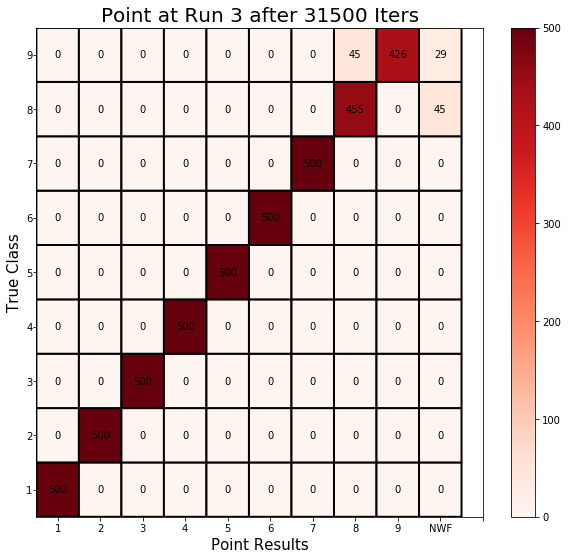

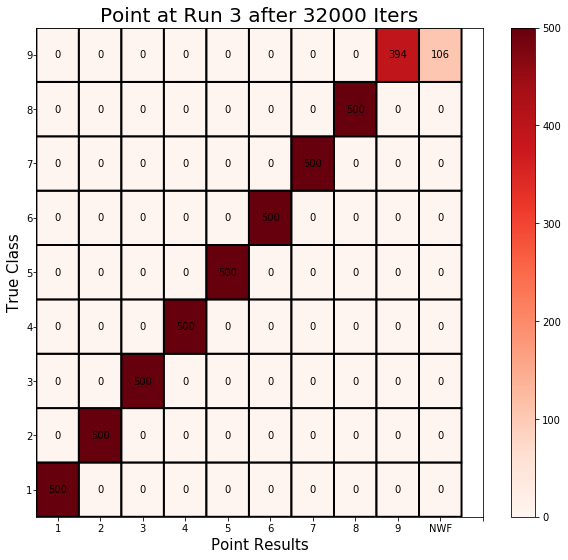

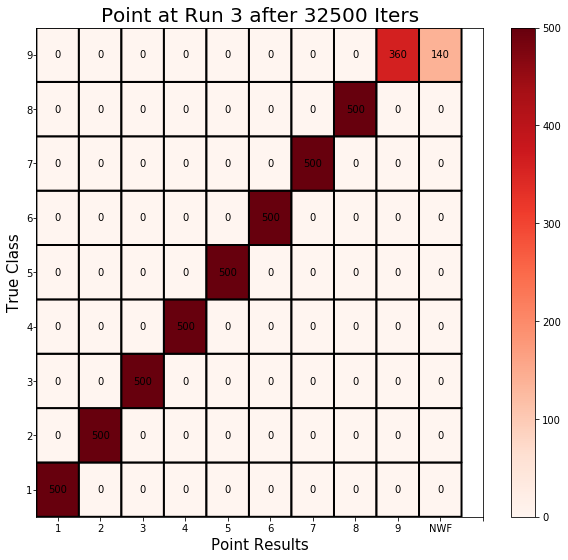

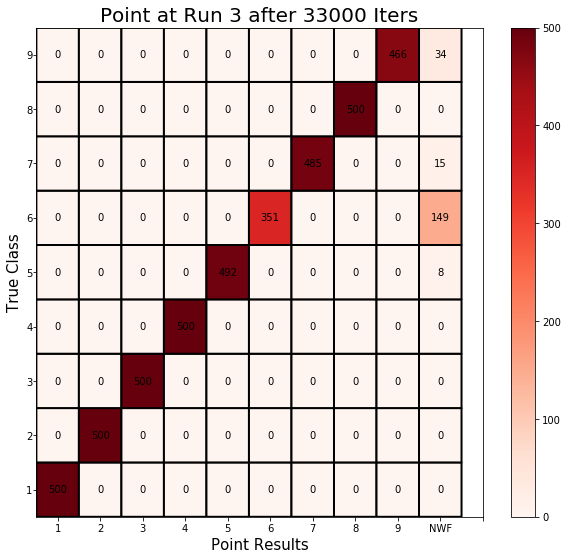

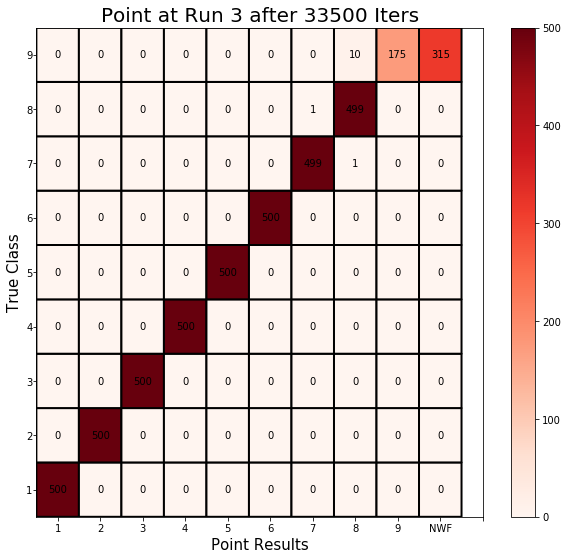

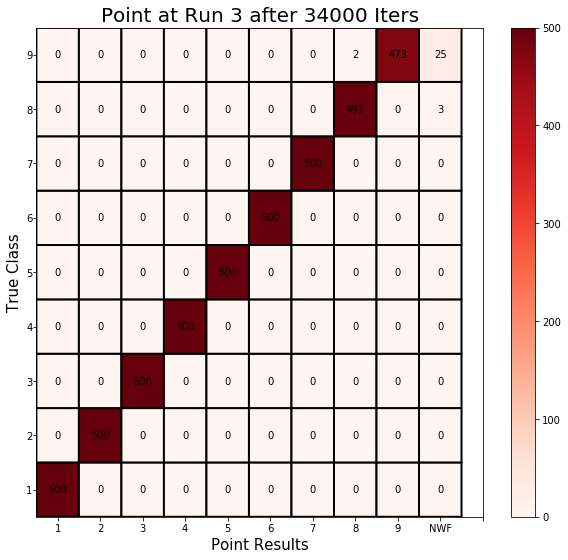

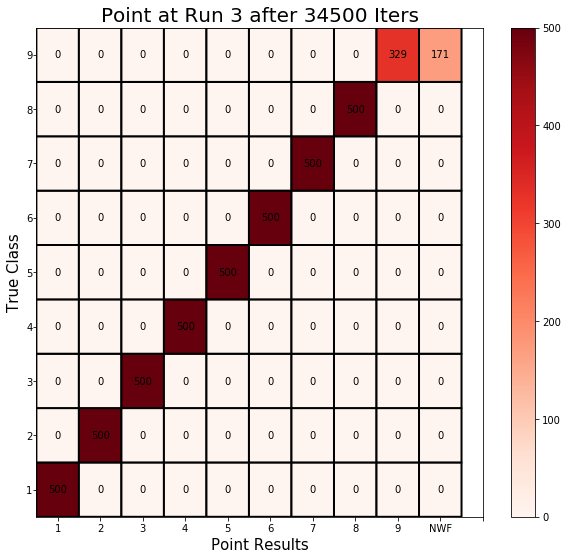

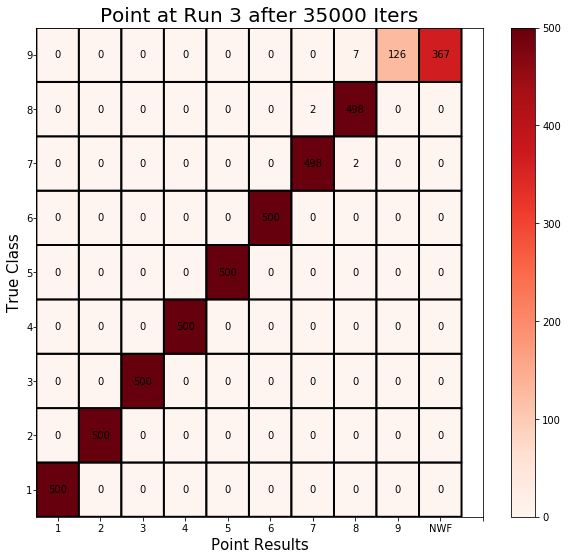

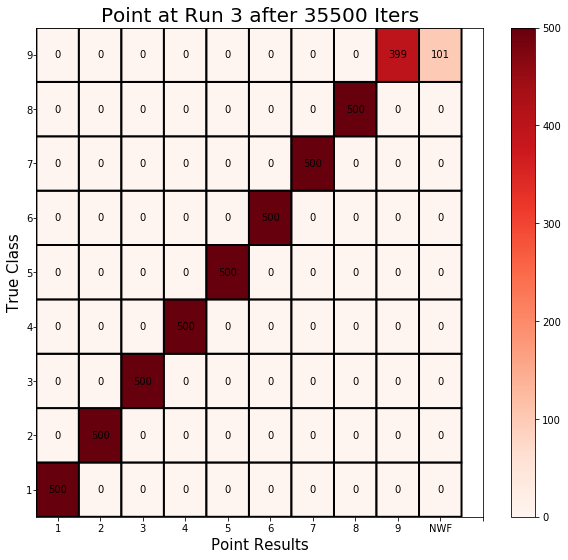

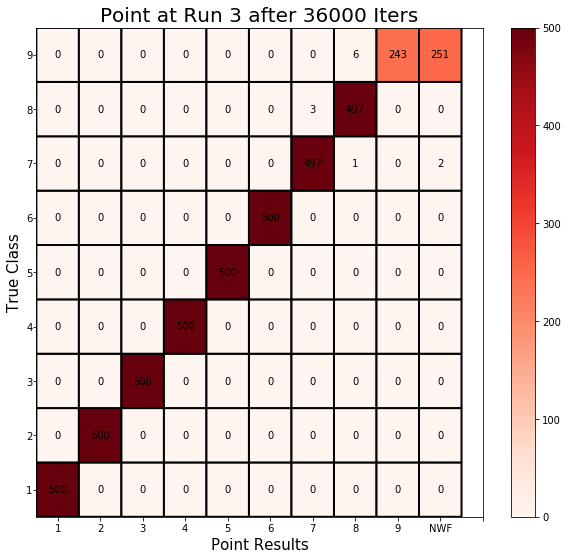

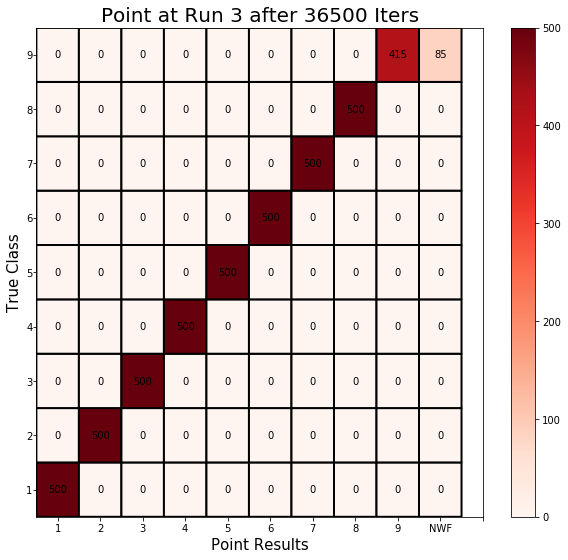

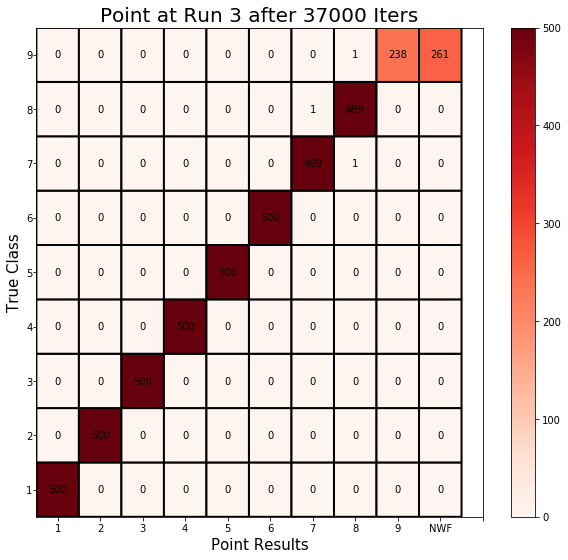

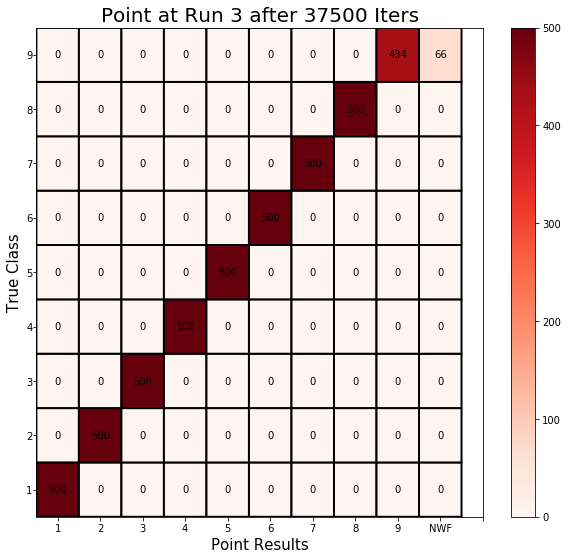

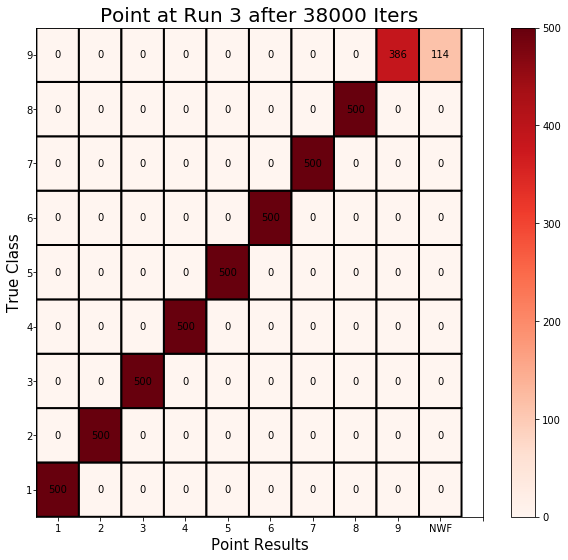

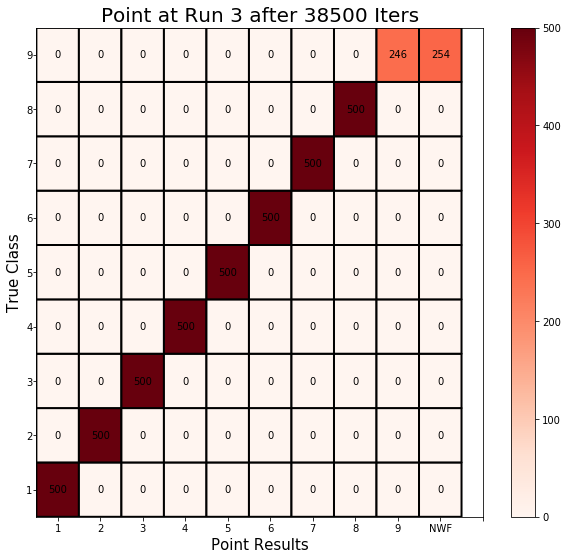

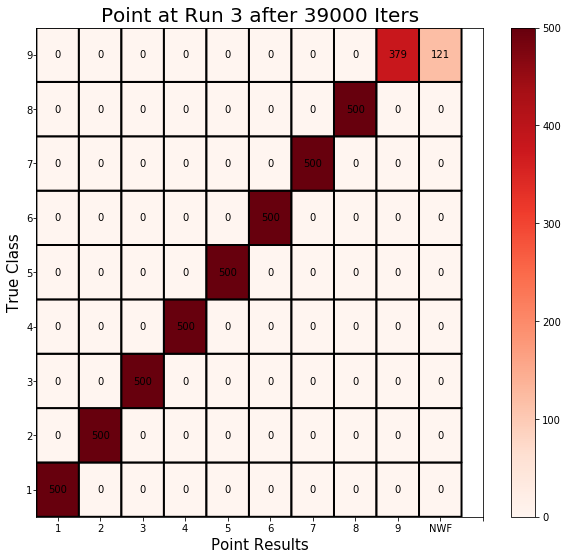

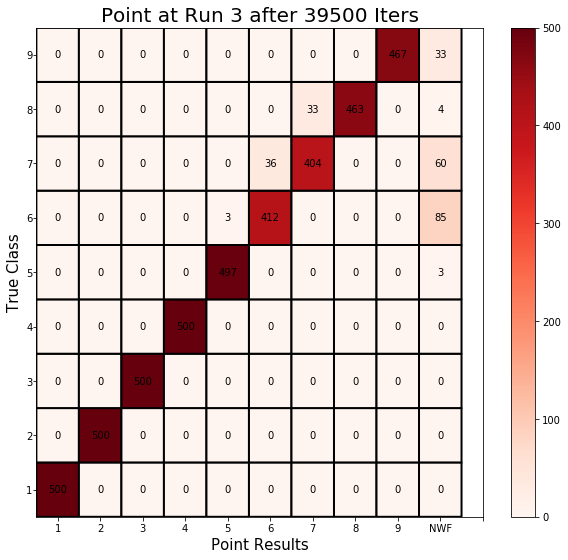

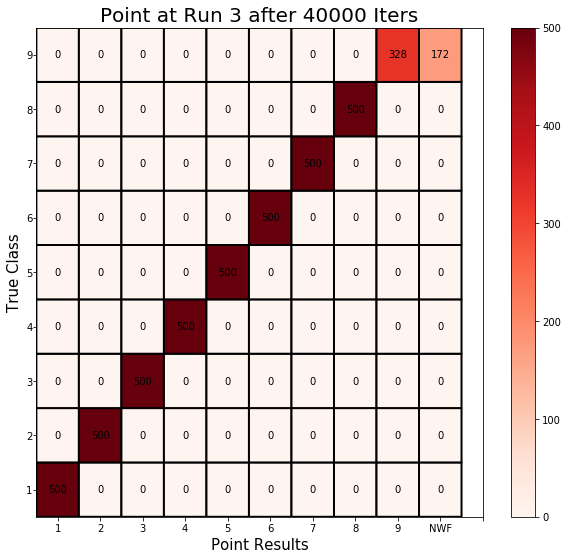

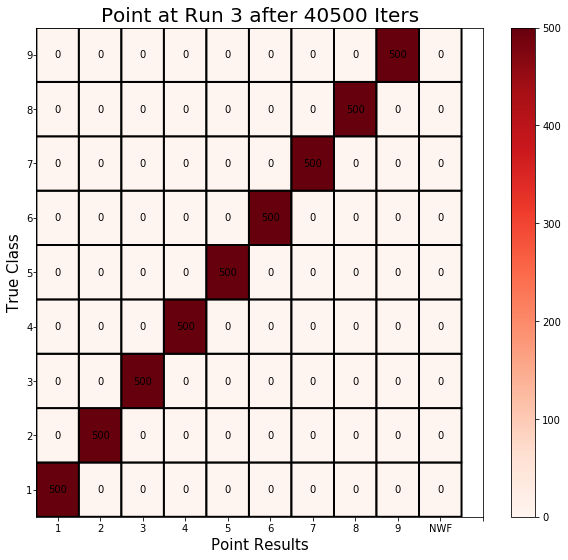

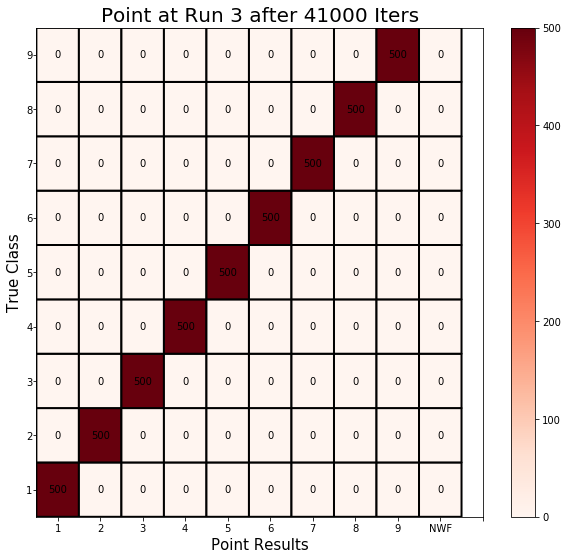

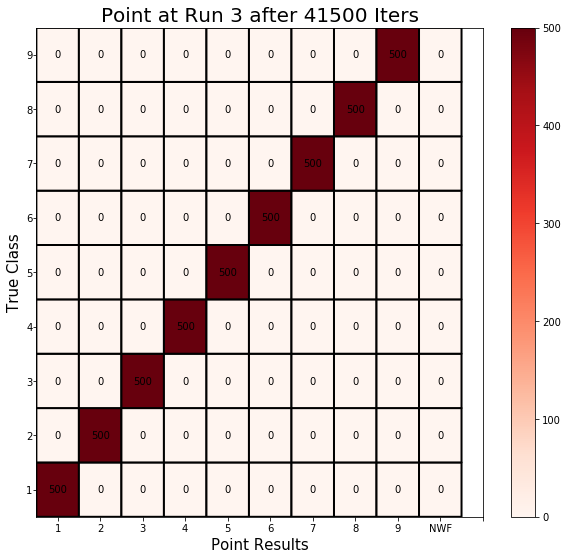

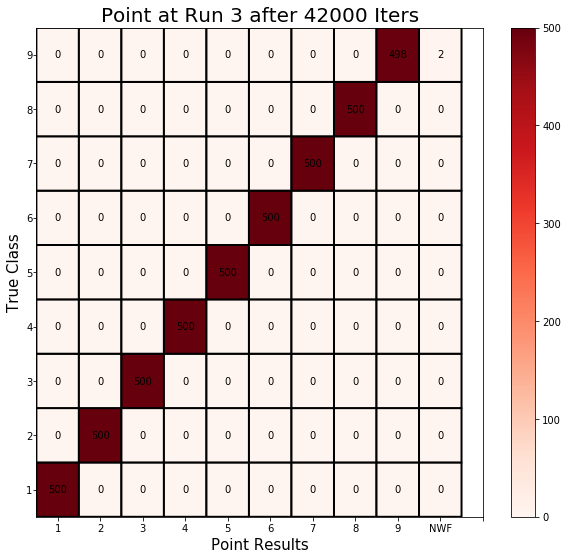

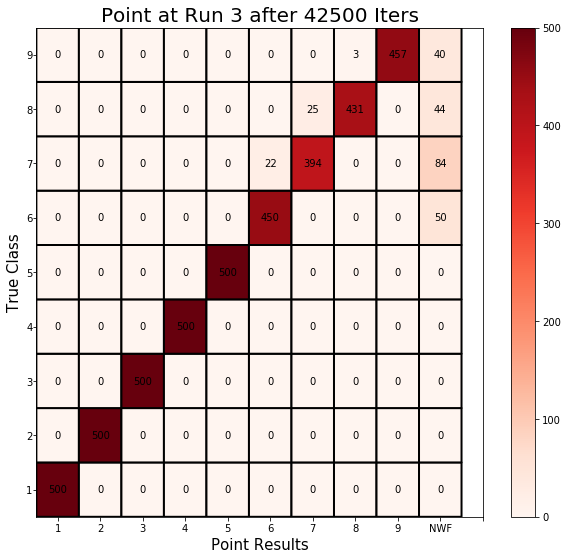

In [7]:
for run in range(num_runs):
    for it in range(num_iters):
        plot_point_results_wv(run,it)

In [8]:
np.save(data_directory + "point_results_hist", point_results)
np.save(data_directory + "point_accuracy_hist", point_accuracy)

In [10]:
# Point Accuracy
def plot_point_accuracy(self):
    """Plot the point accuracy."""
    for i in range(num_runs):
        fig, axs = plt.subplots(1, 1)
        plt.rcParams["figure.figsize"] = [10,6]
        x = np.linspace(iter_list[0], iter_list[num_iters-1], num_iters)
        y1 = self[i,0]
        y2 = self[i,1]
        y3 = self[i,2]
        y4 = self[i,3]
        y5 = self[i,4]
        y6 = self[i,5]
        y7 = self[i,6]
        y8 = self[i,7]
        y9 = self[i,8]
        l1, l2, l3, l4, l5, l6, l7, l8, l9 = axs.plot(x, y1, 'ro-', x, y2, 'bs-', x, y3, 'g^-', x, y4, 'c.-', x, y5, 'ms-', x, y6, 'y^-', x, y7, 'k.-', x, y8, 'cs--', x, y9, 'r^--')

        fig.legend((l1, l2, l3, l4, l5, l6, l7, l8, l9), ('1', '2', '3', '4', '5', '6', '7', '8', '9'), 'center right')
        plot_title = "Point Performance at Run %d" % (i + 1)
        plt.title(plot_title, fontsize=15)

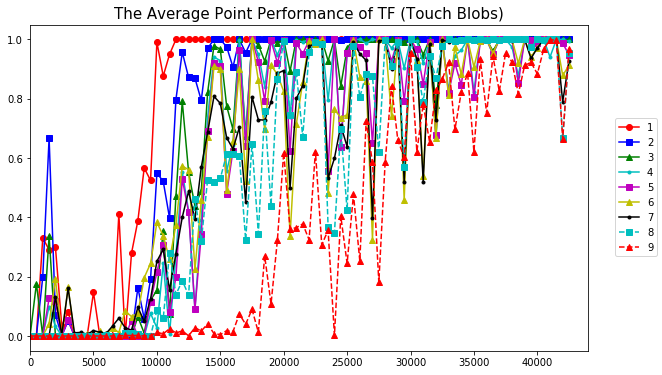

In [19]:
# Average point Accuracy
def plot_point_accuracy_avg(self):
    """Plot the point accuracy."""
    fig, axs = plt.subplots(1, 1)
    plt.rcParams["figure.figsize"] = [10,6]
    x = np.linspace(iter_list[0], iter_list[num_iters-1], num_iters)
    self_avg = np.mean(self,axis=0)
    y1 = self_avg[0]
    y2 = self_avg[1]
    y3 = self_avg[2]
    y4 = self_avg[3]
    y5 = self_avg[4]
    y6 = self_avg[5]
    y7 = self_avg[6]
    y8 = self_avg[7]
    y9 = self_avg[8]
    l1, l2, l3, l4, l5, l6, l7, l8, l9 = axs.plot(x, y1, 'ro-', x, y2, 'bs-', x, y3, 'g^-', x, y4, 'c.-', x, y5, 'ms-', x, y6, 'y^-', x, y7, 'k.-', x, y8, 'cs--', x, y9, 'r^--')

    fig.legend((l1, l2, l3, l4, l5, l6, l7, l8, l9), ('1', '2', '3', '4', '5', '6', '7', '8', '9'), 'center right')
    plot_title = "The Average Point Performance of TF (Touch Blobs)" 
    plt.title(plot_title, fontsize=15)
    plt.xlim(0,44000)
        
plot_point_accuracy_avg(point_accuracy)